In [46]:
import operator
import os
import numpy as np
from datetime import datetime
import pickle
import pandas as pd
import pytz

from qstrader.data.daily_bar_csv import CSVDailyBarDataSource
from qstrader.alpha_model.alpha_model import AlphaModel
from qstrader.alpha_model.fixed_signals import FixedSignalsAlphaModel
from qstrader.signals.buffer import AssetPriceBuffers
from qstrader.asset.equity import Equity
from qstrader.asset.universe.static import StaticUniverse
from qstrader.signals.signal import Signal 
from qstrader.signals.signals_collection import SignalsCollection
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading.backtest import BacktestTradingSession
from qstrader.simulation.sim_engine import SimulationEngine
from qstrader.simulation.event import SimulationEvent

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import BDay

import pandas_market_calendars as mcal


In [26]:
#strategy symbols
strategy_symbols = ['SPY']
strategy_assets = ['EQ:%s' % symbol for symbol in strategy_symbols]
strategy_universe = StaticUniverse(strategy_assets)
    
# data source to load only those provided symbols
csv_dir = os.environ.get('QSTRADER_CSV_DATA_DIR', '.')
data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])

Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...


In [58]:
start_dt = pd.Timestamp('2018-05-31 14:30:00', tz=pytz.UTC)
end_dt = pd.Timestamp('2022-06-06 23:59:00', tz=pytz.UTC)


class DailyBusinessDaySimulationEngine(SimulationEngine):
    
    def __init__(self, starting_day, ending_day, pre_market=True, post_market=True):
        if ending_day < starting_day:
            raise ValueError(
                "Ending date time %s is earlier than starting date time %s. "
                "Cannot create DailyBusinessDaySimulationEngine "
                "instance." % (ending_day, starting_day)
            )

        self.starting_day = starting_day
        self.ending_day = ending_day
        self.pre_market = pre_market
        self.post_market = post_market
        self.business_days = self._generate_business_days()

        def _generate_business_days(self):
            days = pd.date_range(
                self.starting_day, self.ending_day, freq= mcal.get_calendar('NYSE')
            )
            return days

DailyBusinessDaySimulationEngine(start_dt, end_dt, pre_market=False, post_market=False)
    

AttributeError: 'DailyBusinessDaySimulationEngine' object has no attribute '_generate_business_days'

In [ ]:
class DailyBusinessDaySimulationEngine(SimulationEngine):
    """
    A SimulationEngine subclass that generates events on a daily
    frequency defaulting to typical business days, that is
    Monday-Friday.
    In particular it does not take into account any specific
    regional holidays, such as Federal Holidays in the USA or
    Bank Holidays in the UK.
    It produces a pre-market event, a market open event,
    a market closing event and a post-market event for every day
    between the starting and ending dates.
    Parameters
    ----------
    starting_day : `pd.Timestamp`
        The starting day of the simulation.
    ending_day : `pd.Timestamp`
        The ending day of the simulation.
    pre_market : `Boolean`, optional
        Whether to include a pre-market event
    post_market : `Boolean`, optional
        Whether to include a post-market event
    """

    def __init__(self, starting_day, ending_day, pre_market=True, post_market=True):
        if ending_day < starting_day:
            raise ValueError(
                "Ending date time %s is earlier than starting date time %s. "
                "Cannot create DailyBusinessDaySimulationEngine "
                "instance." % (ending_day, starting_day)
            )

        self.starting_day = starting_day
        self.ending_day = ending_day
        self.pre_market = pre_market
        self.post_market = post_market
        self.business_days = self._generate_business_days()

    def _generate_business_days(self):
        """
        Generate the list of business days using midnight UTC as
        the timestamp.
        Returns
        -------
        `list[pd.Timestamp]`
            The business day range list.
        """
        days = pd.date_range(
            self.starting_day, self.ending_day, freq= mcal.get_calendar('NYSE')
        )
        return days

    def __iter__(self):
        """
        Generate the daily timestamps and event information
        for pre-market, market open, market close and post-market.
        Yields
        ------
        `SimulationEvent`
            Market time simulation event to yield
        """
        for index, bday in enumerate(self.business_days):
            year = bday.year
            month = bday.month
            day = bday.day

            if self.pre_market:
                yield SimulationEvent(
                    pd.Timestamp(
                        datetime.datetime(year, month, day), tz='UTC'
                    ), event_type="pre_market"
                )

            yield SimulationEvent(
                pd.Timestamp(
                    datetime.datetime(year, month, day, 14, 30),
                    tz=pytz.utc
                ), event_type="market_open"
            )

            yield SimulationEvent(
                pd.Timestamp(
                    datetime.datetime(year, month, day, 21, 00),
                    tz=pytz.utc
                ), event_type="market_close"
            )

            if self.post_market:
                yield SimulationEvent(
                    pd.Timestamp(
                        datetime.datetime(year, month, day, 23, 59), tz='UTC'
                    ), event_type="post_market"
                )

In [27]:
class MomentumSignal(Signal):
    """
    Indicator class to calculate lookback-period momentum
    (based on cumulative return of last N periods) for
    a set of prices.
    If the number of available returns is less than the
    lookback parameter the momentum is calculated on
    this subset.
    Parameters
    ----------
    start_dt : `pd.Timestamp`
        The starting datetime (UTC) of the signal.
    universe : `Universe`
        The universe of assets to calculate the signals for.
    lookbacks : `list[int]`
        The number of lookback periods to store prices for.
    """

    def __init__(self, start_dt, universe, lookbacks):
        bumped_lookbacks = [lookback for lookback in lookbacks]
        super().__init__(start_dt, universe, bumped_lookbacks)

    @staticmethod
    def _asset_lookback_key(asset, lookback):
        """
        Create the buffer dictionary lookup key based
        on asset name and lookback period.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `str`
            The lookup key.
        """
        return '%s_%s' % (asset, lookback)

    def _cumulative_return(self, asset, lookback):
        """
        Calculate the cumulative returns for the provided
        lookback period ('momentum') based on the price
        buffers for a particular asset.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `float`
            The cumulative return ('momentum') for the period.
        """
        series = pd.Series(
            self.buffers.prices[MomentumSignal._asset_lookback_key(asset, lookback)]
        )
        returns = series.pct_change().dropna().to_numpy()

        if len(returns) < 1:
            return 0.0
        else:
            return (np.cumprod(1.0 + np.array(returns)) - 1.0)[-1]

    def __call__(self, asset, lookback):
        """
        Calculate the lookback-period momentum
        for the asset.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `float`
            The momentum for the period.
        """
        return self._cumulative_return(asset, lookback)

In [42]:
#testing to see if the .loc method will pull the correct prediction
rf_regressor = pd.read_csv('random_forest_predictions.csv', parse_dates=True, index_col='Date' )
rf_regressor.drop(
        [
            "SPLookforward1"
        ],
        axis=1, inplace=True
    )

date = datetime(2018, 7, 4)
just_date = date.date()
just_date = str(just_date)
#teach it to handle holidays, why this is a problem now is beyond me. 
just_date = date.date()
just_date = str(just_date)
#teach it to handle holidays, why this is a problem now is beyond me. 
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2018, 5, 1), end=datetime(2022, 6, 30))
if just_date in holidays:
    prediction = int(1)
else:
    prediction = rf_regressor.loc[str(just_date)]['RF_Predict']
prediction

1

In [61]:
# I'm unsure if I should call this signals or signal. In the momentum example
# he's using a child class MomentumSignals. I don't need a lookback window,
# so I think I just need to use the parent class

class RandomForestAlphaModel(AlphaModel):
    #keep model static for now, but a look_back parameter could be added to modify the lookback window
    def __init__(self, rf_regressor, signals, lookback, universe, data_handler):
        self.rf_regressor = rf_regressor
        self.signals = signals
        self.lookback = lookback
        self.universe = universe
        self.data_handler = data_handler
    #methods
    # determining the regime is going to have to take time, i just think time
    # as parameters. 
    # time needs to be a parameter so it can look up the price on that day. 
    def determine_trade(
        self, dt
    ):
        just_date = dt.date()
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=datetime(2018, 5, 1), end=datetime(2022, 6, 30))
        try:
            prediction = rf_regressor.loc[str(just_date)]['RF_Predict']
        except KeyError: prediction = 1
        return prediction
    
    #generate the investment or sell signal. In this case return weight 1
    #if regime is favorable, or weight 0 if the regime isnt favorable
    def _generate_signals(
        self, dt, weights
    ):
        prediction = self.determine_trade(dt)
        asset = self.signals['momentum'].assets[0]
        if prediction >= 0:
            weights[asset] = 1
        else:
            weights[asset] = 0
        return weights

#threw this in there because it errored. 
    def __call__(
        self, dt
    ):
#         """
#         Calculates the signal weights for the top N
#         momentum alpha model, assuming that there is
#         sufficient data to begin calculating momentum
#         on the desired assets.

#         Parameters
#         ----------
#         dt : `pd.Timestamp`
#             The datetime for which the signal weights
#             should be calculated.

#         Returns
#         -------
#         `dict{str: float}`
#             The newly created signal weights dictionary.
#         """
        assets = self.universe.get_assets(dt)
        weights = {asset: 0.0 for asset in assets}

        # Only generate weights if the current time exceeds the
        # momentum lookback period
        if self.signals.warmup >= self.lookback:
            weights = self._generate_signals(dt, weights)
        return weights

In [62]:
#back_test parameters
if __name__ == "__main__":
    # Duration of the backtest
    start_dt = pd.Timestamp('2018-05-31 14:30:00', tz=pytz.UTC)
    end_dt = pd.Timestamp('2022-06-06 23:59:00', tz=pytz.UTC)
    
# load CSV
rf_regressor = pd.read_csv('random_forest_predictions.csv', parse_dates=True, index_col='Date' )
rf_regressor.drop(
        [
            "SPLookforward1"
        ],
        axis=1, inplace=True
    )

#Generate the signals. Still need this for the model to send changes to weights signal (place trades)
# NOTE: lookback must be passed as a list. lookback of [1] + momentum signal just calculates the returns from the previous day
#which is what HMM predicts off of.  
lookback = 2
lookbacks = [lookback]
returns_signal = MomentumSignal(start_dt, strategy_universe, lookbacks=lookbacks)
signals = SignalsCollection({'momentum': returns_signal}, data_handler)

#hidden markov strategy alpha model 
strategy_alpha_model = RandomForestAlphaModel(
    rf_regressor, signals, lookback, strategy_universe, data_handler
)

#try changing to long/short later
strategy_backtest = BacktestTradingSession(
    start_dt,
    end_dt,
    strategy_universe,
    strategy_alpha_model,
    signals = signals,
    rebalance = 'daily',
    long_only=True,
    #gross_leverage=1.00,
    cash_buffer_percentage=0.01,
    data_handler=data_handler,
    #rebalance_weekday = 'MON'
)
strategy_backtest.run()

benchmark_assets = ['EQ:SPY']
benchmark_universe = StaticUniverse(benchmark_assets)

# Construct a benchmark Alpha Model that provides
# 100% static allocation to the SPY ETF, with no rebalance


Initialising simulated broker "Backtest Simulated Broker Account"...
(2018-05-31 14:30:00+00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2018-05-31 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2018-05-31 14:30:00+00:00) - market_open
(2018-05-31 21:00:00+00:00) - market_close
(2018-05-31 21:00:00+00:00) - trading logic and rebalance
(2018-05-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2018-06-01 14:30:00+00:00) - market_open
(2018-06-01 21:00:00+00:00) - market_close
(2018-06-01 21:00:00+00:00) - trading logic and rebalance
(2018-06-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-06-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3874
(2018-06-04 14:30:00+00:00) - market_open
(2018-06-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 3874, price: 256.37, consideration: 993192.00, commission: 0.00, total: 993192.00
(2018-06-04 21:00:00+00:00) - m

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-05 21:00:00+00:00) - trading logic and rebalance
(2018-07-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-06 14:30:00+00:00) - market_open
(2018-07-06 21:00:00+00:00) - market_close
(2018-07-06 21:00:00+00:00) - trading logic and rebalance
(2018-07-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-09 14:30:00+00:00) - market_open
(2018-07-09 21:00:00+00:00) - market_close
(2018-07-09 21:00:00+00:00) - trading logic and rebalance
(2018-07-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-07-10 14:30:00+00:00) - market_open
(2018-07-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 261.16, consideration: -261.00, commission: 0.00, total: -261.00
(2018-07-10 21:00:00+00:00) - market_close
(2018-07-10 21:00:00+00:00) - trading logic and rebalance
(2018-07-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-11 14:30:00+00:00) - market_open
(2018-07-11 21:00:00+00:00) - market_close
(2018-07-11 21:00:00+00:00) - trading logic and rebalance
(2018-07-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-07-12 14:30:00+00:00) - market_open
(2018-07-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 261.04, consideration: 261.00, commission: 0.00, total: 261.00
(2018-07-12 21:00:00+00:00) - market_close
(2018-07-12 21:00:00+00:00) - trading logic and rebalance
(2018-07-12 21:00:00+00:00) - target weights: {'EQ:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-16 21:00:00+00:00) - market_close
(2018-07-16 21:00:00+00:00) - trading logic and rebalance
(2018-07-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-17 14:30:00+00:00) - market_open
(2018-07-17 21:00:00+00:00) - market_close
(2018-07-17 21:00:00+00:00) - trading logic and rebalance
(2018-07-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-18 14:30:00+00:00) - market_open
(2018-07-18 21:00:00+00:00) - market_close
(2018-07-18 21:00:00+00:00) - trading logic and rebalance
(2018-07-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-19 14:30:00+00:00) - market_open
(2018-07-19 21:00:00+00:00) - market_close
(2018-07-19 21:00:00+00:00) - trading logic and rebalance
(2018-07-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-20 14:30:00+00:00) - market_open
(2018-07-20 21:00:00+00:00) - market_close
(2018-07-20 21:00:00+00:00) - trading logic and rebalance
(2018-07-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-23 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-23 21:00:00+00:00) - market_close
(2018-07-23 21:00:00+00:00) - trading logic and rebalance
(2018-07-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-24 14:30:00+00:00) - market_open
(2018-07-24 21:00:00+00:00) - market_close
(2018-07-24 21:00:00+00:00) - trading logic and rebalance
(2018-07-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-25 14:30:00+00:00) - market_open
(2018-07-25 21:00:00+00:00) - market_close
(2018-07-25 21:00:00+00:00) - trading logic and rebalance
(2018-07-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-26 14:30:00+00:00) - market_open
(2018-07-26 21:00:00+00:00) - market_close
(2018-07-26 21:00:00+00:00) - trading logic and rebalance
(2018-07-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-27 14:30:00+00:00) - market_open
(2018-07-27 21:00:00+00:00) - market_close
(2018-07-27 21:00:00+00:00) - trading logic and rebalance
(2018-07-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-30 14:30:00+00:00) - market_open
(2018-07-30 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-07-30 21:00:00+00:00) - trading logic and rebalance
(2018-07-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-07-31 14:30:00+00:00) - market_open
(2018-07-31 21:00:00+00:00) - market_close
(2018-07-31 21:00:00+00:00) - trading logic and rebalance
(2018-07-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-01 14:30:00+00:00) - market_open
(2018-08-01 21:00:00+00:00) - market_close
(2018-08-01 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-08-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-02 14:30:00+00:00) - market_open
(2018-08-02 21:00:00+00:00) - market_close
(2018-08-02 21:00:00+00:00) - trading logic and rebalance
(2018-08-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-03 14:30:00+00:00) - market_open
(2018-08-03 21:00:00+00:00) - market_close
(2018-08-03 21:00:00+00:00) - trading logic and rebalance
(2018-08-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-06 14:30:00+00:00) - market_open
(2018-08-06 21:00:00+00:00) - market_close
(2018-08-06 21:00:00+00:00) - trading logic and rebalance
(2018-08-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-07 14:30:00+00:00) - market_open
(2018-08-07 21:00:00+00:00) - market_close
(2018-08-07 21:00:00+00:00) - trading logic and rebalance
(2018-08-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-08-08 14:30:00+00:00) - market_open
(2018-08-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 267.71, consideration: -268.00, commission: 0.00, total: -268.00
(2018-08-08 21:00:00+00:00) - market_close
(2018-08-08 21:00:00+00:00) - trading logic and rebalance
(2018-08-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-09 14:30:00+00:00) - market_open
(2018-08-09 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-09 21:00:00+00:00) - trading logic and rebalance
(2018-08-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-10 14:30:00+00:00) - market_open
(2018-08-10 21:00:00+00:00) - market_close
(2018-08-10 21:00:00+00:00) - trading logic and rebalance
(2018-08-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-08-13 14:30:00+00:00) - market_open
(2018-08-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 265.91, consideration: 266.00, commission: 0.00, total: 266.00
(2018-08-13 21:00:00+00:00) - market_close
(2018-08-13 21:00:00+00:00) - trading logic and rebalance
(2018-08-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-14 14:30:00+00:00) - market_open
(2018-08-14 21:00:00+00:00) - market_close
(2018-08-14 21:00:00+00:00) - trading logic and rebalance
(2018-08-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-08-15 14:30:00+00:00) - market_open
(2018-08-15 21:00:00+00:00) - market_close
(2018-08-15 21:00:00+00:00) - trading logic and rebalance
(2018-08-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-16 14:30:00+00:00) - market_open
(2018-08-16 21:00:00+00:00) - market_close
(2018-08-16 21:00:00+00:00) - trading logic and rebalance
(2018-08-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-17 14:30:00+00:00) - market_open
(2018-08-17 21:00:00+00:00) - market_close
(2018-08-17 21:00:00+00:00) - trading logic and rebalance
(2018-08-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-08-20 14:30:00+00:00) - market_open
(2018-08-20 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 267.88, consideration: -268.00, commission: 0.00, total: -268.00
(2018-08-20 21:00:00+00:00) - market_close
(2018-08-20 21:00:00+00:00) - trading logic and rebalance
(2018-08-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-21 14:30:00+00:00) - market_open
(2018-08-21 21:00:00+00:00) - market_close
(2018-08-21 21:00:00+00:00) - trading logic and rebalance
(2018-08-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-22 14:30:00+00:00) - market_open
(2018-08-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-08-22 21:00:00+00:00) - trading logic and rebalance
(2018-08-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-23 14:30:00+00:00) - market_open
(2018-08-23 21:00:00+00:00) - market_close
(2018-08-23 21:00:00+00:00) - trading logic and rebalance
(2018-08-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-24 14:30:00+00:00) - market_open
(2018-08-24 21:00:00+00:00) - market_close
(2018-08-24 21:00:00+00:00) - trading logic and rebalance
(2018-08-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-08-27 14:30:00+00:00) - market_open
(2018-08-27 21:00:00+00:00) - market_close
(2018-08-27 21:00:00+00:00) - trading logic and rebalance
(2018-08-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-28 14:30:00+00:00) - market_open
(2018-08-28 21:00:00+00:00) - market_close
(2018-08-28 21:00:00+00:00) - trading logic and rebalance
(2018-08-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-29 14:30:00+00:00) - market_open
(2018-08-29 21:00:00+00:00) - market_close
(2018-08-29 21:00:00+00:00) - trading logic and rebalance
(2018-08-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-08-30 14:30:00+00:00) - market_open
(2018-08-30 21:00:00+00:00) - market_close
(2018-08-30 21:00:00+00:00) - trading logic and rebalance
(2018-08-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-08-31 14:30:00+00:00) - market_open
(2018-08-31 21:00:00+00:00) - market_close
(2018-08-31 21:00:00+00:00) - trading logic and rebalance
(2018-08-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-03 14:30:00+00:00) - market_open
(2018-09-03 21:00:00+00:00) - market_close
(2018-09-03 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-04 14:30:00+00:00) - market_open
(2018-09-04 21:00:00+00:00) - market_close
(2018-09-04 21:00:00+00:00) - trading logic and rebalance
(2018-09-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-05 14:30:00+00:00) - market_open
(2018-09-05 21:00:00+00:00) - market_close
(2018-09-05 21:00:00+00:00) - trading logic and rebalance
(2018-09-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-09-06 14:30:00+00:00) - market_open
(2018-09-06 21:00:00+00:00) - market_close
(2018-09-06 21:00:00+00:00) - trading logic and rebalance
(2018-09-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-07 14:30:00+00:00) - market_open
(2018-09-07 21:00:00+00:00) - market_close
(2018-09-07 21:00:00+00:00) - trading logic and rebalance
(2018-09-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-10 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-10 21:00:00+00:00) - market_close
(2018-09-10 21:00:00+00:00) - trading logic and rebalance
(2018-09-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-11 14:30:00+00:00) - market_open
(2018-09-11 21:00:00+00:00) - market_close
(2018-09-11 21:00:00+00:00) - trading logic and rebalance
(2018-09-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-12 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-09-12 21:00:00+00:00) - market_close
(2018-09-12 21:00:00+00:00) - trading logic and rebalance
(2018-09-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-13 14:30:00+00:00) - market_open
(2018-09-13 21:00:00+00:00) - market_close
(2018-09-13 21:00:00+00:00) - trading logic and rebalance
(2018-09-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-14 14:30:00+00:00) - market_open
(2018-09-14 21:00:00+00:00) - market_close
(2018-09-14 21:00:00+00:00) - trading logic and rebalance
(2018-09-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-17 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-17 21:00:00+00:00) - market_close
(2018-09-17 21:00:00+00:00) - trading logic and rebalance
(2018-09-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-18 14:30:00+00:00) - market_open
(2018-09-18 21:00:00+00:00) - market_close
(2018-09-18 21:00:00+00:00) - trading logic and rebalance
(2018-09-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-19 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-19 21:00:00+00:00) - market_close
(2018-09-19 21:00:00+00:00) - trading logic and rebalance
(2018-09-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-20 14:30:00+00:00) - market_open
(2018-09-20 21:00:00+00:00) - market_close
(2018-09-20 21:00:00+00:00) - trading logic and rebalance
(2018-09-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-09-21 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-21 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 276.18, consideration: -276.00, commission: 0.00, total: -276.00
(2018-09-21 21:00:00+00:00) - market_close
(2018-09-21 21:00:00+00:00) - trading logic and rebalance
(2018-09-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-24 14:30:00+00:00) - market_open
(2018-09-24 21:00:00+00:00) - market_close
(2018-09-24 21:00:00+00:00) - trading logic and rebalance
(2018-09-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-25 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-25 21:00:00+00:00) - market_close
(2018-09-25 21:00:00+00:00) - trading logic and rebalance
(2018-09-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-09-26 14:30:00+00:00) - market_open
(2018-09-26 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 274.13, consideration: 274.00, commission: 0.00, total: 274.00
(2018-09-26 21:00:00+00:00) - market_close
(2018-09-26 21:00:00+00:00) - trading logic and rebalance
(2018-09-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-09-27 14:30:00+00:00) - market_open
(2018-09-27 21:00:00+00:00) - market_close
(2018-09-27 21:00:00+00:00) - trading logic and rebalance
(2018-09-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-09-28 14:30:00+00:00) - market_open
(2018-09-28 21:00:00+00:00) - market_close
(2018-09-28 21:00:00+00:00) - trading logic and rebalance
(2018-09-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-01 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-01 21:00:00+00:00) - market_close
(2018-10-01 21:00:00+00:00) - trading logic and rebalance
(2018-10-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-10-02 14:30:00+00:00) - market_open
(2018-10-02 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 274.74, consideration: -275.00, commission: 0.00, total: -275.00
(2018-10-02 21:00:00+00:00) - market_close
(2018-10-02 21:00:00+00:00) - trading logic and rebalance
(2018-10-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-03 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-03 21:00:00+00:00) - market_close
(2018-10-03 21:00:00+00:00) - trading logic and rebalance
(2018-10-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-04 14:30:00+00:00) - market_open
(2018-10-04 21:00:00+00:00) - market_close
(2018-10-04 21:00:00+00:00) - trading logic and rebalance
(2018-10-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-10-05 14:30:00+00:00) - market_open
(2018-10-05 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 272.98, consideration: 273.00, commission: 0.00, total: 273.00
(2018-10-05 21:00:00+00:00) - market_close
(2018-10-05 21:00:00+00:00) - trading logic and rebalance
(2018-10-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-08 14:30:00+00:00) - market_open
(2018-10-08 21:00:00+00:00) - market_close
(2018-10-08 21:00:00+00:00) - trading logic and rebalance
(2018-10-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-09 14:30:00+00:00) - market_open
(2018-10-09 21:00:00+00:00) - market_close
(2018-10-09 21:00:00+00:00) - trading logic and rebalance
(2018-10-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-10 14:30:00+00:00) - market_open
(2018-10-10 21:00:00+00:00) - market_close
(2018-10-10 21:00:00+00:00) - trading logic and rebalance
(2018-10-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-10-11 14:30:00+00:00) - market_open
(2018-10-11 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 261.09, consideration: 261.00, commission: 0.00, total: 261.00
(2018-10-11 21:00:00+00:00) - market_close
(2018-10-11 21:00:00+00:00) - trading logic and rebalance
(2018-10-11 21:00:00+00:00) - target weights: {'EQ

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-10-15 21:00:00+00:00) - market_close
(2018-10-15 21:00:00+00:00) - trading logic and rebalance
(2018-10-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-16 14:30:00+00:00) - market_open
(2018-10-16 21:00:00+00:00) - market_close
(2018-10-16 21:00:00+00:00) - trading logic and rebalance
(2018-10-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-10-17 14:30:00+00:00) - market_open
(2018-10-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 264.26, consideration: -264.00, commission: 0.00, total: -264.00
(2018-10-17 21:00:00+00:00) - market_close
(2018-10-17 21:00:00+00:00) - trading logic and rebalance
(2018-10-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-18 14:30:00+00:00) - market_open
(2018-10-18 21:00:00+00:00) - market_close
(2018-10-18 21:00:00+00:00) - trading logic and rebalance
(2018-10-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-10-19 14:30:00+00:00) - market_open
(2018-10-19 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 261.14, consideration: 261.00, commission: 0.00, total: 261.00
(2018-10-19 21:00:00+00:00) - market_close
(2018-10-19 21:00:00+00:00) - trading logic and rebalance
(2018-10-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-22 14:30:00+00:00) - market_open
(2018-10-22 21:00:00+00:00) - market_close
(2018-10-22 21:00:00+00:00) - trading logic and rebalance
(2018-10-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-23 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-10-23 21:00:00+00:00) - market_close
(2018-10-23 21:00:00+00:00) - trading logic and rebalance
(2018-10-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-24 14:30:00+00:00) - market_open
(2018-10-24 21:00:00+00:00) - market_close
(2018-10-24 21:00:00+00:00) - trading logic and rebalance
(2018-10-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-10-25 14:30:00+00:00) - market_open
(2018-10-25 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 251.95, consideration: 252.00, commission: 0.00, total: 252.00
(2018-10-25 21:00:00+00:00) - market_close
(2018-10-25 21:00:00+00:00) - trading logic and rebalance
(2018-10-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-10-26 14:30:00+00:00) - market_open
(2018-10-26 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 250.58, consideration: -251.00, commission: 0.00, total: -251.00
(2018-10-26 21:00:00+00:00) - market_close
(2018-10-26 21:00:00+00:00) - trading logic and rebalance
(2018-10-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-10-29 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-29 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 253.29, consideration: 253.00, commission: 0.00, total: 253.00
(2018-10-29 21:00:00+00:00) - market_close
(2018-10-29 21:00:00+00:00) - trading logic and rebalance
(2018-10-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-30 14:30:00+00:00) - market_open
(2018-10-30 21:00:00+00:00) - market_close
(2018-10-30 21:00:00+00:00) - trading logic and rebalance
(2018-10-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-10-31 14:30:00+00:00) - market_open
(2018-10-31 21:00:00+00:00) - market_close
(2018-10-31 21:00:00+00:00) - trading logic and rebalance
(2018-10-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-10-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-11-01 14:30:00+00:00) - market_open
(2018-11-01 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 255.93, consideration: -256.00, commission: 0.00, total: -256.00
(2018-11-01 21:00:00+00:00) - market_close
(2018-11-01 21:00:00+00:00) - trading logic and rebalance
(2018-11-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-02 14:30:00+00:00) - market_open
(2018-11-02 21:00:00+00:00) - market_close
(2018-11-02 21:00:00+00:00) - trading logic and rebalance
(2018-11-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-05 14:30:00+00:00) - market_open
(2018-11-05 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-05 21:00:00+00:00) - trading logic and rebalance
(2018-11-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-06 14:30:00+00:00) - market_open
(2018-11-06 21:00:00+00:00) - market_close
(2018-11-06 21:00:00+00:00) - trading logic and rebalance
(2018-11-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-07 14:30:00+00:00) - market_open
(2018-11-07 21:00:00+00:00) - market_close
(2018-11-07 21:00:00+00:00) - trading logic and rebalance
(2018-11-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-11-08 14:30:00+00:00) - market_open
(2018-11-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 263.95, consideration: -264.00, commission: 0.00, total: -264.00
(2018-11-08 21:00:00+00:00) - market_close
(2018-11-08 21:00:00+00:00) - trading logic and rebalance
(2018-11-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-09 14:30:00+00:00) - market_open
(2018-11-09 21:00:00+00:00) - market_close
(2018-11-09 21:00:00+00:00) - trading logic and rebalance
(2018-11-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-12 14:30:00+00:00) - market_open
(2018-11-12 21:00:00+00:00) - market_close
(2018-11-12 21:00:00+00:00) - trading logic and rebalance
(2018-11-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-11-13 14:30:00+00:00) - market_open
(2018-11-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 257.33, consideration: 257.00, commission: 0.00, total: 257.00
(2018-11-13 21:00:00+00:00) - market_close
(2018-11-13 21:00:00+00:00) - trading logic and rebalance
(2018-11-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-14 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-14 21:00:00+00:00) - market_close
(2018-11-14 21:00:00+00:00) - trading logic and rebalance
(2018-11-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-15 14:30:00+00:00) - market_open
(2018-11-15 21:00:00+00:00) - market_close
(2018-11-15 21:00:00+00:00) - trading logic and rebalance
(2018-11-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-16 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-16 21:00:00+00:00) - market_close
(2018-11-16 21:00:00+00:00) - trading logic and rebalance
(2018-11-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-19 14:30:00+00:00) - market_open
(2018-11-19 21:00:00+00:00) - market_close
(2018-11-19 21:00:00+00:00) - trading logic and rebalance
(2018-11-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-19 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-11-20 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-20 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 250.05, consideration: 250.00, commission: 0.00, total: 250.00
(2018-11-20 21:00:00+00:00) - market_close
(2018-11-20 21:00:00+00:00) - trading logic and rebalance
(2018-11-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-21 14:30:00+00:00) - market_open
(2018-11-21 21:00:00+00:00) - market_close
(2018-11-21 21:00:00+00:00) - trading logic and rebalance
(2018-11-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-22 14:30:00+00:00) - market_open
(2018-11-22 21:00:00+00:00) - market_close
(2018-11-22 21:00:00+00:00) - trading logic and rebalance
(2018-11-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-23 14:30:00+00:00) - market_open
(2018-11-23 21:00:00+00:00) - market_close
(2018-11-23 21:00:00+00:00) - trading logic and rebalance
(2018-11-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-26 14:30:00+00:00) - market_open
(2018-11-26 21:00:00+00:00) - market_close
(2018-11-26

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-11-27 14:30:00+00:00) - market_open
(2018-11-27 21:00:00+00:00) - market_close
(2018-11-27 21:00:00+00:00) - trading logic and rebalance
(2018-11-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-28 14:30:00+00:00) - market_open
(2018-11-28 21:00:00+00:00) - market_close
(2018-11-28 21:00:00+00:00) - trading logic and rebalance
(2018-11-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-11-29 14:30:00+00:00) - market_open
(2018-11-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 257.92, consideration: -258.00, commission: 0.00, total: -258.00
(2018-11-29 21:00:00+00:00) - market_close
(2018-11-29 21:00:00+00:00) - trading logic and rebalance
(2018-11-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-11-30 14:30:00+00:00) - market_open
(2018-11-30 21:00:00+00:00) - market_close
(2018-11-30 21:00:00+00:00) - trading logic and rebalance
(2018-11-30 21:00:00+00:00) - target weights: 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2018-12-04 14:30:00+00:00) - market_open
(2018-12-04 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 262.31, consideration: -262.00, commission: 0.00, total: -262.00
(2018-12-04 21:00:00+00:00) - market_close
(2018-12-04 21:00:00+00:00) - trading logic and rebalance
(2018-12-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2018-12-05 14:30:00+00:00) - market_open
(2018-12-05 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 254.66, consideration: 509.00, commission: 0.00, total: 509.00
(2018-12-05 21:00:00+00:00) - market_close
(2018-12-05 21:00:00+00:00) - trading logic and rebalance
(2018-12-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-06 14:30:00+00:00) - market_open
(2018-12-06 21:00:00+00:00) - market_close
(2018-12-06 21:00:00+00:00) - trading logic and rebalance
(2018-12-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-07 14:30:00+00:00) - market_open
(2018-12-07 21:00:00+00:00) - market_close
(2018-12-07 21:00:00+00:00) - trading logic and rebalance
(2018-12-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-10 14:30:00+00:00) - market_open
(2018-12-10 21:00:00+00:00) - market_close
(2018-12-10 21:00:00+00:00) - trading logic and rebalance
(2018-12-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-11 14:30:00+00:00) - market_open
(2018-12-11 21:00:00+00:00) - market_close
(2018-12-11 21:00:00+00:00) - trading logic and rebalance
(2018-12-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-12 14:30:00+00:00) - market_open
(2018-12-12 21:00:00+00:00) - market_close
(2018-12-12 21:00:00+00:00) - trading logic and rebalance
(2018-12-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-13 14:30:00+00:00) - market_open
(2018-12-13 21:00:00+00:00) - market_close
(2018-12-13 21:00:00+00:00) - trading logic and rebalance
(2018-12-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-14 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-14 21:00:00+00:00) - market_close
(2018-12-14 21:00:00+00:00) - trading logic and rebalance
(2018-12-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-12-17 14:30:00+00:00) - market_open
(2018-12-17 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 244.43, consideration: 244.00, commission: 0.00, total: 244.00
(2018-12-17 21:00:00+00:00) - market_close
(2018-12-17 21:00:00+00:00) - trading logic and rebalance
(2018-12-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-12-18 14:30:00+00:00) - market_open
(2018-12-18 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 242.36, consideration: 242.00, commission: 0.00, total: 242.00
(2018-12-18 21:00:00+00:00) - market_close
(2018-12-18 21:00:00+00:00) - trading logic and rebalance
(2018-12-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-19 14:30:00+00:00) - market_open
(2018-12-19 21:00:00+00:00) - market_close
(2018-12-19 21:00:00+00:00) - trading logic and rebalance
(2018-12-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-20 14:30:00+00:00) - market_open
(2018-12-20 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-20 21:00:00+00:00) - trading logic and rebalance
(2018-12-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-12-21 14:30:00+00:00) - market_open
(2018-12-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 233.86, consideration: 234.00, commission: 0.00, total: 234.00
(2018-12-21 21:00:00+00:00) - market_close
(2018-12-21 21:00:00+00:00) - trading logic and rebalance
(2018-12-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-12-24 14:30:00+00:00) - market_open
(2018-12-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 226.56, consideration: 227.00, commission: 0.00, total: 227.00
(2018-12-24 21:00:00+00:00) - market_close
(2018-12-24 21:00:00+00:00) - trading logic and rebalance
(2018-12-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2018-12-25 14:3

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-12-25 21:00:00+00:00) - market_close
(2018-12-25 21:00:00+00:00) - trading logic and rebalance
(2018-12-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-26 14:30:00+00:00) - market_open
(2018-12-26 21:00:00+00:00) - market_close
(2018-12-26 21:00:00+00:00) - trading logic and rebalance
(2018-12-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: -2.0
(2018-12-27 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2018-12-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -2.0, price: 229.91, consideration: -460.00, commission: 0.00, total: -460.00
(2018-12-27 21:00:00+00:00) - market_close
(2018-12-27 21:00:00+00:00) - trading logic and rebalance
(2018-12-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-28 14:30:00+00:00) - market_open
(2018-12-28 21:00:00+00:00) - market_close
(2018-12-28 21:00:00+00:00) - trading logic and rebalance
(2018-12-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-31 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2018-12-31 21:00:00+00:00) - market_close
(2018-12-31 21:00:00+00:00) - trading logic and rebalance
(2018-12-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2018-12-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-01-01 14:30:00+00:00) - market_open
(2019-01-01 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 236.88, consideration: -237.00, commission: 0.00, total: -237.00
(2019-01-01 21:00:00+00:00) - market_close
(2019-01-01 21:00:00+00:00) - trading logic and rebalance
(2019-01-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-01-02 14:30:00+00:00) - market_open
(2019-01-02 21:00:00+00:00) - market_close
(2019-01-02 21:00:00+00:00) - trading logic and rebalance
(2019-01-02 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2019-01-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3864.0
(2019-01-03 14:30:00+00:00) - market_open
(2019-01-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -3864.0, price: 235.27, consideration: -909099.00, commission: 0.00, total: -909099.00
(2019-01-03 21:00:00+00:00) - market_close
(2019-01-03 21:00:00+00:00) - trading logic and rebalance
(2019-01-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3928
(2019-01-04 14:30:00+00:00) - market_open
(2019-01-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 3928, price: 234.67, consideration: 921774.00, commission: 0.00, total: 921774.00
(2019-01-04 21:00:00+00:00) - market_close
(2019-01-04 21:00:00+00:00) - trading logic and rebalance
(2019-01-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -53
(2019-01-07 14:30:00+00:00) - market_open
(2019-01-07 14:30:00+00:00) - executed order: EQ:SPY, qty: -53, price: 239.50, consideration: -12694.00, commission: 0.00, total: -12694.00
(2019-01-07 21:00:00+00:00) - market_close
(2019-01-07 21:00:00+00:00) - trading logic and rebalance
(2019-01-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-08 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-08 21:00:00+00:00) - market_close
(2019-01-08 21:00:00+00:00) - trading logic and rebalance
(2019-01-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-01-09 14:30:00+00:00) - market_open
(2019-01-09 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 244.12, consideration: -244.00, commission: 0.00, total: -244.00
(2019-01-09 21:00:00+00:00) - market_close
(2019-01-09 21:00:00+00:00) - trading logic and rebalance
(2019-01-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-10 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-10 21:00:00+00:00) - market_close
(2019-01-10 21:00:00+00:00) - trading logic and rebalance
(2019-01-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-11 14:30:00+00:00) - market_open
(2019-01-11 21:00:00+00:00) - market_close
(2019-01-11 21:00:00+00:00) - trading logic and rebalance
(2019-01-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-14 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-14 21:00:00+00:00) - market_close
(2019-01-14 21:00:00+00:00) - trading logic and rebalance
(2019-01-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-15 14:30:00+00:00) - market_open
(2019-01-15 21:00:00+00:00) - market_close
(2019-01-15 21:00:00+00:00) - trading logic and rebalance
(2019-01-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-16 14:30:00+00:00) - market_open
(2019-01-16 21:00:00+00:00) - market_close
(2019-01-16 21:00:00+00:00) - trading logic and rebalance
(2019-01-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-17 14:30:00+00:00) - market_open
(2019-01-17 21:00:00+00:00) - market_close
(2019-01-17 21:00:00+00:00) - trading logic and rebalance
(2019-01-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-01-18 14:30:00+00:00) - market_open
(2019-01-18 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 251.15, consideration: -251.00, commission: 0.00, t

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-21 14:30:00+00:00) - market_open
(2019-01-21 21:00:00+00:00) - market_close
(2019-01-21 21:00:00+00:00) - trading logic and rebalance
(2019-01-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-22 14:30:00+00:00) - market_open
(2019-01-22 21:00:00+00:00) - market_close
(2019-01-22 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-23 14:30:00+00:00) - market_open
(2019-01-23 21:00:00+00:00) - market_close
(2019-01-23 21:00:00+00:00) - trading logic and rebalance
(2019-01-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-24 14:30:00+00:00) - market_open
(2019-01-24 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-24 21:00:00+00:00) - trading logic and rebalance
(2019-01-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-25 14:30:00+00:00) - market_open
(2019-01-25 21:00:00+00:00) - market_close
(2019-01-25 21:00:00+00:00) - trading logic and rebalance
(2019-01-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-28 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-28 21:00:00+00:00) - market_close
(2019-01-28 21:00:00+00:00) - trading logic and rebalance
(2019-01-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-29 14:30:00+00:00) - market_open
(2019-01-29 21:00:00+00:00) - market_close
(2019-01-29 21:00:00+00:00) - trading logic and rebalance
(2019-01-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-30 14:30:00+00:00) - market_open
(2019-01-30 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-01-30 21:00:00+00:00) - trading logic and rebalance
(2019-01-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-31 14:30:00+00:00) - market_open
(2019-01-31 21:00:00+00:00) - market_close
(2019-01-31 21:00:00+00:00) - trading logic and rebalance
(2019-01-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-01-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-02-01 14:30:00+00:00) - market_open
(2019-02-01 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 256.05, consideration: -256.00, commission: 0.00, total: -256.00
(2019-02-01 21:00:00+00:00) - market_close
(2019-02-01 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-04 14:30:00+00:00) - market_open
(2019-02-04 21:00:00+00:00) - market_close
(2019-02-04 21:00:00+00:00) - trading logic and rebalance
(2019-02-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-05 14:30:00+00:00) - market_open
(2019-02-05 21:00:00+00:00) - market_close
(2019-02-05 21:00:00+00:00) - trading logic and rebalance
(2019-02-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-06 14:30:00+00:00) - market_open
(2019-02-06 21:00:00+00:00) - market_close
(2019-02-06 21:00:00+00:00) - trading logic and rebalance
(2019-02-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-07 14:30:00+00:00) - market_open
(2019-02-07 21:00:00+00:00) - market_close
(2019-02-07 21:00:00+00:00) - trading logic and rebalance
(2019-02-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-08 14:30:00+00:00) - market_open
(2019-02-08 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-08 21:00:00+00:00) - trading logic and rebalance
(2019-02-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-11 14:30:00+00:00) - market_open
(2019-02-11 21:00:00+00:00) - market_close
(2019-02-11 21:00:00+00:00) - trading logic and rebalance
(2019-02-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-12 14:30:00+00:00) - market_open
(2019-02-12 21:00:00+00:00) - market_close
(2019-02-12 21:00:00+00:00) - trading logic and rebalance
(2019-02-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-13 14:30:00+00:00) - market_open
(2019-02-13 21:00:00+00:00) - market_close
(2019-02-13 21:00:00+00:00) - trading logic and rebalance
(2019-02-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-14 14:30:00+00:00) - market_open
(2019-02-14 21:00:00+00:00) - market_close
(2019-02-14 21:00:00+00:00) - trading logic and rebalance
(2019-02-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-15 14:30:00+00:00) - market_open
(2019-02-15 21:00:00+00:00) - market_close
(2019-02-15 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-02-18 14:30:00+00:00) - market_open
(2019-02-18 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 262.89, consideration: -263.00, commission: 0.00, total: -263.00
(2019-02-18 21:00:00+00:00) - market_close
(2019-02-18 21:00:00+00:00) - trading logic and rebalance
(2019-02-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-19 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-19 21:00:00+00:00) - market_close
(2019-02-19 21:00:00+00:00) - trading logic and rebalance
(2019-02-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-20 14:30:00+00:00) - market_open
(2019-02-20 21:00:00+00:00) - market_close
(2019-02-20 21:00:00+00:00) - trading logic and rebalance
(2019-02-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-21 14:30:00+00:00) - market_open
(2019-02-21 21:00:00+00:00) - market_close
(2019-02-21 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-02-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-22 14:30:00+00:00) - market_open
(2019-02-22 21:00:00+00:00) - market_close
(2019-02-22 21:00:00+00:00) - trading logic and rebalance
(2019-02-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-25 14:30:00+00:00) - market_open
(2019-02-25 21:00:00+00:00) - market_close
(2019-02-25 21:00:00+00:00) - trading logic and rebalance
(2019-02-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-26 14:30:00+00:00) - market_open
(2019-02-26 21:00:00+00:00) - market_close
(2019-02-26 21:00:00+00:00) - trading logic and rebalance
(2019-02-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-02-27 14:30:00+00:00) - market_open
(2019-02-27 21:00:00+00:00) - market_close
(2019-02-27 21:00:00+00:00) - trading logic and rebalance
(2019-02-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-02-28 14:30:00+00:00) - market_open
(2019-02-28 21:00:00+00:00) - market_close
(2019-02-28 21:00:00+00:00) - trading logic and rebalance
(2019-02-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-01 14:30:00+00:00) - market_open
(2019-03-01 21:00:00+00:00) - market_close
(2019-03-01 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-03-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-04 14:30:00+00:00) - market_open
(2019-03-04 21:00:00+00:00) - market_close
(2019-03-04 21:00:00+00:00) - trading logic and rebalance
(2019-03-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-05 14:30:00+00:00) - market_open
(2019-03-05 21:00:00+00:00) - market_close
(2019-03-05 21:00:00+00:00) - trading logic and rebalance
(2019-03-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-03-06 14:30:00+00:00) - market_open
(2019-03-06 21:00:00+00:00) - market_close
(2019-03-06 21:00:00+00:00) - trading logic and rebalance
(2019-03-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-07 14:30:00+00:00) - market_open
(2019-03-07 21:00:00+00:00) - market_close
(2019-03-07 21:00:00+00:00) - trading logic and rebalance
(2019-03-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-03-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-03-08 14:30:00+00:00) - market_open
(2019-03-08 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 258.69, consideration: 259.00, commission: 0.00, total: 259.00
(2019-03-08 21:00:00+00:00) - market_close
(2019-03-08 21:00:00+00:00) - trading logic and rebalance
(2019-03-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-11 14:30:00+00:00) - market_open
(2019-03-11 21:00:00+00:00) - market_close
(2019-03-11 21:00:00+00:00) - trading logic and rebalance
(2019-03-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-03-12 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-03-12 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 264.49, consideration: -264.00, commission: 0.00, total: -264.00
(2019-03-12 21:00:00+00:00) - market_close
(2019-03-12 21:00:00+00:00) - trading logic and rebalance
(2019-03-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-13 14:30:00+00:00) - market_open
(2019-03-13 21:00:00+00:00) - market_close
(2019-03-13 21:00:00+00:00) - trading logic and rebalance
(2019-03-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-14 14:30:00+00:00) - market_open
(2019-03-14 21:00:00+00:00) - market_close
(2019-03-14 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-03-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-15 14:30:00+00:00) - market_open
(2019-03-15 21:00:00+00:00) - market_close
(2019-03-15 21:00:00+00:00) - trading logic and rebalance
(2019-03-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-18 14:30:00+00:00) - market_open
(2019-03-18 21:00:00+00:00) - market_close
(2019-03-18 21:00:00+00:00) - trading logic and rebalance
(2019-03-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-03-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-03-19 14:30:00+00:00) - market_open
(2019-03-19 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 269.90, consideration: -270.00, commission: 0.00, total: -270.00
(2019-03-19 21:00:00+00:00) - market_close
(2019-03-19 21:00:00+00:00) - trading logic and rebalance
(2019-03-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-20 14:30:00+00:00) - market_open
(2019-03-20 21:00:00+00:00) - market_close
(2019-03-20 21:00:00+00:00) - trading logic and rebalance
(2019-03-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-03-21 14:30:00+00:00) - market_open
(2019-03-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 267.16, consideration: 267.00, commission: 0.00, total: 267.00
(2019-03-21 21:00:00+00:00) - market_close
(2019-03-21 21:00:00+00:00) - trading logic and rebalance
(2019-03-21 21:00:00+00:00) - target weights: {'EQ:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-03-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-03-22 14:30:00+00:00) - market_open
(2019-03-22 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 269.62, consideration: -270.00, commission: 0.00, total: -270.00
(2019-03-22 21:00:00+00:00) - market_close
(2019-03-22 21:00:00+00:00) - trading logic and rebalance
(2019-03-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-03-25 14:30:00+00:00) - market_open
(2019-03-25 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 265.48, consideration: 265.00, commission: 0.00, total: 265.00
(2019-03-25 21:00:00+00:00) - market_close
(2019-03-25 21:00:00+00:00) - trading logic and rebalance
(2019-03-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-03-26 14:30:00+00:00) - market_open
(2019-03-26 21:00:00+00:00) - market_close
(2019-03-26 21:00:00+00:00) - trading logic and rebalance
(2019-03-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-27 14:30:00+00:00) - market_open
(2019-03-27 21:00:00+00:00) - market_close
(2019-03-27 21:00:00+00:00) - trading logic and rebalance
(2019-03-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-03-28 14:30:00+00:00) - market_open
(2019-03-28 21:00:00+00:00) - market_close
(2019-03-28 21:00:00+00:00) - trading logic and rebalance
(2019-03-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-29 14:30:00+00:00) - market_open
(2019-03-29 21:00:00+00:00) - market_close
(2019-03-29 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-03-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-03-29 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-04-01 14:30:00+00:00) - market_open
(2019-04-01 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 271.03, consideration: -271.00, commission: 0.00, total: -271.00
(2019-04-01 21:00:00+00:00) - market_close
(2019-04-01 21:00:00+00:00) - trading logic and rebalance
(2019-04-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-02 14:30:00+00:00) - market_open
(2019-04-02 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-04-02 21:00:00+00:00) - trading logic and rebalance
(2019-04-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-03 14:30:00+00:00) - market_open
(2019-04-03 21:00:00+00:00) - market_close
(2019-04-03 21:00:00+00:00) - trading logic and rebalance
(2019-04-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-04 14:30:00+00:00) - market_open
(2019-04-04 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-04 21:00:00+00:00) - trading logic and rebalance
(2019-04-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-05 14:30:00+00:00) - market_open
(2019-04-05 21:00:00+00:00) - market_close
(2019-04-05 21:00:00+00:00) - trading logic and rebalance
(2019-04-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-08 14:30:00+00:00) - market_open
(2019-04-08 21:00:00+00:00) - market_close
(2019-04-08 21:00:00+00:00) - trading logic and rebalance
(2019-04-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-04-09 14:30:00+00:00) - market_open
(2019-04-09 21:00:00+00:00) - market_close
(2019-04-09 21:00:00+00:00) - trading logic and rebalance
(2019-04-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-10 14:30:00+00:00) - market_open
(2019-04-10 21:00:00+00:00) - market_close
(2019-04-10 21:00:00+00:00) - trading logic and rebalance
(2019-04-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-11 14:30:00+00:00) - market_open
(2019-04-11 21:00:00+00:00) - market_close
(2019-04-11 21:00:00+00:00) - trading logic and rebalance
(2019-04-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-12 14:30:00+00:00) - market_open
(2019-04-12 21:00:00+00:00) - market_close
(2019-04-12 21:00:00+00:00) - trading logic and rebalance
(2019-04-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-04-15 14:30:00+00:00) - market_open
(2019-04-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 276.30, consideration: -276.00, commission: 0.00, total: -276.00
(2019-04-15 21:00:00+00:00) - market_close
(2019-04-15 21:00:00+00:00) - trading logic and rebalance
(2019-04-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-16 14:30:00+00:00) - market_open
(2019-04-16 21:00:00+00:00) - market_close
(2019-04-16 21:00:00+00:00) - trading logic and rebalance
(2019-04-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-04-17 14:30:00+00:00) - market_open
(2019-04-17 21:00:00+00:00) - market_close
(2019-04-17 21:00:00+00:00) - trading logic and rebalance
(2019-04-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-04-18 14:30:00+00:00) - market_open
(2019-04-18 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 276.17, consideration: 276.00, commission: 0.00, total: 276.00
(2019-04-18 21:00:00+00:00) - market_close
(2019-04-18 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-04-19 14:30:00+00:00) - market_open
(2019-04-19 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 276.09, consideration: -276.00, commission: 0.00, total: -276.00
(2019-04-19 21:00:00+00:00) - market_close
(2019-04-19 21:00:00+00:00) - trading logic and rebalance
(2019-04-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-22 14:30:00+00:00) - market_open
(2019-04-22 21:00:00+00:00) - market_close
(2019-04-22 21:00:00+00:00) - trading logic and rebalance
(2019-04-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-23 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-23 21:00:00+00:00) - market_close
(2019-04-23 21:00:00+00:00) - trading logic and rebalance
(2019-04-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-24 14:30:00+00:00) - market_open
(2019-04-24 21:00:00+00:00) - market_close
(2019-04-24 21:00:00+00:00) - trading logic and rebalance
(2019-04-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-25 14:30:00+00:00) - market_open
(2019-04-25 21:00:00+00:00) - market_close
(2019-04-25 21:00:00+00:00) - trading logic and rebalance
(2019-04-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-26 14:30:00+00:00) - market_open
(2019-04-26 21:00:00+00:00) - market_close
(2019-04-26 21:00:00+00:00) - trading logic and rebalance
(2019-04-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-29 14:30:00+00:00) - market_open
(2019-04-29 21:00:00+00:00) - market_close
(2019-04-29 21:00:00+00:00) - trading logic and rebalance
(2019-04-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-04-30 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-04-30 21:00:00+00:00) - market_close
(2019-04-30 21:00:00+00:00) - trading logic and rebalance
(2019-04-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-01 14:30:00+00:00) - market_open
(2019-05-01 21:00:00+00:00) - market_close
(2019-05-01 21:00:00+00:00) - trading logic and rebalance
(2019-05-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-02 14:30:00+00:00) - market_open
(2019-05-02 21:00:00+00:00) - market_close
(2019-05-02 21:00:00+00:00) - trading logic and rebalance
(2019-05-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-03 14:30:00+00:00) - market_open
(2019-05-03 21:00:00+00:00) - market_close
(2019-05-03 21:00:00+00:00) - trading logic and rebalance
(2019-05-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-06 14:30:00+00:00) - market_open
(2019-05-06 21:00:00+00:00) - market_close
(2019-05-06 21:00:00+00:00) - trading logic and rebalance
(2019-05-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-07 14:30:00+00:00) - market_open
(2019-05-07 21:00:00+00:00) - market_close
(2019-05-07 21:00:00+00:00) - trading logic and rebalance
(2019-05-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-05-08 14:30:00+00:00) - market_open
(2019-05-08 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 273.72, consideration: 274.00, commission: 0.00, total: 274.00
(2019-05-08 21:00:00+00:00) - market_close
(2019-05-08 21:00:00+00:00) - trading logic and rebalance
(2019-05-08 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2019-05-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3870.0
(2019-05-09 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-09 14:30:00+00:00) - executed order: EQ:SPY, qty: -3870.0, price: 271.53, consideration: -1050835.00, commission: 0.00, total: -1050835.00
(2019-05-09 21:00:00+00:00) - market_close
(2019-05-09 21:00:00+00:00) - trading logic and rebalance
(2019-05-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3851
(2019-05-10 14:30:00+00:00) - market_open
(2019-05-10 14:30:00+00:00) - executed order: EQ:SPY, qty: 3851, price: 271.90, consideration: 1047106.00, commission: 0.00, total: 1047106.00
(2019-05-10 21:00:00+00:00) - market_close
(2019-05-10 21:00:00+00:00) - trading logic and rebalance
(2019-05-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 13
(2019-05-13 14:30:00+00:00) - market_open
(2019-05-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 13, price: 268.86, consideration: 3495.00, commission: 0.00, total: 3495.00
(2019-05-13 21:00:00+00:00) - market_clo

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-05-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2
(2019-05-14 14:30:00+00:00) - market_open
(2019-05-14 14:30:00+00:00) - executed order: EQ:SPY, qty: 2, price: 268.45, consideration: 537.00, commission: 0.00, total: 537.00
(2019-05-14 21:00:00+00:00) - market_close
(2019-05-14 21:00:00+00:00) - trading logic and rebalance
(2019-05-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2019-05-15 14:30:00+00:00) - market_open
(2019-05-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 268.07, consideration: -268.00, commission: 0.00, total: -268.00
(2019-05-15 21:00:00+00:00) - market_close
(2019-05-15 21:00:00+00:00) - trading logic and rebalance
(2019-05-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-16 14:30:00+00:00) - market_open
(2019-05-16 21:00:00+00:00) - market_close
(2019-05-16 21:00:00+00:00) - trading logic and rebalance
(2019-05-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-17 14:30:00+00:00) - market_open
(2019-05-17 21:00:00+00:00) - market_close
(2019-05-17 21:00:00+00:00) - trading logic and rebalance
(2019-05-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-20 14:30:00+00:00) - market_open
(2019-05-20 21:00:00+00:00) - market_close
(2019-05-20 21:00:00+00:00) - trading logic and rebalance
(2019-05-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-21 14:30:00+00:00) - market_open
(2019-05-21 21:00:00+00:00) - market_close
(2019-05-21 21:00:00+00:00) - trading logic and rebalance
(2019-05-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-22 14:30:00+00:00) - market_open
(2019-05-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-22 21:00:00+00:00) - trading logic and rebalance
(2019-05-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-23 14:30:00+00:00) - market_open
(2019-05-23 21:00:00+00:00) - market_close
(2019-05-23 21:00:00+00:00) - trading logic and rebalance
(2019-05-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-24 14:30:00+00:00) - market_open
(2019-05-24 21:00:00+00:00) - market_close
(2019-05-24 21:00:00+00:00) - trading logic and rebalance
(2019-05-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-27 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-05-27 21:00:00+00:00) - market_close
(2019-05-27 21:00:00+00:00) - trading logic and rebalance
(2019-05-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-28 14:30:00+00:00) - market_open
(2019-05-28 21:00:00+00:00) - market_close
(2019-05-28 21:00:00+00:00) - trading logic and rebalance
(2019-05-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-05-29 14:30:00+00:00) - market_open
(2019-05-29 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 265.52, consideration: 266.00, commission: 0.00, total: 266.00
(2019-05-29 21:00:00+00:00) - market_close
(2019-05-29 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-05-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-30 14:30:00+00:00) - market_open
(2019-05-30 21:00:00+00:00) - market_close
(2019-05-30 21:00:00+00:00) - trading logic and rebalance
(2019-05-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-05-31 14:30:00+00:00) - market_open
(2019-05-31 21:00:00+00:00) - market_close
(2019-05-31 21:00:00+00:00) - trading logic and rebalance
(2019-05-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-03 14:30:00+00:00) - market_open
(2019-06-03 21:00:00+00:00) - market_close
(2019-06-03 21:00:00+00:00) - trading logic and rebalance
(2019-06-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-06-04 14:30:00+00:00) - market_open
(2019-06-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 263.81, consideration: 264.00, commission: 0.00, total: 264.00
(2019-06-04 21:00:00+00:00) - market_close
(2019-06-04 21:00:00+00:00) - trading logic and 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-06 21:00:00+00:00) - trading logic and rebalance
(2019-06-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-07 14:30:00+00:00) - market_open
(2019-06-07 21:00:00+00:00) - market_close
(2019-06-07 21:00:00+00:00) - trading logic and rebalance
(2019-06-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-10 14:30:00+00:00) - market_open
(2019-06-10 21:00:00+00:00) - market_close
(2019-06-10 21:00:00+00:00) - trading logic and rebalance
(2019-06-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-11 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-11 21:00:00+00:00) - market_close
(2019-06-11 21:00:00+00:00) - trading logic and rebalance
(2019-06-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-12 14:30:00+00:00) - market_open
(2019-06-12 21:00:00+00:00) - market_close
(2019-06-12 21:00:00+00:00) - trading logic and rebalance
(2019-06-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-13 14:30:00+00:00) - market_open
(2019-06-13 21:00:00+00:00) - market_close
(2019-06-13 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-06-14 14:30:00+00:00) - market_open
(2019-06-14 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 275.37, consideration: -275.00, commission: 0.00, total: -275.00
(2019-06-14 21:00:00+00:00) - market_close
(2019-06-14 21:00:00+00:00) - trading logic and rebalance
(2019-06-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-06-17 14:30:00+00:00) - market_open
(2019-06-17 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 275.62, consideration: 276.00, commission: 0.00, total: 276.00
(2019-06-17 21:00:00+00:00) - market_close
(2019-06-17 21:00:00+00:00) - trading logic and rebalance
(2019-06-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-18 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-18 21:00:00+00:00) - market_close
(2019-06-18 21:00:00+00:00) - trading logic and rebalance
(2019-06-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-06-19 14:30:00+00:00) - market_open
(2019-06-19 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 278.50, consideration: -279.00, commission: 0.00, total: -279.00
(2019-06-19 21:00:00+00:00) - market_close
(2019-06-19 21:00:00+00:00) - trading logic and rebalance
(2019-06-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-20 14:30:00+00:00) - market_open
(2019-06-20 21:00:00+00:00) - market_close
(2019-06-20 21:00:00+00:00) - trading logic and rebalance
(2019-06-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-21 14:30:00+00:00) - market_open
(2019-06-21 21:00:00+00:00) - market_close
(2019-06-21 21:00:00+00:00) - trading logic and rebalance
(2019-06-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-24 14:30:00+00:00) - market_open
(2019-06-24 21:00:00+00:00) - market_close
(2019-06-24 21:00:00+00:00) - trading logic and rebalance
(2019-06-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-25 14:30:00+00:00) - market_open
(2019-06-25 21:00:00+00:00) - market_close
(2019-06-25 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-26 14:30:00+00:00) - market_open
(2019-06-26 21:00:00+00:00) - market_close
(2019-06-26 21:00:00+00:00) - trading logic and rebalance
(2019-06-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-27 14:30:00+00:00) - market_open
(2019-06-27 21:00:00+00:00) - market_close
(2019-06-27 21:00:00+00:00) - trading logic and rebalance
(2019-06-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-06-28 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-06-28 21:00:00+00:00) - market_close
(2019-06-28 21:00:00+00:00) - trading logic and rebalance
(2019-06-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-01 14:30:00+00:00) - market_open
(2019-07-01 21:00:00+00:00) - market_close
(2019-07-01 21:00:00+00:00) - trading logic and rebalance
(2019-07-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-07-02 14:30:00+00:00) - market_open
(2019-07-02 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 282.78, consideration: -283.00, commission: 0.00, total: -283.00
(2019-07-02 21:00:00+00:00) - market_close
(2019-07-02 21:00:00+00:00) - trading logic and rebalance
(2019-07-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-03 14:30:00+00:00) - market_open
(2019-07-03 21:00:00+00:00) - market_close
(2019-07-03 21:00:00+00:00) - trading logic and rebalance
(2019-07-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-04 14:30:00+00:00) - market_open
(2019-07-04 21:00:00+00:00) - market_close
(2019-07-04 21:00:00+00:00) - trading logic and rebalance
(2019-07-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-05 14:30:00+00:00) - market_open
(2019-07-05 21:00:00+00:00) - market_close
(2019-07-05 21:00:00+00:00) - trading logic and rebalance
(2019-07-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-08 14:30:00+00:00) - market_open
(2019-07-08 21:00:00+00:00) - market_close
(2019-07-08 21:00:00+00:00) - trading logic and rebalance
(2019-07-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-09 14:30:00+00:00) - market_open
(2019-07-09 21:00:00+00:00) - market_close
(2019-07-09 21:00:00+00:00) - trading logic and rebalance
(2019-07-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-10 14:30:00+00:00) - market_open
(2019-07-10 21:00:00+00:00) - market_close
(2019-07-10 21:00:00+00:00) - trading logic and rebalance
(2019-07-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-11 14:30:00+00:00) - market_open
(2019-07-11 21:00:00+00:00) - market_close
(2019-07-11 21:00:00+00:00) - trading logic and rebalance
(2019-07-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-12 14:30:00+00:00) - market_open
(2019-07-12 21:00:00+00:00) - market_close
(2019-07-12 21:00:00+00:00) - trading logic and rebalance
(2019-07-12 21:00:00+00:00) - target weights:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-15 14:30:00+00:00) - market_open
(2019-07-15 21:00:00+00:00) - market_close
(2019-07-15 21:00:00+00:00) - trading logic and rebalance
(2019-07-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-16 14:30:00+00:00) - market_open
(2019-07-16 21:00:00+00:00) - market_close
(2019-07-16 21:00:00+00:00) - trading logic and rebalance
(2019-07-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-17 14:30:00+00:00) - market_open
(2019-07-17 21:00:00+00:00) - market_close
(2019-07-17 21:00:00+00:00) - trading logic and rebalance
(2019-07-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-18 14:30:00+00:00) - market_open
(2019-07-18 21:00:00+00:00) - market_close
(2019-07-18 21:00:00+00:00) - trading logic and rebalance
(2019-07-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-19 14:30:00+00:00) - market_open
(2019-07-19 21:00:00+00:00) - market_close
(2019-07-19 21:00:00+00:00) - trading logic and rebalance
(2019-07-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-22 14:30:00+00:00) - market_open
(2019-07-22 21:00:00+00:00) - market_close
(2019-07-22 21:00:00+00:00) - trading logic and rebalance
(2019-07-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-23 14:30:00+00:00) - market_open
(2019-07-23 21:00:00+00:00) - market_close
(2019-07-23 21:00:00+00:00) - trading logic and rebalance
(2019-07-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-24 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-07-24 21:00:00+00:00) - market_close
(2019-07-24 21:00:00+00:00) - trading logic and rebalance
(2019-07-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-25 14:30:00+00:00) - market_open
(2019-07-25 21:00:00+00:00) - market_close
(2019-07-25 21:00:00+00:00) - trading logic and rebalance
(2019-07-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-26 14:30:00+00:00) - market_open
(2019-07-26 21:00:00+00:00) - market_close
(2019-07-26 21:00:00+00:00) - trading logic and rebalance
(2019-07-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-29 14:30:00+00:00) - market_open
(2019-07-29 21:00:00+00:00) - market_close
(2019-07-29 21:00:00+00:00) - trading logic and rebalance
(2019-07-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-30 14:30:00+00:00) - market_open
(2019-07-30 21:00:00+00:00) - market_close
(2019-07-30 21:00:00+00:00) - trading logic and rebalance
(2019-07-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-07-31 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-07-31 21:00:00+00:00) - market_close
(2019-07-31 21:00:00+00:00) - trading logic and rebalance
(2019-07-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-01 14:30:00+00:00) - market_open
(2019-08-01 21:00:00+00:00) - market_close
(2019-08-01 21:00:00+00:00) - trading logic and rebalance
(2019-08-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-08-02 14:30:00+00:00) - market_open
(2019-08-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 281.10, consideration: 281.00, commission: 0.00, total: 281.00
(2019-08-02 21:00:00+00:00) - market_close
(2019-08-02 21:00:00+00:00) - trading logic and rebalance
(2019-08-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-05 14:30:00+00:00) - market_open
(2019-08-05 21:00:00+00:00) - market_close
(2019-08-05 21:00:00+00:00) - trading logic and rebalance
(2019-08-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-05 21:00:00+00:00) - su

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-07 21:00:00+00:00) - market_close
(2019-08-07 21:00:00+00:00) - trading logic and rebalance
(2019-08-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-08 14:30:00+00:00) - market_open
(2019-08-08 21:00:00+00:00) - market_close
(2019-08-08 21:00:00+00:00) - trading logic and rebalance
(2019-08-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-08-09 14:30:00+00:00) - market_open
(2019-08-09 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 279.89, consideration: -280.00, commission: 0.00, total: -280.00
(2019-08-09 21:00:00+00:00) - market_close
(2019-08-09 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-12 14:30:00+00:00) - market_open
(2019-08-12 21:00:00+00:00) - market_close
(2019-08-12 21:00:00+00:00) - trading logic and rebalance
(2019-08-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-08-13 14:30:00+00:00) - market_open
(2019-08-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 275.26, consideration: 275.00, commission: 0.00, total: 275.00
(2019-08-13 21:00:00+00:00) - market_close
(2019-08-13 21:00:00+00:00) - trading logic and rebalance
(2019-08-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-08-14 14:30:00+00:00) - market_open
(2019-08-14 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 275.57, consideration: -276.00, commission: 0.00, total: -276.00
(2019-08-14 21:00:00+00:00) - market_close
(2019-08-14 21:00:00+00:00) - trading logic and rebalance
(2019-08-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-08-15 14:30:00+00:00) - market_open
(2019-08-15 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 272.52, consideration: 273.00, commission: 0.00, total: 273.00
(2019-08-15 21:00:00+00:00) - market_close
(2019-08-15 21:00:00+00:00) - trading logic and rebalance
(2019-08-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-16 14:30:00+00:00) - market_open
(2019-08-16 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-08-16 21:00:00+00:00) - trading logic and rebalance
(2019-08-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-08-19 14:30:00+00:00) - market_open
(2019-08-19 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 279.51, consideration: -280.00, commission: 0.00, total: -280.00
(2019-08-19 21:00:00+00:00) - market_close
(2019-08-19 21:00:00+00:00) - trading logic and rebalance
(2019-08-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-20 14:30:00+00:00) - market_open
(2019-08-20 21:00:00+00:00) - market_close
(2019-08-20 21:00:00+00:00) - trading logic and rebalance
(2019-08-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-21 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-21 21:00:00+00:00) - market_close
(2019-08-21 21:00:00+00:00) - trading logic and rebalance
(2019-08-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-22 14:30:00+00:00) - market_open
(2019-08-22 21:00:00+00:00) - market_close
(2019-08-22 21:00:00+00:00) - trading logic and rebalance
(2019-08-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-23 14:30:00+00:00) - market_open
(2019-08-23 21:00:00+00:00) - market_close
(2019-08-23 21:00:00+00:00) - trading logic and rebalance
(2019-08-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-08-26 14:30:00+00:00) - market_open
(2019-08-26 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 274.81, consideration: 275.00, commission: 0.00, total: 275.00
(2019-08-26 21:00:00+00:00) - market_close
(2019-08-26 21:00:00+00:00) - trading logic and rebalance
(2019-08-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-27 14:30:00+00:00) - market_open
(2019-08-27 21:00:00+00:00) - market_close
(2019-08-27 21:00:00+00:00) - trading logic and rebalance
(2019-08-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-28 14:30:00+00:00) - market_open
(2019-08-28 21:00:00+00:00) - market_close
(2019-08-28 21:00:00+00:00) - trading logic and rebalance
(2019-08-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-08-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-08-29 14:30:00+00:00) - market_open
(2019-08-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 279.06, consideration: -279.00, commission: 0.00, total: -279.00
(2019-08-29 21:00:00+00:00) - market_close
(2019-08-29 21:00:00+00:00) - trading logic and rebalance
(2019-08-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-08-30 14:30:00+00:00) - market_open
(2019-08-30 21:00:00+00:00) - market_close
(2019-08-30 21:00:00+00:00) - trading logic and rebalance
(2019-08-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-02 14:30:00+00:00) - market_open
(2019-09-02 21:00:00+00:00) - market_close
(2019-09-02 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-03 14:30:00+00:00) - market_open
(2019-09-03 21:00:00+00:00) - market_close
(2019-09-03 21:00:00+00:00) - trading logic and rebalance
(2019-09-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-04 14:30:00+00:00) - market_open
(2019-09-04 21:00:00+00:00) - market_close
(2019-09-04 21:00:00+00:00) - trading logic and rebalance
(2019-09-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-05 14:30:00+00:00) - market_open
(2019-09-05 21:00:00+00:00) - market_close
(2019-09-05 21:00:00+00:00) - trading logic and rebalance
(2019-09-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-09-06 14:30:00+00:00) - market_open
(2019-09-06 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 285.23, consideration: -285.00, commission: 0.00, total: -285.00
(2019-09-06 21:00:00+00:00) - market_close
(2019-09-06 21:00:00+00:00) - trading logic 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-10 14:30:00+00:00) - market_open
(2019-09-10 21:00:00+00:00) - market_close
(2019-09-10 21:00:00+00:00) - trading logic and rebalance
(2019-09-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-11 14:30:00+00:00) - market_open
(2019-09-11 21:00:00+00:00) - market_close
(2019-09-11 21:00:00+00:00) - trading logic and rebalance
(2019-09-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-12 14:30:00+00:00) - market_open
(2019-09-12 21:00:00+00:00) - market_close
(2019-09-12 21:00:00+00:00) - trading logic and rebalance
(2019-09-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-09-13 14:30:00+00:00) - market_open
(2019-09-13 21:00:00+00:00) - market_close
(2019-09-13 21:00:00+00:00) - trading logic and rebalance
(2019-09-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-16 14:30:00+00:00) - market_open
(2019-09-16 21:00:00+00:00) - market_close
(2019-09-16 21:00:00+00:00) - trading logic and rebalance
(2019-09-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-17 14:30:00+00:00) - market_open
(2019-09-17 21:00:00+00:00) - market_close
(2019-09-17 21:00:00+00:00) - trading logic and rebalance
(2019-09-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-18 14:30:00+00:00) - market_open
(2019-09-18 21:00:00+00:00) - market_close
(2019-09-18 21:00:00+00:00) - trading logic and rebalance
(2019-09-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-19 14:30:00+00:00) - market_open
(2019-09-19 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-19 21:00:00+00:00) - trading logic and rebalance
(2019-09-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-20 14:30:00+00:00) - market_open
(2019-09-20 21:00:00+00:00) - market_close
(2019-09-20 21:00:00+00:00) - trading logic and rebalance
(2019-09-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-23 14:30:00+00:00) - market_open
(2019-09-23 21:00:00+00:00) - market_close
(2019-09-23 21:00:00+00:00) - trading logic and rebalance
(2019-09-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-24 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-24 21:00:00+00:00) - market_close
(2019-09-24 21:00:00+00:00) - trading logic and rebalance
(2019-09-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-25 14:30:00+00:00) - market_open
(2019-09-25 21:00:00+00:00) - market_close
(2019-09-25 21:00:00+00:00) - trading logic and rebalance
(2019-09-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-26 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-09-26 21:00:00+00:00) - market_close
(2019-09-26 21:00:00+00:00) - trading logic and rebalance
(2019-09-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-27 14:30:00+00:00) - market_open
(2019-09-27 21:00:00+00:00) - market_close
(2019-09-27 21:00:00+00:00) - trading logic and rebalance
(2019-09-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-09-30 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-09-30 21:00:00+00:00) - market_close
(2019-09-30 21:00:00+00:00) - trading logic and rebalance
(2019-09-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-01 14:30:00+00:00) - market_open
(2019-10-01 21:00:00+00:00) - market_close
(2019-10-01 21:00:00+00:00) - trading logic and rebalance
(2019-10-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-10-02 14:30:00+00:00) - market_open
(2019-10-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 280.14, consideration: 280.00, commission: 0.00, total: 280.00
(2019-10-02 21:00:00+00:00) - market_close
(2019-10-02 21:00:00+00:00) - trading logic and rebalance
(2019-10-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-03 14:30:00+00:00) - market_open
(2019-10-03 21:00:00+00:00) - market_close
(2019-10-03 21:00:00+00:00) - trading logic and rebalance
(2019-10-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-04 14:30:00+00:00) - market_open
(2019-10-04 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-10-04 21:00:00+00:00) - trading logic and rebalance
(2019-10-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-07 14:30:00+00:00) - market_open
(2019-10-07 21:00:00+00:00) - market_close
(2019-10-07 21:00:00+00:00) - trading logic and rebalance
(2019-10-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-08 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-08 21:00:00+00:00) - market_close
(2019-10-08 21:00:00+00:00) - trading logic and rebalance
(2019-10-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-09 14:30:00+00:00) - market_open
(2019-10-09 21:00:00+00:00) - market_close
(2019-10-09 21:00:00+00:00) - trading logic and rebalance
(2019-10-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-10 14:30:00+00:00) - market_open
(2019-10-10 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-10-10 21:00:00+00:00) - trading logic and rebalance
(2019-10-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-11 14:30:00+00:00) - market_open
(2019-10-11 21:00:00+00:00) - market_close
(2019-10-11 21:00:00+00:00) - trading logic and rebalance
(2019-10-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-10-14 14:30:00+00:00) - market_open
(2019-10-14 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 284.40, consideration: -284.00, commission: 0.00, total: -284.00
(2019-10-14 21:00:00+00:00) - market_close
(2019-10-14 21:00:00+00:00) - trading logic and rebalance
(2019-10-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-15 14:30:00+00:00) - market_open
(2019-10-15 21:00:00+00:00) - market_close
(2019-10-15 21:00:00+00:00) - trading logic and rebalance
(2019-10-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-16 14:30:00+00:00) - market_open
(2019-10-16 21:00:00+00:00) - market_close
(2019-10-16 21:00:00+00:00) - trading logic and rebalance
(2019-10-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-17 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-17 21:00:00+00:00) - market_close
(2019-10-17 21:00:00+00:00) - trading logic and rebalance
(2019-10-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-18 14:30:00+00:00) - market_open
(2019-10-18 21:00:00+00:00) - market_close
(2019-10-18 21:00:00+00:00) - trading logic and rebalance
(2019-10-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-21 14:30:00+00:00) - market_open
(2019-10-21 21:00:00+00:00) - market_close
(2019-10-21 21:00:00+00:00) - trading logic and rebalance
(2019-10-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-22 14:30:00+00:00) - market_open
(2019-10-22 21:00:00+00:00) - market_close
(2019-10-22 21:00:00+00:00) - trading logic and rebalance
(2019-10-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-23 14:30:00+00:00) - market_open
(2019-10-23 21:00:00+00:00) - market_close
(2019-10-23 21:00:00+00:00) - trading logic and rebalance
(2019-10-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-24 14:30:00+00:00) - market_open
(2019-10-24 21:00:00+00:00) - market_close
(2019-10-24 21:00:00+00:00) - trading logic and rebalance
(2019-10-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-25 14:30:00+00:00) - market_open
(2019-10-25 21:00:00+00:00) - market_close
(2019-10-25 21:00:00+00:00) - trading logic and rebalance
(2019-10-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-28 14:30:00+00:00) - market_open
(2019-10-28 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-28 21:00:00+00:00) - trading logic and rebalance
(2019-10-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-10-29 14:30:00+00:00) - market_open
(2019-10-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 291.19, consideration: -291.00, commission: 0.00, total: -291.00
(2019-10-29 21:00:00+00:00) - market_close
(2019-10-29 21:00:00+00:00) - trading logic and rebalance
(2019-10-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-10-30 14:30:00+00:00) - market_open
(2019-10-30 21:00:00+00:00) - market_close
(2019-10-30 21:00:00+00:00) - trading logic and rebalance
(2019-10-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-10-31 14:30:00+00:00) - market_open
(2019-10-31 21:00:00+00:00) - market_close
(2019-10-31 21:00:00+00:00) - trading logic and rebalance
(2019-10-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-01 14:30:00+00:00) - market_open
(2019-11-01 21:00:00+00:00) - market_close
(2019-11-01 21:00:00+00:00) - trading logic and rebalance
(2019-11-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-04 14:30:00+00:00) - market_open
(2019-11-04 21:00:00+00:00) - market_close
(2019-11-04 21:00:00+00:00) - trading logic and rebalance
(2019-11-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-05 14:30:00+00:00) - market_open
(2019-11-05 21:00:00+00:00) - market_close
(2019-11-05 21:00:00+00:00) - trading logic and rebalance
(2019-11-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-06 14:30:00+00:00) - market_open
(2019-11-06 21:00:00+00:00) - market_close
(2019-11-06 21:00:00+00:00) - trading logic and rebalance
(2019-11-06 21:00:00+00:00) - target weights:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-11-07 21:00:00+00:00) - market_close
(2019-11-07 21:00:00+00:00) - trading logic and rebalance
(2019-11-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-08 14:30:00+00:00) - market_open
(2019-11-08 21:00:00+00:00) - market_close
(2019-11-08 21:00:00+00:00) - trading logic and rebalance
(2019-11-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-11 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-11 21:00:00+00:00) - market_close
(2019-11-11 21:00:00+00:00) - trading logic and rebalance
(2019-11-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-12 14:30:00+00:00) - market_open
(2019-11-12 21:00:00+00:00) - market_close
(2019-11-12 21:00:00+00:00) - trading logic and rebalance
(2019-11-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-13 14:30:00+00:00) - market_open
(2019-11-13 21:00:00+00:00) - market_close
(2019-11-13 21:00:00+00:00) - trading logic and rebalance
(2019-11-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-14 14:30:00+00:00) - market_open
(2019-11-14 21:00:00+00:00) - market_close
(2019-11-14 21:00:00+00:00) - trading logic and rebalance
(2019-11-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-15 14:30:00+00:00) - market_open
(2019-11-15 21:00:00+00:00) - market_close
(2019-11-15 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-11-18 14:30:00+00:00) - market_open
(2019-11-18 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 299.39, consideration: -299.00, commission: 0.00, total: -299.00
(2019-11-18 21:00:00+00:00) - market_close
(2019-11-18 21:00:00+00:00) - trading logic and rebalance
(2019-11-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-19 14:30:00+00:00) - market_open
(2019-11-19 21:00:00+00:00) - market_close
(2019-11-19 21:00:00+00:00) - trading logic and rebalance
(2019-11-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-20 14:30:00+00:00) - market_open
(2019-11-20 21:00:00+00:00) - market_close
(2019-11-20 21:00:00+00:00) - trading logic and rebalance
(2019-11-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-21 14:30:00+00:00) - market_open
(2019-11-21 21:00:00+00:00) - market_close
(2019-11-21 21:00:00+00:00) - trading logic and rebalance
(2019-11-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-11-22 14:30:00+00:00) - market_open
(2019-11-22 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 298.97, consideration: 299.00, commission: 0.00, total: 299.00
(2019-11-22 21:00:00+00:00) - market_close
(2019-11-22 21:00:00+00:00) - trading logic and rebalance
(2019-11-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-11-25 14:30:00+00:00) - market_open
(2019-11-25 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 299.82, consideration: -300.00, commission: 0.00, total: -300.00
(2019-11-25 21:00:00+00:00) - market_close
(2019-11-25 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-26 14:30:00+00:00) - market_open
(2019-11-26 21:00:00+00:00) - market_close
(2019-11-26 21:00:00+00:00) - trading logic and rebalance
(2019-11-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-27 14:30:00+00:00) - market_open
(2019-11-27 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-11-27 21:00:00+00:00) - trading logic and rebalance
(2019-11-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-28 14:30:00+00:00) - market_open
(2019-11-28 21:00:00+00:00) - market_close
(2019-11-28 21:00:00+00:00) - trading logic and rebalance
(2019-11-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-11-29 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-11-29 21:00:00+00:00) - market_close
(2019-11-29 21:00:00+00:00) - trading logic and rebalance
(2019-11-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-02 14:30:00+00:00) - market_open
(2019-12-02 21:00:00+00:00) - market_close
(2019-12-02 21:00:00+00:00) - trading logic and rebalance
(2019-12-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-03 14:30:00+00:00) - market_open
(2019-12-03 21:00:00+00:00) - market_close
(2019-12-03 21:00:00+00:00) - trading logic and rebalance
(2019-12-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2019-12-04 14:30:00+00:00) - market_open
(2019-12-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 298.59, consideration: 299.00, commission: 0.00, total: 299.00
(2019-12-04 21:00:00+00:00) - market_close
(2019-12-04 21:00:00+00:00) - trading logic and rebalance
(2019-12-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-12-05 14:30:00+00:00) - market_open
(2019-12-05 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 300.06, consideration: -300.00, commission: 0.00, total: -300.00
(2019-12-05 21:00:00+00:00) - market_close
(2019-12-05 21:00:00+00:00) - trading logic and rebalance
(2019-12-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-06 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-06 21:00:00+00:00) - market_close
(2019-12-06 21:00:00+00:00) - trading logic and rebalance
(2019-12-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-09 14:30:00+00:00) - market_open
(2019-12-09 21:00:00+00:00) - market_close
(2019-12-09 21:00:00+00:00) - trading logic and rebalance
(2019-12-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-10 14:30:00+00:00) - market_open
(2019-12-10 21:00:00+00:00) - market_close
(2019-12-10 21:00:00+00:00) - trading logic and rebalance
(2019-12-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-11 14:30:00+00:00) - market_open
(2019-12-11 21:00:00+00:00) - market_close
(2019-12-11 21:00:00+00:00) - trading logic and rebalance
(2019-12-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-12 14:30:00+00:00) - market_open
(2019-12-12 21:00:00+00:00) - market_close
(2019-12-12 21:00:00+00:00) - trading logic and rebalance
(2019-12-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-13 14:30:00+00:00)

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-12-13 21:00:00+00:00) - market_close
(2019-12-13 21:00:00+00:00) - trading logic and rebalance
(2019-12-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-16 14:30:00+00:00) - market_open
(2019-12-16 21:00:00+00:00) - market_close
(2019-12-16 21:00:00+00:00) - trading logic and rebalance
(2019-12-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2019-12-17 14:30:00+00:00) - market_open
(2019-12-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 307.45, consideration: -307.00, commission: 0.00, total: -307.00
(2019-12-17 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-17 21:00:00+00:00) - trading logic and rebalance
(2019-12-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-18 14:30:00+00:00) - market_open
(2019-12-18 21:00:00+00:00) - market_close
(2019-12-18 21:00:00+00:00) - trading logic and rebalance
(2019-12-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-19 14:30:00+00:00) - market_open
(2019-12-19 21:00:00+00:00) - market_close
(2019-12-19 21:00:00+00:00) - trading logic and rebalance
(2019-12-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-20 14:30:00+00:00) - market_open
(2019-12-20 21:00:00+00:00) - market_close
(2019-12-20 21:00:00+00:00) - trading logic and rebalance
(2019-12-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-23 14:30:00+00:00) - market_open
(2019-12-23 21:00:00+00:00) - market_close
(2019-12-23 21:00:00+00:00) - trading logic and rebalance
(2019-12-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-24 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-24 21:00:00+00:00) - market_close
(2019-12-24 21:00:00+00:00) - trading logic and rebalance
(2019-12-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-25 14:30:00+00:00) - market_open
(2019-12-25 21:00:00+00:00) - market_close
(2019-12-25 21:00:00+00:00) - trading logic and rebalance
(2019-12-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-26 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2019-12-26 21:00:00+00:00) - market_close
(2019-12-26 21:00:00+00:00) - trading logic and rebalance
(2019-12-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-27 14:30:00+00:00) - market_open
(2019-12-27 21:00:00+00:00) - market_close
(2019-12-27 21:00:00+00:00) - trading logic and rebalance
(2019-12-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-30 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2019-12-30 21:00:00+00:00) - market_close
(2019-12-30 21:00:00+00:00) - trading logic and rebalance
(2019-12-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2019-12-31 14:30:00+00:00) - market_open
(2019-12-31 21:00:00+00:00) - market_close
(2019-12-31 21:00:00+00:00) - trading logic and rebalance
(2019-12-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-01 14:30:00+00:00) - market_open
(2020-01-01 21:00:00+00:00) - market_close
(2020-01-01 21:00:00+00:00) - trading logic and rebalance
(2020-01-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-02 14:30:00+00:00) - market_open
(2020-01-02 21:00:00+00:00) - market_close
(2020-01-02 21:00:00+00:00) - trading logic and rebalance
(2020-01-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-03 14:30:00+00:00) - market_open
(2020-01-03 21:00:00+00:00) - market_close
(2020-01-03 21:00:00+00:00) - trading logic and rebalance
(2020-01-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-06 14:30:00+00:00) - market_open
(2020-01-06 21:00:00+00:00) - market_close
(2020-01-06 21:00:00+00:00) - trading logic and rebalance
(2020-01-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-07 14:30:00+00:00) - market_open
(2020-01-07 21:00:00+00:00) - market_close
(2020-01-07 21:00:00+00:00) - trading logic and rebalance
(2020-01-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-08 14:30:00+00:00) - market_open
(2020-01-08 21:00:00+00:00) - market_close
(2020-01-08 21:00:00+00:00) - trading logic and rebalance
(2020-01-08 21:00:00+00:00) - target weights:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-09 21:00:00+00:00) - market_close
(2020-01-09 21:00:00+00:00) - trading logic and rebalance
(2020-01-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-01-10 14:30:00+00:00) - market_open
(2020-01-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 316.08, consideration: -316.00, commission: 0.00, total: -316.00
(2020-01-10 21:00:00+00:00) - market_close
(2020-01-10 21:00:00+00:00) - trading logic and rebalance
(2020-01-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-13 14:30:00+00:00) - market_open
(2020-01-13 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-13 21:00:00+00:00) - trading logic and rebalance
(2020-01-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-14 14:30:00+00:00) - market_open
(2020-01-14 21:00:00+00:00) - market_close
(2020-01-14 21:00:00+00:00) - trading logic and rebalance
(2020-01-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-15 14:30:00+00:00) - market_open
(2020-01-15 21:00:00+00:00) - market_close
(2020-01-15 21:00:00+00:00) - trading logic and rebalance
(2020-01-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-16 14:30:00+00:00) - market_open
(2020-01-16 21:00:00+00:00) - market_close
(2020-01-16 21:00:00+00:00) - trading logic and rebalance
(2020-01-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-17 14:30:00+00:00) - market_open
(2020-01-17 21:00:00+00:00) - market_close
(2020-01-17 21:00:00+00:00) - trading logic and rebalance
(2020-01-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-20 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-20 21:00:00+00:00) - market_close
(2020-01-20 21:00:00+00:00) - trading logic and rebalance
(2020-01-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-21 14:30:00+00:00) - market_open
(2020-01-21 21:00:00+00:00) - market_close
(2020-01-21 21:00:00+00:00) - trading logic and rebalance
(2020-01-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-22 14:30:00+00:00) - market_open
(2020-01-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-22 21:00:00+00:00) - trading logic and rebalance
(2020-01-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-23 14:30:00+00:00) - market_open
(2020-01-23 21:00:00+00:00) - market_close
(2020-01-23 21:00:00+00:00) - trading logic and rebalance
(2020-01-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-24 14:30:00+00:00) - market_open
(2020-01-24 21:00:00+00:00) - market_close
(2020-01-24 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-27 14:30:00+00:00) - market_open
(2020-01-27 21:00:00+00:00) - market_close
(2020-01-27 21:00:00+00:00) - trading logic and rebalance
(2020-01-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-01-28 14:30:00+00:00) - market_open
(2020-01-28 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 313.93, consideration: 314.00, commission: 0.00, total: 314.00
(2020-01-28 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-28 21:00:00+00:00) - trading logic and rebalance
(2020-01-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-01-29 14:30:00+00:00) - market_open
(2020-01-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 317.13, consideration: -317.00, commission: 0.00, total: -317.00
(2020-01-29 21:00:00+00:00) - market_close
(2020-01-29 21:00:00+00:00) - trading logic and rebalance
(2020-01-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-30 14:30:00+00:00) - market_open
(2020-01-30 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-01-30 21:00:00+00:00) - trading logic and rebalance
(2020-01-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-31 14:30:00+00:00) - market_open
(2020-01-31 21:00:00+00:00) - market_close
(2020-01-31 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-01-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-01-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-02-03 14:30:00+00:00) - market_open
(2020-02-03 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 312.28, consideration: 312.00, commission: 0.00, total: 312.00
(2020-02-03 21:00:00+00:00) - market_close
(2020-02-03 21:00:00+00:00) - trading logic and rebalance
(2020-02-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-04 14:30:00+00:00) - market_open
(2020-02-04 21:00:00+00:00) - market_close
(2020-02-04 21:00:00+00:00) - trading logic and rebalance
(2020-02-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-02-05 14:30:00+00:00) - market_open
(2020-02-05 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 320.89, consideration: -321.00, commission: 0.00, total: -321.00
(2020-02-05 21:00:00+00:00) - market_close
(2020-02-05 21:00:00+00:00) - trading logic and rebalance
(2020-02-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-06 14:30:00+00:00) - market_open
(2020-02-06 21:00:00+00:00) - market_close
(2020-02-06 21:00:00+00:00) - trading logic and rebalance
(2020-02-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-07 14:30:00+00:00) - market_open
(2020-02-07 21:00:00+00:00) - market_close
(2020-02-07 21:00:00+00:00) - trading logic and rebalance
(2020-02-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-10 14:30:00+00:00) - market_open
(2020-02-10 21:00:00+00:00) - market_close
(2020-02-10 21:00:00+00:00) - trading logic and rebalance
(2020-02-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-02-11 14:30:00+00:00) - market_open
(2020-02-11 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 324.65, consideration: -325.00, commission: 0.00, total: -325.00
(2020-02-11 21:00:00+00:00) - market_close
(2020-02-11 21:00:00+00:00) - trading logic and rebalance
(2020-02-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-12 14:30:00+00:00) - market_open
(2020-02-12 21:00:00+00:00) - market_close
(2020-02-12 21:00:00+00:00) - trading logic and rebalance
(2020-02-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-13 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-13 21:00:00+00:00) - market_close
(2020-02-13 21:00:00+00:00) - trading logic and rebalance
(2020-02-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-14 14:30:00+00:00) - market_open
(2020-02-14 21:00:00+00:00) - market_close
(2020-02-14 21:00:00+00:00) - trading logic and rebalance
(2020-02-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-17 14:30:00+00:00) - market_open
(2020-02-17 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-17 21:00:00+00:00) - trading logic and rebalance
(2020-02-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-18 14:30:00+00:00) - market_open
(2020-02-18 21:00:00+00:00) - market_close
(2020-02-18 21:00:00+00:00) - trading logic and rebalance
(2020-02-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-19 14:30:00+00:00) - market_open
(2020-02-19 21:00:00+00:00) - market_close
(2020-02-19 21:00:00+00:00) - trading logic and rebalance
(2020-02-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-02-20 14:30:00+00:00) - market_open
(2020-02-20 21:00:00+00:00) - market_close
(2020-02-20 21:00:00+00:00) - trading logic and rebalance
(2020-02-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-21 14:30:00+00:00) - market_open
(2020-02-21 21:00:00+00:00) - market_close
(2020-02-21 21:00:00+00:00) - trading logic and rebalance
(2020-02-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-02-24 14:30:00+00:00) - market_open
(2020-02-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 312.07, consideration: 312.00, commission: 0.00, total: 312.00
(2020-02-24 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-24 21:00:00+00:00) - trading logic and rebalance
(2020-02-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-02-25 14:30:00+00:00) - market_open
(2020-02-25 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 312.85, consideration: 313.00, commission: 0.00, total: 313.00
(2020-02-25 21:00:00+00:00) - market_close
(2020-02-25 21:00:00+00:00) - trading logic and rebalance
(2020-02-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-02-26 14:30:00+00:00) - market_open
(2020-02-26 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 303.42, consideration: 303.00, commission: 0.00, total: 303.00
(2020-02-26 21:00:00+00:00) - market_close
(2020-02-26 21:00:00+00:00) - trading logic and rebalance
(2020-02-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-02-27 14:30:00+00:00) - market_open
(2020-02-27 21:00:00+00:00) - market_close
(2020-02-27 21:00:00+00:00) - trading logic and rebalance
(2020-02-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-02-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-02-28 14:30:00+00:00) - market_open
(2020-02-28 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 278.81, consideration: 558.00, commission: 0.00, total: 558.00
(2020-02-28 21:00:00+00:00) - market_close
(2020-02-28 21:00:00+00:00) - trading logic and rebalance
(2020-02-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-02 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-02 21:00:00+00:00) - market_close
(2020-03-02 21:00:00+00:00) - trading logic and rebalance
(2020-03-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-03-03 14:30:00+00:00) - market_open
(2020-03-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 298.90, consideration: -299.00, commission: 0.00, total: -299.00
(2020-03-03 21:00:00+00:00) - market_close
(2020-03-03 21:00:00+00:00) - trading logic and rebalance
(2020-03-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-03-04 14:30:00+00:00) - market_open
(2020-03-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 295.64, consideration: 296.00, commission: 0.00, total: 296.00
(2020-03-04 21:00:00+00:00) - market_close
(2020-03-04 21:00:00+00:00) - trading logic and rebalance
(2020-03-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-03-04 21:00:00+00:00) - sub

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-09 21:00:00+00:00) - trading logic and rebalance
(2020-03-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: 13
(2020-03-10 14:30:00+00:00) - market_open
(2020-03-10 14:30:00+00:00) - executed order: EQ:SPY, qty: 13, price: 274.89, consideration: 3574.00, commission: 0.00, total: 3574.00
(2020-03-10 21:00:00+00:00) - market_close
(2020-03-10 21:00:00+00:00) - trading logic and rebalance
(2020-03-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3
(2020-03-11 14:30:00+00:00) - market_open
(2020-03-11 14:30:00+00:00) - executed order: EQ:SPY, qty: -3, price: 271.09, consideration: -813.00, commission: 0.00, total: -813.00
(2020-03-11 21:00:00+00:00) - market_close
(2020-03-11 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-03-12 14:30:00+00:00) - market_open
(2020-03-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 247.23, consideration: 494.00, commission: 0.00, total: 494.00
(2020-03-12 21:00:00+00:00) - market_close
(2020-03-12 21:00:00+00:00) - trading logic and rebalance
(2020-03-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: 5.0
(2020-03-13 14:30:00+00:00) - market_open
(2020-03-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 5.0, price: 254.08, consideration: 1270.00, commission: 0.00, total: 1270.00
(2020-03-13 21:00:00+00:00) - market_close
(2020-03-13 21:00:00+00:00) - trading logic and rebalance
(2020-03-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3.0
(2020-03-16 14:30:00+00:00) - market_open
(2020-03-16 14:30:00+00:00) - executed order: EQ:SPY, qty: -3.0, price: 232.92, consideration: -699.00, commission: 0.00, total: -699.00
(2020-03-16 21:00:00+00:00) - market_close
(2020-03-16 21:00:00+00:00) - trading logic and rebalance
(2020-03-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: 4.0
(2020-03-17 14:30:00+00:00) - market_open
(2020-03-17 14:30:00+00:00) - executed order: EQ:SPY, qty: 4.0, price: 236.65, consideration: 947.00, commission: 0.00, total: 947.00
(2020-03-17 21:00:00+00:00) - market_close
(2020-03-17 21:00:00+00:00) - trading logic and rebalance
(2020-03-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: -2.0
(2020-03-18 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-18 14:30:00+00:00) - executed order: EQ:SPY, qty: -2.0, price: 228.16, consideration: -456.00, commission: 0.00, total: -456.00
(2020-03-18 21:00:00+00:00) - market_close
(2020-03-18 21:00:00+00:00) - trading logic and rebalance
(2020-03-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-03-19 14:30:00+00:00) - market_open
(2020-03-19 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 231.06, consideration: 462.00, commission: 0.00, total: 462.00
(2020-03-19 21:00:00+00:00) - market_close
(2020-03-19 21:00:00+00:00) - trading logic and rebalance
(2020-03-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-20 14:30:00+00:00) - market_open
(2020-03-20 21:00:00+00:00) - market_close
(2020-03-20 21:00:00+00:00) - trading logic and rebalance
(2020-03-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-03-23 14:30:00+00:00) - market_open
(2020-03-23 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 221.67, consideration: 443.00, commission: 0.00, total: 443.00
(2020-03-23 21:00:00+00:00) - market_close
(2020-03-23 21:00:00+00:00) - trading logic and rebalance
(2020-03-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-03-24 14:30:00+00:00) - market_open
(2020-03-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 227.72, consideration: 228.00, commission: 0.00, total: 228.00
(2020-03-24 21:00:00+00:00) - market_close
(2020-03-24 21:00:00+00:00) - trading logic and rebalance
(2020-03-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: -4.0
(2020-03-25 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-25 14:30:00+00:00) - executed order: EQ:SPY, qty: -4.0, price: 237.87, consideration: -951.00, commission: 0.00, total: -951.00
(2020-03-25 21:00:00+00:00) - market_close
(2020-03-25 21:00:00+00:00) - trading logic and rebalance
(2020-03-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-26 14:30:00+00:00) - market_open
(2020-03-26 21:00:00+00:00) - market_close
(2020-03-26 21:00:00+00:00) - trading logic and rebalance
(2020-03-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: -2.0
(2020-03-27 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -2.0, price: 246.03, consideration: -492.00, commission: 0.00, total: -492.00
(2020-03-27 21:00:00+00:00) - market_close
(2020-03-27 21:00:00+00:00) - trading logic and rebalance
(2020-03-27 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-03-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: -4031.0
(2020-03-30 14:30:00+00:00) - market_open
(2020-03-30 14:30:00+00:00) - executed order: EQ:SPY, qty: -4031.0, price: 248.40, consideration: -1001282.00, commission: 0.00, total: -1001282.00
(2020-03-30 21:00:00+00:00) - market_close
(2020-03-30 21:00:00+00:00) - trading logic and rebalance
(2020-03-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-30 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3940
(2020-03-31 14:30:00+00:00) - market_open
(2020-03-31 14:30:00+00:00) - executed order: EQ:SPY, qty: 3940, price: 253.12, consideration: 997279.00, commission: 0.00, total: 997279.00
(2020-03-31 21:00:00+00:00) - marke

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-03-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-03-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: 17
(2020-04-01 14:30:00+00:00) - market_open
(2020-04-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 17, price: 240.90, consideration: 4095.00, commission: 0.00, total: 4095.00
(2020-04-01 21:00:00+00:00) - market_close
(2020-04-01 21:00:00+00:00) - trading logic and rebalance
(2020-04-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2
(2020-04-02 14:30:00+00:00) - market_open
(2020-04-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 2, price: 238.19, consideration: 476.00, commission: 0.00, total: 476.00
(2020-04-02 21:00:00+00:00) - market_close
(2020-04-02 21:00:00+00:00) - trading logic and rebalance
(2020-04-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2020-04-03 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 243.60, consideration: -244.00, commission: 0.00, total: -244.00
(2020-04-03 21:00:00+00:00) - market_close
(2020-04-03 21:00:00+00:00) - trading logic and rebalance
(2020-04-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-04-06 14:30:00+00:00) - market_open
(2020-04-06 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 250.47, consideration: 250.00, commission: 0.00, total: 250.00
(2020-04-06 21:00:00+00:00) - market_close
(2020-04-06 21:00:00+00:00) - trading logic and rebalance
(2020-04-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-06 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3.0
(2020-04-07 14:30:00+00:00) - market_open
(2020-04-07 14:30:00+00:00) - executed order: EQ:SPY, qty: -3.0, price: 266.38, consideration: -799.00, commission: 0.00, total: -799.00
(2020-04-07 21:00:00+00:00) - market_close
(2020-04-07 21:0

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -3955.0, price: 270.25, consideration: -1068849.00, commission: 0.00, total: -1068849.00
(2020-04-10 21:00:00+00:00) - market_close
(2020-04-10 21:00:00+00:00) - trading logic and rebalance
(2020-04-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3955
(2020-04-13 14:30:00+00:00) - market_open
(2020-04-13 14:30:00+00:00) - executed order: EQ:SPY, qty: 3955, price: 269.22, consideration: 1064777.00, commission: 0.00, total: 1064777.00
(2020-04-13 21:00:00+00:00) - market_close
(2020-04-13 21:00:00+00:00) - trading logic and rebalance
(2020-04-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: 15
(2020-04-14 14:30:00+00:00) - market_open
(2020-04-14 14:30:00+00:00) - executed order: EQ:SPY, qty: 15, price: 272.95, consideration: 4094.00, commission: 0.00, total: 4094.00
(2020-04-14 21:00:00+00:00) - market_clo

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-14 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-04-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3970
(2020-04-15 14:30:00+00:00) - market_open
(2020-04-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -3970, price: 269.64, consideration: -1070473.00, commission: 0.00, total: -1070473.00
(2020-04-15 21:00:00+00:00) - market_close
(2020-04-15 21:00:00+00:00) - trading logic and rebalance
(2020-04-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3967
(2020-04-16 14:30:00+00:00) - market_open
(2020-04-16 14:30:00+00:00) - executed order: EQ:SPY, qty: 3967, price: 271.18, consideration: 1075753.00, commission: 0.00, total: 1075753.00
(2020-04-16 21:00:00+00:00) - market_close
(2020-04-16 21:00:00+00:00) - trading logic and rebalance
(2020-04-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -20
(2020-04-17 14:30:00+00:00) - market_open
(2020-04-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -20, price: 277.23, consideration: -5545.00, commission: 0.00, total: -5545.00
(2020-04-17 21:00:00+00:00) - market_close
(2020-04-17 21:00:00+00:00) - trading logic and rebalance
(2020-04-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-04-20 14:30:00+00:00) - market_open
(2020-04-20 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 274.54, consideration: -275.00, commission: 0.00, total: -275.00
(2020-04-20 21:00:00+00:00) - market_close
(2020-04-20 21:00:00+00:00) - trading logic and rebalance
(2020-04-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-04-21 14:30:00+00:00) - market_open
(2020-04-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 268.82, consi

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-21 21:00:00+00:00) - trading logic and rebalance
(2020-04-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-04-22 14:30:00+00:00) - market_open
(2020-04-22 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 270.40, consideration: 270.00, commission: 0.00, total: 270.00
(2020-04-22 21:00:00+00:00) - market_close
(2020-04-22 21:00:00+00:00) - trading logic and rebalance
(2020-04-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-04-23 14:30:00+00:00) - market_open
(2020-04-23 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 272.48, consideration: -272.00, commission: 0.00, total: -272.00
(2020-04-23 21:00:00+00:00) - market_close
(2020-04-23 21:00:00+00:00) - trading logic and rebalance
(2020-04-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-04-24 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 272.71, consideration: 273.00, commission: 0.00, total: 273.00
(2020-04-24 21:00:00+00:00) - market_close
(2020-04-24 21:00:00+00:00) - trading logic and rebalance
(2020-04-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-04-27 14:30:00+00:00) - market_open
(2020-04-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 276.97, consideration: -277.00, commission: 0.00, total: -277.00
(2020-04-27 21:00:00+00:00) - market_close
(2020-04-27 21:00:00+00:00) - trading logic and rebalance
(2020-04-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-04-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-04-28 14:30:00+00:00) - market_open
(2020-04-28 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 282.71, consideration: -283.00, commission: 0.00, total: -283.00
(2020-04-28 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-04-28 21:00:00+00:00) - trading logic and rebalance
(2020-04-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-04-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3946.0
(2020-04-29 14:30:00+00:00) - market_open
(2020-04-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -3946.0, price: 283.20, consideration: -1117514.00, commission: 0.00, total: -1117514.00
(2020-04-29 21:00:00+00:00) - market_close
(2020-04-29 21:00:00+00:00) - trading logic and rebalance
(2020-04-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-04-30 14:30:00+00:00) - market_open
(2020-04-30 21:00:00+00:00) - market_close
(2020-04-30 21:00:00+00:00) - trading logic and rebalance
(2020-04-30 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-01 14:30:00+00:00) - market_open
(2020-05-01 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-01 21:00:00+00:00) - trading logic and rebalance
(2020-05-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-04 14:30:00+00:00) - market_open
(2020-05-04 21:00:00+00:00) - market_close
(2020-05-04 21:00:00+00:00) - trading logic and rebalance
(2020-05-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-05 14:30:00+00:00) - market_open
(2020-05-05 21:00:00+00:00) - market_close
(2020-05-05 21:00:00+00:00) - trading logic and rebalance
(2020-05-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-06 14:30:00+00:00) - market_open
(2020-05-06 21:00:00+00:00) - market_close
(2020-05-06 21:00:00+00:00) - trading logic and rebalance
(2020-05-06 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-07 14:30:00+00:00) - market_open
(2020-05-07 21:00:00+00:00) - market_close
(2020-05-07 21:00:00+00:00) - trading logic and rebalance
(2020-05-07 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-08 14:30:00+00:00) - market_open
(2020-05-08 21:00:00+00:00) - market_close
(2020-05-08 21:00:00+00:00) - trading logic and rebalance
(2020-05-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-05-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3934

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-05-11 14:30:00+00:00) - market_open
(2020-05-11 14:30:00+00:00) - executed order: EQ:SPY, qty: 3934, price: 282.05, consideration: 1109568.00, commission: 0.00, total: 1109568.00
(2020-05-11 21:00:00+00:00) - market_close
(2020-05-11 21:00:00+00:00) - trading logic and rebalance
(2020-05-11 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3934
(2020-05-12 14:30:00+00:00) - market_open
(2020-05-12 14:30:00+00:00) - executed order: EQ:SPY, qty: -3934, price: 285.40, consideration: -1122753.00, commission: 0.00, total: -1122753.00
(2020-05-12 21:00:00+00:00) - market_close
(2020-05-12 21:00:00+00:00) - trading logic and rebalance
(2020-05-12 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-13 14:30:00+00:00) - market_open
(2020-05-13 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-13 21:00:00+00:00) - trading logic and rebalance
(2020-05-13 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-14 14:30:00+00:00) - market_open
(2020-05-14 21:00:00+00:00) - market_close
(2020-05-14 21:00:00+00:00) - trading logic and rebalance
(2020-05-14 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-15 14:30:00+00:00) - market_open
(2020-05-15 21:00:00+00:00) - market_close
(2020-05-15 21:00:00+00:00) - trading logic and rebalance
(2020-05-15 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-18 14:30:00+00:00) - market_open
(2020-05-18 21:00:00+00:00) - market_close
(2020-05-18 21:00:00+00:00) - trading logic and rebalance
(2020-05-18 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-19 14:30:00+00:00) - market_open
(2020-05-19 21:00:00+00:00) - market_close
(2020-05-19 21:00:00+00:00) - trading logic and rebalance
(2020-05-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-20 14:30:00+00:00) - market_open
(2020-05-20 21:00:00+00:00) - market_close
(2020-05-20 21:00:00+00:00) - trading logic and rebalance
(2020-05-20 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-21 14:30:00+00:00) - market_open
(2020-05-21 21:00:00+00:00) - market_close
(2020-05-21 21:00:00+00:00) - trading logic and rebalance
(2020-05-21 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-22 14:30:00+00:00) - market_open
(2020-05-22 21:00:00+00:00) - market_close
(2020-05-22 21:00:00+00:00) - trading logic and rebalance
(2020-05-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-25 14:30:00+00:00) - market_open
(2020-05-25 21:00:00+00:00) - market_close
(2020-05-25 21:00:00+00:00) - trading logic and rebalance
(2020-05-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-05-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3939
(2020-05-26 14:30:00+00:00) - market_open
(2020-05-26 14:30:00+00:00) - executed order: EQ:SPY, qty: 3939, price: 293.30, consideration: 1155327.00, commission: 0.00, total: 1155327.00
(2020-05-26 21:00:00+00:00) - market_close
(2020-05-26 21:00:00+00:00) - trading logic and rebalance
(2020-05-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-05-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3939
(2020-05-27 14:30:00+00:00) - market_open
(2020-05-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -3939, price: 293.49, consideration: -1156054.00, commission: 0.00, total: -1156054.00
(2020-05-27 21:00:00+00:00) - market_close
(2020-05-27 21:00:00+00:00) - trading logic and rebalance
(2020-05-27 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-28 14:30:00+00:00) - market_open
(2020-05-28 21:00:00+00:00) - market_close
(2020-05-28 21:00:00+00:00) - trading logic and rebalance
(2020-05-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-05-29 14:30:00+00:00) - market_open
(2020-05-29 21:00:00+00:00) - market_close
(2020-05-29 21:00:00+00:00) - trading logic and rebalance
(2020-05-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-01 14:30:00+00:00) - market_open
(2020-06-01 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-06-01 21:00:00+00:00) - trading logic and rebalance
(2020-06-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-02 14:30:00+00:00) - market_open
(2020-06-02 21:00:00+00:00) - market_close
(2020-06-02 21:00:00+00:00) - trading logic and rebalance
(2020-06-02 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-03 14:30:00+00:00) - market_open
(2020-06-03 21:00:00+00:00) - market_close
(2020-06-03 21:00:00+00:00) - trading logic and rebalance
(2020-06-03 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-04 14:30:00+00:00) - market_open
(2020-06-04 21:00:00+00:00) - market_close
(2020-06-04 21:00:00+00:00) - trading logic and rebalance
(2020-06-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-05 14:30:00+00:00) - market_open
(2020-06-05 21:00:00+00:00) - market_close
(2020-06-05 21:00:00+00:00) - trading logic and rebalance
(2020-06-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3647
(2020

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-06-09 14:30:00+00:00) - executed order: EQ:SPY, qty: -11, price: 311.15, consideration: -3423.00, commission: 0.00, total: -3423.00
(2020-06-09 21:00:00+00:00) - market_close
(2020-06-09 21:00:00+00:00) - trading logic and rebalance
(2020-06-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-10 14:30:00+00:00) - market_open
(2020-06-10 21:00:00+00:00) - market_close
(2020-06-10 21:00:00+00:00) - trading logic and rebalance
(2020-06-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-06-11 14:30:00+00:00) - market_open
(2020-06-11 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 302.56, consideration: 303.00, commission: 0.00, total: 303.00
(2020-06-11 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-06-11 21:00:00+00:00) - trading logic and rebalance
(2020-06-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-06-12 14:30:00+00:00) - market_open
(2020-06-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 299.43, consideration: 599.00, commission: 0.00, total: 599.00
(2020-06-12 21:00:00+00:00) - market_close
(2020-06-12 21:00:00+00:00) - trading logic and rebalance
(2020-06-12 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3639.0
(2020-06-15 14:30:00+00:00) - market_open
(2020-06-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -3639.0, price: 289.51, consideration: -1053514.00, commission: 0.00, total: -1053514.00
(2020-06-15 21:00:00+00:00) - market_close
(2020-06-15 21:00:00+00:00) - trading logic and rebalance
(2020-06-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-06-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3532
(2020-06-16 14:30:00+00:00) - market_open
(2020-06-16 14:30:00+00:00) - executed order: EQ:SPY, qty: 3532, price: 306.47, consideration: 1082444.00, commission: 0.00, total: 1082444.00
(2020-06-16 21:00:00+00:00) - market_close
(2020-06-16 21:00:00+00:00) - trading logic and rebalance
(2020-06-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -95
(2020-06-17 14:30:00+00:00) - market_open
(2020-06-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -95, price: 305.10, consideration: -28984.00, commission: 0.00, total: -28984.00
(2020-06-17 21:00:00+00:00) - market_close
(2020-06-17 21:00:00+00:00) - trading logic and rebalance
(2020-06-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-06-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-06-18 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-06-18 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 301.15, consideration: 301.00, commission: 0.00, total: 301.00
(2020-06-18 21:00:00+00:00) - market_close
(2020-06-18 21:00:00+00:00) - trading logic and rebalance
(2020-06-18 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3438.0
(2020-06-19 14:30:00+00:00) - market_open
(2020-06-19 14:30:00+00:00) - executed order: EQ:SPY, qty: -3438.0, price: 306.54, consideration: -1053878.00, commission: 0.00, total: -1053878.00
(2020-06-19 21:00:00+00:00) - market_close
(2020-06-19 21:00:00+00:00) - trading logic and rebalance
(2020-06-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-22 14:30:00+00:00) - market_open
(2020-06-22 21:00:00+00:00) - market_close
(2020-06-22 21:00:00+00:00) - trading logic and rebalance
(2020-06-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-06-23 14:30:00+00:00) - market_open
(2020-06-23 21:00:00+00:00) - market_close
(2020-06-23 21:00:00+00:00) - trading logic and rebalance
(2020-06-23 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-24 14:30:00+00:00) - market_open
(2020-06-24 21:00:00+00:00) - market_close
(2020-06-24 21:00:00+00:00) - trading logic and rebalance
(2020-06-24 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-25 14:30:00+00:00) - market_open
(2020-06-25 21:00:00+00:00) - market_close
(2020-06-25 21:00:00+00:00) - trading logic and rebalance

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-06-25 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-26 14:30:00+00:00) - market_open
(2020-06-26 21:00:00+00:00) - market_close
(2020-06-26 21:00:00+00:00) - trading logic and rebalance
(2020-06-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-29 14:30:00+00:00) - market_open
(2020-06-29 21:00:00+00:00) - market_close
(2020-06-29 21:00:00+00:00) - trading logic and rebalance
(2020-06-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-06-30 14:30:00+00:00) - market_open
(2020-06-30 21:00:00+00:00) - market_close
(2020-06-30 21:00:00+00:00) - trading logic and rebalance
(2020-06-30 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-07-01 14:30:00+00:00) - market_open
(2020-07-01 21:00:00+00:00) - market_close
(2020-07-01 21:00:00+00:00) - trading logic and rebalance
(2020-07-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-02 14:30:00+00:00) - market_open
(2020-07-02 21:00:00+00:00) - market_close
(2020-07-02 21:00:00+00:00) - trading logic and rebalance
(2020-07-02 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-03 14:30:00+00:00) - market_open
(2020-07-03 21:00:00+00:00) - market_close
(2020-07-03 21:00:00+00:00) - trading logic and rebalance
(2020-07-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-07-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3459
(2020-07-06 14:30:00+00:00) - market_open
(2020-07-06 14:30:00+00:00) - executed order: EQ:SPY, qty: 3459, price: 308.68, consideration: 1067740.00, commission: 0.00, total: 1067740.00
(2020-07-06 21:00:00+00:00) - market_close
(2020-07-06 21:00:00+00:00) - trading logic and rebalance
(2020-07-06 21:00:00+00:00) - target wei

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-07-10 14:30:00+00:00) - market_open
(2020-07-10 21:00:00+00:00) - market_close
(2020-07-10 21:00:00+00:00) - trading logic and rebalance
(2020-07-10 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-13 14:30:00+00:00) - market_open
(2020-07-13 21:00:00+00:00) - market_close
(2020-07-13 21:00:00+00:00) - trading logic and rebalance
(2020-07-13 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-14 14:30:00+00:00) - market_open
(2020-07-14 21:00:00+00:00) - market_close
(2020-07-14 21:00:00+00:00) - trading logic and rebalance
(2020-07-14 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-15 14:30:00+00:00) - market_open
(2020-07-15 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-07-15 21:00:00+00:00) - trading logic and rebalance
(2020-07-15 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-16 14:30:00+00:00) - market_open
(2020-07-16 21:00:00+00:00) - market_close
(2020-07-16 21:00:00+00:00) - trading logic and rebalance
(2020-07-16 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-17 14:30:00+00:00) - market_open
(2020-07-17 21:00:00+00:00) - market_close
(2020-07-17 21:00:00+00:00) - trading logic and rebalance
(2020-07-17 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-20 14:30:00+00:00) - market_open
(2020-07-20 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-07-20 21:00:00+00:00) - trading logic and rebalance
(2020-07-20 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-21 14:30:00+00:00) - market_open
(2020-07-21 21:00:00+00:00) - market_close
(2020-07-21 21:00:00+00:00) - trading logic and rebalance
(2020-07-21 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-22 14:30:00+00:00) - market_open
(2020-07-22 21:00:00+00:00) - market_close
(2020-07-22 21:00:00+00:00) - trading logic and rebalance
(2020-07-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-07-23 14:30:00+00:00) - market_open
(2020-07-23 21:00:00+00:00) - market_close
(2020-07-23 21:00:00+00:00) - trading logic and rebalance
(2020-07-23 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-24 14:30:00+00:00) - market_open
(2020-07-24 21:00:00+00:00) - market_close
(2020-07-24 21:00:00+00:00) - trading logic and rebalance
(2020-07-24 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-27 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-07-27 21:00:00+00:00) - market_close
(2020-07-27 21:00:00+00:00) - trading logic and rebalance
(2020-07-27 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-28 14:30:00+00:00) - market_open
(2020-07-28 21:00:00+00:00) - market_close
(2020-07-28 21:00:00+00:00) - trading logic and rebalance
(2020-07-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-29 14:30:00+00:00) - market_open
(2020-07-29 21:00:00+00:00) - market_close
(2020-07-29 21:00:00+00:00) - trading logic and rebalance
(2020-07-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-07-30 14:30:00+00:00) - market_open
(2020-07-30 21:00:00+00:00) - market_close
(2020-07-30 21:00:00+00:00) - trading logic and rebalance
(2020-07-30 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-07-31 14:30:00+00:00) - market_open
(2020-07-31 21:00:00+00:00) - market_close
(2020-07-31 21:00:00+00:00) - trading logic and rebalance
(2020-07-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2020-08-03 14:30:00+00:00) - market_open
(2020-08-03 21:00:00+00:00) - market_close
(2020-08-03 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3274
(2020-08-04 14:30:00+00:00) - market_open
(2020-08-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 3274, price: 319.90, consideration: 1047338.00, commission: 0.00, total: 1047338.00
(2020-08-04 21:00:00+00:00) - market_close
(2020-08-04 21:00:00+00:00) - trading logic and rebalance
(2020-08-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: 9

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-08-05 14:30:00+00:00) - market_open
(2020-08-05 14:30:00+00:00) - executed order: EQ:SPY, qty: 9, price: 323.42, consideration: 2911.00, commission: 0.00, total: 2911.00
(2020-08-05 21:00:00+00:00) - market_close
(2020-08-05 21:00:00+00:00) - trading logic and rebalance
(2020-08-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-06 14:30:00+00:00) - market_open
(2020-08-06 21:00:00+00:00) - market_close
(2020-08-06 21:00:00+00:00) - trading logic and rebalance
(2020-08-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-07 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-07 21:00:00+00:00) - market_close
(2020-08-07 21:00:00+00:00) - trading logic and rebalance
(2020-08-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-10 14:30:00+00:00) - market_open
(2020-08-10 21:00:00+00:00) - market_close
(2020-08-10 21:00:00+00:00) - trading logic and rebalance
(2020-08-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-11 14:30:00+00:00) - market_open
(2020-08-11 21:00:00+00:00) - market_close
(2020-08-11 21:00:00+00:00) - trading logic and rebalance
(2020-08-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-12 14:30:00+00:00) - market_open
(2020-08-12 21:00:00+00:00) - market_close
(2020-08-12 21:00:00+00:00) - trading logic and rebalance
(2020-08-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2020-08-13 14:30:00+00:00) - market_open
(2020-08-13 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 328.43, consideration: -328.00, commission: 0.00, total

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-14 14:30:00+00:00) - market_open
(2020-08-14 21:00:00+00:00) - market_close
(2020-08-14 21:00:00+00:00) - trading logic and rebalance
(2020-08-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-17 14:30:00+00:00) - market_open
(2020-08-17 21:00:00+00:00) - market_close
(2020-08-17 21:00:00+00:00) - trading logic and rebalance
(2020-08-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-08-18 14:30:00+00:00) - market_open
(2020-08-18 21:00:00+00:00) - market_close
(2020-08-18 21:00:00+00:00) - trading logic and rebalance
(2020-08-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-19 14:30:00+00:00) - market_open
(2020-08-19 21:00:00+00:00) - market_close
(2020-08-19 21:00:00+00:00) - trading logic and rebalance
(2020-08-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-20 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-20 21:00:00+00:00) - market_close
(2020-08-20 21:00:00+00:00) - trading logic and rebalance
(2020-08-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-21 14:30:00+00:00) - market_open
(2020-08-21 21:00:00+00:00) - market_close
(2020-08-21 21:00:00+00:00) - trading logic and rebalance
(2020-08-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-24 14:30:00+00:00) - market_open
(2020-08-24 21:00:00+00:00) - market_close
(2020-08-24 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-25 14:30:00+00:00) - market_open
(2020-08-25 21:00:00+00:00) - market_close
(2020-08-25 21:00:00+00:00) - trading logic and rebalance
(2020-08-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-26 14:30:00+00:00) - market_open
(2020-08-26 21:00:00+00:00) - market_close
(2020-08-26 21:00:00+00:00) - trading logic and rebalance
(2020-08-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-08-27 14:30:00+00:00) - market_open
(2020-08-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 340.04, consideration: -340.00, commission: 0.00, total: -340.00
(2020-08-27 21:00:00+00:00) - market_close
(2020-08-27 21:00:00+00:00) - trading logic and rebalance
(2020-08-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-08-28 14:30:00+00:00) - market_open
(2020-08-28 21:00:00+00:00) - market_close
(2020-08-28 21:00:00+00:00) - trading logic and rebalance
(2020-08-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-08-31 14:30:00+00:00) - market_open
(2020-08-31 21:00:00+00:00) - market_close
(2020-08-31 21:00:00+00:00) - trading logic and rebalance
(2020-08-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-01 14:30:00+00:00) - market_open
(2020-09-01 21:00:00+00:00) - market_close
(2020-09-01 21:00:00+00:00) - trading logic and rebalance
(2020-09-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-02 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-02 21:00:00+00:00) - market_close
(2020-09-02 21:00:00+00:00) - trading logic and rebalance
(2020-09-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-09-03 14:30:00+00:00) - market_open
(2020-09-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 347.23, consideration: -347.00, commission: 0.00, total: -347.00
(2020-09-03 21:00:00+00:00) - market_close
(2020-09-03 21:00:00+00:00) - trading logic and rebalance
(2020-09-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2.0
(2020-09-04 14:30:00+00:00) - market_open
(2020-09-04 14:30:00+00:00) - executed order: EQ:SPY, qty: 2.0, price: 337.72, consideration: 675.00, commission: 0.00, total: 675.00
(2020-09-04 21:00:00+00:00) - market_close
(2020-09-04 21:00:00+00:00) - trading logic and rebalance
(2020-09-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-07 14:30:00+00:00) - mar

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-07 21:00:00+00:00) - trading logic and rebalance
(2020-09-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-08 14:30:00+00:00) - market_open
(2020-09-08 21:00:00+00:00) - market_close
(2020-09-08 21:00:00+00:00) - trading logic and rebalance
(2020-09-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-09-09 14:30:00+00:00) - market_open
(2020-09-09 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 329.35, consideration: 329.00, commission: 0.00, total: 329.00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-09-09 21:00:00+00:00) - market_close
(2020-09-09 21:00:00+00:00) - trading logic and rebalance
(2020-09-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-09-10 14:30:00+00:00) - market_open
(2020-09-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 333.52, consideration: -334.00, commission: 0.00, total: -334.00
(2020-09-10 21:00:00+00:00) - market_close
(2020-09-10 21:00:00+00:00) - trading logic and rebalance
(2020-09-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-09-11 14:30:00+00:00) - market_open
(2020-09-11 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 327.66, consideration: 328.00, commission: 0.00, total: 328.00
(2020-09-11 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-11 21:00:00+00:00) - trading logic and rebalance
(2020-09-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-14 14:30:00+00:00) - market_open
(2020-09-14 21:00:00+00:00) - market_close
(2020-09-14 21:00:00+00:00) - trading logic and rebalance
(2020-09-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-09-15 14:30:00+00:00) - market_open
(2020-09-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 332.83, consideration: -333.00, commission: 0.00, total: -333.00
(2020-09-15 21:00:00+00:00) - market_close
(2020-09-15 21:00:00+00:00) - trading logic and rebalance
(2020-09-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-16 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-16 21:00:00+00:00) - market_close
(2020-09-16 21:00:00+00:00) - trading logic and rebalance
(2020-09-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-17 14:30:00+00:00) - market_open
(2020-09-17 21:00:00+00:00) - market_close
(2020-09-17 21:00:00+00:00) - trading logic and rebalance
(2020-09-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-09-18 14:30:00+00:00) - market_open
(2020-09-18 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 328.53, consideration: 329.00, commission: 0.00, total: 329.00
(2020-09-18 21:00:00+00:00) - market_close
(2020-09-18 21:00:00+00:00) - trading logic and rebalance
(2020-09-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-21 14:30:00+00:00) - market_open
(2020-09-21 21:00:00+00:00) - market_close
(2020-09-21 21:00:00+00:00) - trading logic and rebalance
(2020-09-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-22 14:30:00+00:00) - market_open
(2020-09-22 21:00:00+00:00) - market_close
(2020-09-22 21:00:00+00:00) - trading logic and rebalance
(2020-09-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-23 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-09-23 21:00:00+00:00) - market_close
(2020-09-23 21:00:00+00:00) - trading logic and rebalance
(2020-09-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-09-24 14:30:00+00:00) - market_open
(2020-09-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 314.67, consideration: 315.00, commission: 0.00, total: 315.00
(2020-09-24 21:00:00+00:00) - market_close
(2020-09-24 21:00:00+00:00) - trading logic and rebalance
(2020-09-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-25 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-09-25 21:00:00+00:00) - market_close
(2020-09-25 21:00:00+00:00) - trading logic and rebalance
(2020-09-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-09-28 14:30:00+00:00) - market_open
(2020-09-28 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 326.43, consideration: -326.00, commission: 0.00, total: -326.00
(2020-09-28 21:00:00+00:00) - market_close
(2020-09-28 21:00:00+00:00) - trading logic and rebalance
(2020-09-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-29 14:30:00+00:00) - market_open
(2020-09-29 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-09-29 21:00:00+00:00) - trading logic and rebalance
(2020-09-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-09-30 14:30:00+00:00) - market_open
(2020-09-30 21:00:00+00:00) - market_close
(2020-09-30 21:00:00+00:00) - trading logic and rebalance
(2020-09-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-01 14:30:00+00:00) - market_open
(2020-10-01 21:00:00+00:00) - market_close
(2020-10-01 21:00:00+00:00) - trading logic and rebalance
(2020-10-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-10-02 14:30:00+00:00) - market_open
(2020-10-02 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 324.94, consideration: -325.00, commission: 0.00, total: -325.00
(2020-10-02 21:00:00+00:00) - market_close
(2020-10-02 21:00:00+00:00) - trading logic and rebalance
(2020-10-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-10-06 14:30:00+00:00) - market_open
(2020-10-06 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 332.98, consideration: -333.00, commission: 0.00, total: -333.00
(2020-10-06 21:00:00+00:00) - market_close
(2020-10-06 21:00:00+00:00) - trading logic and rebalance
(2020-10-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-06 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-10-07 14:30:00+00:00) - market_open
(2020-10-07 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 331.23, consideration: 331.00, commission: 0.00, total: 331.00
(2020-10-07 21:00:00+00:00) - market_close
(2020-10-07 21:00:00+00:00) - trading logic and rebalance
(2020-10-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-10-08 14:30:00+00:00) - market_open
(2020-10-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 335.86, consideration: -336.00, commission: 0.00, total: -336.00
(2020-10-08 21:00:00+00:00) - market_close
(2020-10-08 21:00:00+00:00) - trading logic and rebalance
(2020-10-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-09 14:30:00+00:00) - market_open
(2020-10-09 21:00:00+00:00) - market_close
(2020-10-09 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-10-12 14:30:00+00:00) - market_open
(2020-10-12 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 342.46, consideration: -342.00, commission: 0.00, total: -342.00
(2020-10-12 21:00:00+00:00) - market_close
(2020-10-12 21:00:00+00:00) - trading logic and rebalance
(2020-10-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-13 14:30:00+00:00) - market_open
(2020-10-13 21:00:00+00:00) - market_close
(2020-10-13 21:00:00+00:00) - trading logic and rebalance
(2020-10-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-14 14:30:00+00:00) - market_open
(2020-10-14 21:00:00+00:00) - market_close
(2020-10-14 21:00:00+00:00) - trading logic and rebalance
(2020-10-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-15 14:30:00+00:00) - market_open
(2020-10-15 21:00:00+00:00) - market_close
(2020-10-15 21:00:00+00:00) - trading logic and rebalance
(2020-10-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-16 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-16 21:00:00+00:00) - market_close
(2020-10-16 21:00:00+00:00) - trading logic and rebalance
(2020-10-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-19 14:30:00+00:00) - market_open
(2020-10-19 21:00:00+00:00) - market_close
(2020-10-19 21:00:00+00:00) - trading logic and rebalance
(2020-10-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-19 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-10-20 14:30:00+00:00) - market_open
(2020-10-20 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 336.46, consideration: 336.00, commission: 0.00, total: 336.00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-10-20 21:00:00+00:00) - market_close
(2020-10-20 21:00:00+00:00) - trading logic and rebalance
(2020-10-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-21 14:30:00+00:00) - market_open
(2020-10-21 21:00:00+00:00) - market_close
(2020-10-21 21:00:00+00:00) - trading logic and rebalance
(2020-10-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-22 14:30:00+00:00) - market_open
(2020-10-22 21:00:00+00:00) - market_close
(2020-10-22 21:00:00+00:00) - trading logic and rebalance
(2020-10-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-23 14:30:00+00:00) - market_open
(2020-10-23 21:00:00+00:00) - market_close
(2020-10-23 21:00:00+00:00) - trading logic and rebalance
(2020-10-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-26 14:30:00+00:00) - market_open
(2020-10-26 21:00:00+00:00) - market_close
(2020-10-26 21:00:00+00:00) - trading logic and rebalance
(2020-10-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-27 14:30:00+00:00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-27 21:00:00+00:00) - market_close
(2020-10-27 21:00:00+00:00) - trading logic and rebalance
(2020-10-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-28 14:30:00+00:00) - market_open
(2020-10-28 21:00:00+00:00) - market_close
(2020-10-28 21:00:00+00:00) - trading logic and rebalance
(2020-10-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-10-29 14:30:00+00:00) - market_open
(2020-10-29 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 320.25, consideration: 320.00, commission: 0.00, total: 320.00
(2020-10-29 21:00:00+00:00) - market_close
(2020-10-29 21:00:00+00:00) - trading logic and rebalance
(2020-10-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-10-30 14:30:00+00:00) - market_open
(2020-10-30 21:00:00+00:00) - market_close
(2020-10-30 21:00:00+00:00) - trading logic and rebalance
(2020-10-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-10-30 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-11-02 14:30:00+00:00) - market_open
(2020-11-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 323.47, consideration: 323.00, commission: 0.00, total: 323.00
(2020-11-02 21:00:00+00:00) - market_close
(2020-11-02 21:00:00+00:00) - trading logic and rebalance
(2020-11-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-11-03 14:30:00+00:00) - market_open
(2020-11-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 326.89, consideration: -327.00, commission: 0.00, total: -327.00
(2020-11-03 21:00:00+00:00) - market_close
(2020-11-03 21:00:00+00:00) - trading logic and rebalance
(2020-11-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-04 14:30:00+00:00) - market_open
(2020-11-04 21:00:00+00:00) - market_close
(2020-11-04 21:00:00+00:00) - trading logic and rebalance
(2020-11-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-11-05 14:30:00+00:00) - market_open
(2020-11-05 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 342.12, consideration: -342.00, commission: 0.00, total: -342.00
(2020-11-05 21:00:00+00:00) - market_close
(2020-11-05 21:00:00+00:00) - trading logic and rebalance
(2020-11-05 21:00:00+00:00) - target weights: {

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-11-06 14:30:00+00:00) - market_open
(2020-11-06 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 342.80, consideration: -343.00, commission: 0.00, total: -343.00
(2020-11-06 21:00:00+00:00) - market_close
(2020-11-06 21:00:00+00:00) - trading logic and rebalance
(2020-11-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-09 14:30:00+00:00) - market_open
(2020-11-09 21:00:00+00:00) - market_close
(2020-11-09 21:00:00+00:00) - trading logic and rebalance
(2020-11-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-10 14:30:00+00:00) - market_open
(2020-11-10 21:00:00+00:00) - market_close
(2020-11-10 21:00:00+00:00) - trading logic and rebalance
(2020-11-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-11 14:30:00+00:00) - market_open
(2020-11-11 21:00:00+00:00) - market_close
(2020-11-11 21:00:00+00:00) - trading logic and rebalance
(2020-11-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-12 14:30:00+00:00) - market_open
(2020-11-12 21:00:00+00:00) - market_close
(2020-11-12 21:00:00+00:00) - trading logic and rebalance
(2020-11-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-13 14:30:00+00:00) - market_open
(2020-11-13 21:00:00+00:00) - market_close
(2020-11-13 21:00:00+00:00) - trading logic and rebalance
(2020-11-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-11-16 14:30:00+00:00) - market_open
(2020-11-16 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 353.62, consideration: -354.00, commission: 0.00, total: -354.00
(2020-11-16 21:00:00+00:00) - market_close
(2020-11-16 21:00:00+00:00) - trading logic and rebalance
(2020-11-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-17 14:30:00+00:00) - market_open
(2020-11-17 21:00:00+00:00) - market_close
(2020-11-17 21:00:00+00:00) - trading logic and rebalance
(2020-11-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-18 14:30:00+00:00) - market_open
(2020-11-18 21:00:00+00:00) - market_close
(2020-11-18 21:00:00+00:00) - trading logic and rebalance
(2020-11-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-11-19 14:30:00+00:00) - market_open
(2020-11-19 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 348.35, consideration: 348.00, commission: 0.00, total: 348.00
(2020-11-19 21:00:00+00:00) - market_close
(2020-11-19 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-20 14:30:00+00:00) - market_open
(2020-11-20 21:00:00+00:00) - market_close
(2020-11-20 21:00:00+00:00) - trading logic and rebalance
(2020-11-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-23 14:30:00+00:00) - market_open
(2020-11-23 21:00:00+00:00) - market_close
(2020-11-23 21:00:00+00:00) - trading logic and rebalance
(2020-11-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-24 14:30:00+00:00) - market_open
(2020-11-24 21:00:00+00:00) - market_close
(2020-11-24 21:00:00+00:00) - trading logic and rebalance
(2020-11-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-11-25 14:30:00+00:00) - market_open
(2020-11-25 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 355.73, consideration: -356.00, commission: 0.00, total: -356.00
(2020-11-25 21:00:00+00:00) - market_close
(2020-11-25 21:00:00+00:00) - trading logic and rebalance
(2020-11-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-26 14:30:00+00:00) - market_open
(2020-11-26 21:00:00+00:00) - market_close
(2020-11-26 21:00:00+00:00) - trading logic and rebalance
(2020-11-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-27 14:30:00+00:00) - market_open
(2020-11-27 21:00:00+00:00) - market_close
(2020-11-27 21:00:00+00:00) - trading logic and rebalance
(2020-11-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-11-30 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-11-30 21:00:00+00:00) - market_close
(2020-11-30 21:00:00+00:00) - trading logic and rebalance
(2020-11-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-01 14:30:00+00:00) - market_open
(2020-12-01 21:00:00+00:00) - market_close
(2020-12-01 21:00:00+00:00) - trading logic and rebalance
(2020-12-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-02 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-02 21:00:00+00:00) - market_close
(2020-12-02 21:00:00+00:00) - trading logic and rebalance
(2020-12-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-03 14:30:00+00:00) - market_open
(2020-12-03 21:00:00+00:00) - market_close
(2020-12-03 21:00:00+00:00) - trading logic and rebalance
(2020-12-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-04 14:30:00+00:00) - market_open
(2020-12-04 21:00:00+00:00) - market_close
(2020-12-04 21:00:00+00:00) - trading logic and rebalance
(2020-12-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-12-07 14:30:00+00:00) - market_open
(2020-12-07 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 361.50, consideration: -361.00, commission: 0.00, total: -361.00
(2020-12-07 21:00:00+00:00) - market_close
(2020-12-07 21:00:00+00:00) - trading logic and rebalance
(2020-12-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-12-08 14:30:00+00:00) - market_open
(2020-12-08 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 360.22, consideration: 360.00, commission: 0.00, total: 360.00
(2020-12-08 21:00:00+00:00) - market_close
(2020-12-08 21:00:00+00:00) - trading logic and rebalance
(2020-12-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-08 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-12-09 14:30:00+00:00) - market_open
(2020-12-09 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 363.32, consideration: -363.00, commission: 0.00, total: -363.00
(2020-12-09 21:00:00+00:00) - market_close
(2020-12-09 21:00:00+00:00) - trading logic and rebalance
(2020-12-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-12-10 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-10 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 357.92, consideration: 358.00, commission: 0.00, total: 358.00
(2020-12-10 21:00:00+00:00) - market_close
(2020-12-10 21:00:00+00:00) - trading logic and rebalance
(2020-12-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-11 14:30:00+00:00) - market_open
(2020-12-11 21:00:00+00:00) - market_close
(2020-12-11 21:00:00+00:00) - trading logic and rebalance
(2020-12-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2020-12-14 14:30:00+00:00) - market_open
(2020-12-14 21:00:00+00:00) - market_close
(2020-12-14 21:00:00+00:00) - trading logic and rebalance
(2020-12-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-15 14:30:00+00:00) - market_open
(2020-12-15 21:00:00+00:00) - market_close
(2020-12-15 21:00:00+00:00) - trading logic and rebalance
(2020-12-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-12-16 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-16 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 362.28, consideration: -362.00, commission: 0.00, total: -362.00
(2020-12-16 21:00:00+00:00) - market_close
(2020-12-16 21:00:00+00:00) - trading logic and rebalance
(2020-12-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-17 14:30:00+00:00) - market_open
(2020-12-17 21:00:00+00:00) - market_close
(2020-12-17 21:00:00+00:00) - trading logic and rebalance
(2020-12-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-18 14:30:00+00:00) - market_open
(2020-12-18 21:00:00+00:00) - market_close
(2020-12-18 21:00:00+00:00) - trading logic and rebalance
(2020-12-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-21 14:30:00+00:00) - market_open
(2020-12-21 21:00:00+00:00) - market_close
(2020-12-21 21:00:00+00:00) - trading logic and rebalance
(2020-12-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-22 14:30:00+00:00) - market_open
(2020-12-22 21:00:00+00:00) - market_close
(2020-12-22 21:00:00+00:00) - trading logic and rebalance
(2020-12-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2020-12-23 14:30:00+00:00) - market_open
(2020-12-23 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 362.31, consideration: 362.00, commission: 0.00, total: 362.00
(2020-12-23 21:00:00+00:00) - market_close
(2020-12-23 21:00:00+00:00) - trading logic and rebalance
(2020-12-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-24 14:30:00+00:00) - market_open
(2020-12-24 21:00:00+00:00) - market_close
(2020-12-24 21:00:00+00:00) - trading logic and rebalance
(2020-12-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2020-12-25 14:30:00+00:00) - market_open
(2020-12-25 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 363.02, consid

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-28 21:00:00+00:00) - trading logic and rebalance
(2020-12-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-29 14:30:00+00:00) - market_open
(2020-12-29 21:00:00+00:00) - market_close
(2020-12-29 21:00:00+00:00) - trading logic and rebalance
(2020-12-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-30 14:30:00+00:00) - market_open
(2020-12-30 21:00:00+00:00) - market_close
(2020-12-30 21:00:00+00:00) - trading logic and rebalance
(2020-12-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2020-12-31 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2020-12-31 21:00:00+00:00) - market_close
(2020-12-31 21:00:00+00:00) - trading logic and rebalance
(2020-12-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-01 14:30:00+00:00) - market_open
(2021-01-01 21:00:00+00:00) - market_close
(2021-01-01 21:00:00+00:00) - trading logic and rebalance
(2021-01-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-04 14:30:00+00:00) - market_open
(2021-01-04 21:00:00+00:00) - market_close
(2021-01-04 21:00:00+00:00) - trading logic and rebalance
(2021-01-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-05 14:30:00+00:00) - market_open
(2021-01-05 21:00:00+00:00) - market_close
(2021-01-05 21:00:00+00:00) - trading logic and rebalance
(2021-01-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-06 14:30:00+00:00) - market_open
(2021-01-06 21:00:00+00:00) - market_close
(2021-01-06 21:00:00+00:00) - trading logic and rebalance
(2021-01-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-07 14:30:00+00:00) - market_open
(2021-01-07 21:00:00+00:00) - market_close
(2021-01-07 21:00:00+00:00) - trading logic and rebalance
(2021-01-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-01-08 14:30:00+00:00) - market_open
(2021-01-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 374.42, consideration: -374.00, commission: 0.00, total: -374.00
(2021-01-08 21:00:00+00:00) - market_close
(2021-01-08 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-11 14:30:00+00:00) - market_open
(2021-01-11 21:00:00+00:00) - market_close
(2021-01-11 21:00:00+00:00) - trading logic and rebalance
(2021-01-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-01-12 14:30:00+00:00) - market_open
(2021-01-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 372.75, consideration: 373.00, commission: 0.00, total: 373.00
(2021-01-12 21:00:00+00:00) - market_close
(2021-01-12 21:00:00+00:00) - trading logic and rebalance
(2021-01-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-01-13 14:30:00+00:00) - market_open
(2021-01-13 21:00:00+00:00) - market_close
(2021-01-13 21:00:00+00:00) - trading logic and rebalance
(2021-01-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-01-14 14:30:00+00:00) - market_open
(2021-01-14 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 374.42, consideration: -374.00, commission: 0.00, total: -374.00
(2021-01-14 21:00:00+00:00) - market_close
(2021-01-14 21:00:00+00:00) - trading logic and rebalance
(2021-01-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-01-15 14:30:00+00:00) - market_open
(2021-01-15 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 370.61, consideration: 371.00, commission: 0.00, total: 371.00
(2021-01-15 21:00:00+00:00) - market_close
(2021-01-15 21:00:00+00:00) - trading logic and rebalance
(2021-01-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-18 14:30:00+00:00) - market_open
(2021-01-18 21:00:00+00:00) - market_close
(2021-01-18 21:00:00+00:00) - trading logic and rebalance
(2021-01-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-19 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-19 21:00:00+00:00) - market_close
(2021-01-19 21:00:00+00:00) - trading logic and rebalance
(2021-01-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-20 14:30:00+00:00) - market_open
(2021-01-20 21:00:00+00:00) - market_close
(2021-01-20 21:00:00+00:00) - trading logic and rebalance
(2021-01-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-01-21 14:30:00+00:00) - market_open
(2021-01-21 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 378.26, consideration: -378.00, commission: 0.00, total: -378.00
(2021-01-21 21:00:00+00:00) - market_close
(2021-01-21 21:00:00+00:00) - trading logic and rebalance
(2021-01-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-22 14:30:00+00:00) - market_open
(2021-01-22 21:00:00+00:00) - market_close
(2021-01-22 21:00:00+00:00) - trading logic and rebalance
(2021-01-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-25 14:30:00+00:00) 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-25 21:00:00+00:00) - trading logic and rebalance
(2021-01-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-26 14:30:00+00:00) - market_open
(2021-01-26 21:00:00+00:00) - market_close
(2021-01-26 21:00:00+00:00) - trading logic and rebalance
(2021-01-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-27 14:30:00+00:00) - market_open
(2021-01-27 21:00:00+00:00) - market_close
(2021-01-27 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-01-28 14:30:00+00:00) - market_open
(2021-01-28 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 370.26, consideration: 370.00, commission: 0.00, total: 370.00
(2021-01-28 21:00:00+00:00) - market_close
(2021-01-28 21:00:00+00:00) - trading logic and rebalance
(2021-01-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-01-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3279.0
(2021-01-29 14:30:00+00:00) - market_open
(2021-01-29 14:30:00+00:00) - executed order: EQ:SPY, qty: -3279.0, price: 369.54, consideration: -1211724.00, commission: 0.00, total: -1211724.00
(2021-01-29 21:00:00+00:00) - market_close
(2021-01-29 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-01-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-01-29 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3328
(2021-02-01 14:30:00+00:00) - market_open
(2021-02-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 3328, price: 367.66, consideration: 1223578.00, commission: 0.00, total: 1223578.00
(2021-02-01 21:00:00+00:00) - market_close
(2021-02-01 21:00:00+00:00) - trading logic and rebalance
(2021-02-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: -32
(2021-02-02 14:30:00+00:00) - market_open
(2021-02-02 14:30:00+00:00) - executed order: EQ:SPY, qty: -32, price: 373.50, consideration: -11952.00, commission: 0.00, total: -11952.00
(2021-02-02 21:00:00+00:00) - market_close
(2021-02-02 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-02-03 14:30:00+00:00) - market_open
(2021-02-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 376.24, consideration: -376.00, commission: 0.00, total: -376.00
(2021-02-03 21:00:00+00:00) - market_close
(2021-02-03 21:00:00+00:00) - trading logic and rebalance
(2021-02-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-04 14:30:00+00:00) - market_open
(2021-02-04 21:00:00+00:00) - market_close
(2021-02-04 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-05 14:30:00+00:00) - market_open
(2021-02-05 21:00:00+00:00) - market_close
(2021-02-05 21:00:00+00:00) - trading logic and rebalance
(2021-02-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-08 14:30:00+00:00) - market_open
(2021-02-08 21:00:00+00:00) - market_close
(2021-02-08 21:00:00+00:00) - trading logic and rebalance
(2021-02-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-09 14:30:00+00:00) - market_open
(2021-02-09 21:00:00+00:00) - market_close
(2021-02-09 21:00:00+00:00) - trading logic and rebalance
(2021-02-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-10 14:30:00+00:00) - market_open
(2021-02-10 21:00:00+00:00) - market_close
(2021-02-10 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-11 14:30:00+00:00) - market_open
(2021-02-11 21:00:00+00:00) - market_close
(2021-02-11 21:00:00+00:00) - trading logic and rebalance
(2021-02-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-12 14:30:00+00:00) - market_open
(2021-02-12 21:00:00+00:00) - market_close
(2021-02-12 21:00:00+00:00) - trading logic and rebalance
(2021-02-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-12 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-02-15 14:30:00+00:00) - market_open
(2021-02-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 386.28, consideration: -386.00, commission: 0.00, total: -386.00
(2021-02-15 21:00:00+00:00) - market_close
(2021-02-15 21:00:00+00:00) - trading logic and rebalance
(2021-02-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-02-16 14:30:00+00:00) - market_open
(2021-02-16 21:00:00+00:00) - market_close
(2021-02-16 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-16 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3294.0
(2021-02-17 14:30:00+00:00) - market_open
(2021-02-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -3294.0, price: 384.09, consideration: -1265196.00, commission: 0.00, total: -1265196.00
(2021-02-17 21:00:00+00:00) - market_close
(2021-02-17 21:00:00+00:00) - trading logic and rebalance
(2021-02-17 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-18 14:30:00+00:00) - market_open
(2021-02-18 21:00:00+00:00) - market_close
(2021-02-18 21:00:00+00:00) - trading logic and rebalance
(2021-02-18 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-19 14:30:00+00:00) - market_open
(2021-02-19 21:00:00+00:00) - market_close
(2021-02-19 21:00:00+00:00) - trading logic and rebalance
(2021-02-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-22 14:30:00+00:00) - market_open
(2021-02-22 21:00:00+00:00) - market_close
(2021-02-22 21:00:00+00:00) - trading logic and rebalance
(2021-02-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-23 14:30:00+00:00) - market_open
(2021-02-23 21:00:00+00:00) - market_close
(2021-02-23 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-02-23 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-24 14:30:00+00:00) - market_open
(2021-02-24 21:00:00+00:00) - market_close
(2021-02-24 21:00:00+00:00) - trading logic and rebalance
(2021-02-24 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-25 14:30:00+00:00) - market_open
(2021-02-25 21:00:00+00:00) - market_close
(2021-02-25 21:00:00+00:00) - trading logic and rebalance
(2021-02-25 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-02-26 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-02-26 21:00:00+00:00) - market_close
(2021-02-26 21:00:00+00:00) - trading logic and rebalance
(2021-02-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-01 14:30:00+00:00) - market_open
(2021-03-01 21:00:00+00:00) - market_close
(2021-03-01 21:00:00+00:00) - trading logic and rebalance
(2021-03-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-02 14:30:00+00:00) - market_open
(2021-03-02 21:00:00+00:00) - market_close
(2021-03-02 21:00:00+00:00) - trading logic and rebalance
(2021-03-02 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-03-03 14:30:00+00:00) - market_open
(2021-03-03 21:00:00+00:00) - market_close
(2021-03-03 21:00:00+00:00) - trading logic and rebalance
(2021-03-03 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-04 14:30:00+00:00) - market_open
(2021-03-04 21:00:00+00:00) - market_close
(2021-03-04 21:00:00+00:00) - trading logic and rebalance
(2021-03-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-05 14:30:00+00:00) - market_open
(2021-03-05 21:00:00+00:00) - market_close
(2021-03-05 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-08 14:30:00+00:00) - market_open
(2021-03-08 21:00:00+00:00) - market_close
(2021-03-08 21:00:00+00:00) - trading logic and rebalance
(2021-03-08 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-09 14:30:00+00:00) - market_open
(2021-03-09 21:00:00+00:00) - market_close
(2021-03-09 21:00:00+00:00) - trading logic and rebalance
(2021-03-09 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-10 14:30:00+00:00) - market_open
(2021-03-10 21:00:00+00:00) - market_close
(2021-03-10 21:00:00+00:00) - trading logic and rebalance
(2021-03-10 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-11 14:30:00+00:00) - market_open
(2021-03-11 21:00:00+00:00) - market_close
(2021-03-11 21:00:00+00:00) - trading logic and rebalance
(2021-03-11 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-12 14:30:00+00:00) - market_open
(2021-03-12 21:00:00+00:00) - market_close
(2021-03-12 21:00:00+00:00) - trading logic

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-15 14:30:00+00:00) - market_open
(2021-03-15 21:00:00+00:00) - market_close
(2021-03-15 21:00:00+00:00) - trading logic and rebalance
(2021-03-15 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-16 14:30:00+00:00) - market_open
(2021-03-16 21:00:00+00:00) - market_close
(2021-03-16 21:00:00+00:00) - trading logic and rebalance
(2021-03-16 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-17 14:30:00+00:00) - market_open
(2021-03-17 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-17 21:00:00+00:00) - trading logic and rebalance
(2021-03-17 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-18 14:30:00+00:00) - market_open
(2021-03-18 21:00:00+00:00) - market_close
(2021-03-18 21:00:00+00:00) - trading logic and rebalance
(2021-03-18 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-19 14:30:00+00:00) - market_open
(2021-03-19 21:00:00+00:00) - market_close
(2021-03-19 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-22 14:30:00+00:00) - market_open
(2021-03-22 21:00:00+00:00) - market_close
(2021-03-22 21:00:00+00:00) - trading logic and rebalance
(2021-03-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-23 14:30:00+00:00) - market_open
(2021-03-23 21:00:00+00:00) - market_close
(2021-03-23 21:00:00+00:00) - trading logic and rebalance
(2021-03-23 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-24 14:30:00+00:00) - market_open
(2021-03-24 21:00:00+00:00) - market_close
(2021-03-24 21:00:00+00:00) - trading logic and rebalance
(2021-03-24 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-25 14:30:00+00:00) - market_open
(2021-03-25 21:00:00+00:00) - market_close
(2021-03-25 21:00:00+00:00) - trading logic and rebalance
(2021-03-25 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-26 14:30:00+00:00) - market_open
(2021-03-26 21:00:00+00:00) - market_close
(2021-03-26 21:00:00+00:00) - trading logic and rebalance
(2021-03-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-03-29 14:30:00+00:00) - market_open
(2021-03-29 21:00:00+00:00) - market_close
(2021-03-29 21:00:00+00:00) - trading logic and rebalance
(2021-03-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-30 14:30:00+00:00) - market_open
(2021-03-30 21:00:00+00:00) - market_close
(2021-03-30 21:00:00+00:00) - trading logic and rebalance
(2021-03-30 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-03-31 14:30:00+00:00) - market_open
(2021-03-31 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-03-31 21:00:00+00:00) - trading logic and rebalance
(2021-03-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-01 14:30:00+00:00) - market_open
(2021-04-01 21:00:00+00:00) - market_close
(2021-04-01 21:00:00+00:00) - trading logic and rebalance
(2021-04-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-02 14:30:00+00:00) - market_open
(2021-04-02 21:00:00+00:00) - market_close
(2021-04-02 21:00:00+00:00) - trading logic and rebalance
(2021-04-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-04-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3200
(2021-04-05 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-04-05 14:30:00+00:00) - executed order: EQ:SPY, qty: 3200, price: 398.22, consideration: 1274303.00, commission: 0.00, total: 1274303.00
(2021-04-05 21:00:00+00:00) - market_close
(2021-04-05 21:00:00+00:00) - trading logic and rebalance
(2021-04-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3200
(2021-04-06 14:30:00+00:00) - market_open
(2021-04-06 14:30:00+00:00) - executed order: EQ:SPY, qty: -3200, price: 400.49, consideration: -1281567.00, commission: 0.00, total: -1281567.00
(2021-04-06 21:00:00+00:00) - market_close
(2021-04-06 21:00:00+00:00) - trading logic and rebalance
(2021-04-06 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-07 14:30:00+00:00) - market_open
(2021-04-07 21:00:00+00:00) - market_close
(2021-04-07 21:00:00+00:00) - trading logic and rebalance
(2021-04-07 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-08 14:30:00+00:00) - market_open
(2021-04-08 21:00:00+00:00) - market

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-04-09 21:00:00+00:00) - trading logic and rebalance
(2021-04-09 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-12 14:30:00+00:00) - market_open
(2021-04-12 21:00:00+00:00) - market_close
(2021-04-12 21:00:00+00:00) - trading logic and rebalance
(2021-04-12 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-13 14:30:00+00:00) - market_open
(2021-04-13 21:00:00+00:00) - market_close
(2021-04-13 21:00:00+00:00) - trading logic and rebalance
(2021-04-13 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-04-14 14:30:00+00:00) - market_open
(2021-04-14 21:00:00+00:00) - market_close
(2021-04-14 21:00:00+00:00) - trading logic and rebalance
(2021-04-14 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-15 14:30:00+00:00) - market_open
(2021-04-15 21:00:00+00:00) - market_close
(2021-04-15 21:00:00+00:00) - trading logic and rebalance
(2021-04-15 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-16 14:30:00+00:00) - market_open
(2021-04-16 21:00:00+00:00) - market_close
(2021-04-16 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-04-16 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-19 14:30:00+00:00) - market_open
(2021-04-19 21:00:00+00:00) - market_close
(2021-04-19 21:00:00+00:00) - trading logic and rebalance
(2021-04-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-20 14:30:00+00:00) - market_open
(2021-04-20 21:00:00+00:00) - market_close
(2021-04-20 21:00:00+00:00) - trading logic and rebalance
(2021-04-20 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-04-21 14:30:00+00:00) - market_open
(2021-04-21 21:00:00+00:00) - market_close
(2021-04-21 21:00:00+00:00) - trading logic and rebalance
(2021-04-21 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-22 14:30:00+00:00) - market_open
(2021-04-22 21:00:00+00:00) - market_close
(2021-04-22 21:00:00+00:00) - trading logic and rebalance
(2021-04-22 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-23 14:30:00+00:00) - market_open
(2021-04-23 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-04-23 21:00:00+00:00) - trading logic and rebalance
(2021-04-23 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-26 14:30:00+00:00) - market_open
(2021-04-26 21:00:00+00:00) - market_close
(2021-04-26 21:00:00+00:00) - trading logic and rebalance
(2021-04-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-27 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-04-27 21:00:00+00:00) - market_close
(2021-04-27 21:00:00+00:00) - trading logic and rebalance
(2021-04-27 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-28 14:30:00+00:00) - market_open
(2021-04-28 21:00:00+00:00) - market_close
(2021-04-28 21:00:00+00:00) - trading logic and rebalance
(2021-04-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-29 14:30:00+00:00) - market_open
(2021-04-29 21:00:00+00:00) - market_close
(2021-04-29 21:00:00+00:00) - trading logic and rebalance
(2021-04-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-04-30 14:30:00+00:00) - market_open
(2021-04-30 21:00:00+00:00) - market_close
(2021-04-30 21:00:00+00:00) - trading logic and rebalance
(2021-04-30 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-03 14:30:00+00:00) - market_open
(2021-05-03 21:00:00+00:00) - market_close
(2021-05-03 21:00:00+00:00) - trading logic and rebalance
(2021-05-03 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-04 14:30:00+00:00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-05-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-05 14:30:00+00:00) - market_open
(2021-05-05 21:00:00+00:00) - market_close
(2021-05-05 21:00:00+00:00) - trading logic and rebalance
(2021-05-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-06 14:30:00+00:00) - market_open
(2021-05-06 21:00:00+00:00) - market_close
(2021-05-06 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-05-06 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-07 14:30:00+00:00) - market_open
(2021-05-07 21:00:00+00:00) - market_close
(2021-05-07 21:00:00+00:00) - trading logic and rebalance
(2021-05-07 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-10 14:30:00+00:00) - market_open
(2021-05-10 21:00:00+00:00) - market_close
(2021-05-10 21:00:00+00:00) - trading logic and rebalance
(2021-05-10 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-05-11 14:30:00+00:00) - market_open
(2021-05-11 21:00:00+00:00) - market_close
(2021-05-11 21:00:00+00:00) - trading logic and rebalance
(2021-05-11 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-12 14:30:00+00:00) - market_open
(2021-05-12 21:00:00+00:00) - market_close
(2021-05-12 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-05-12 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-13 14:30:00+00:00) - market_open
(2021-05-13 21:00:00+00:00) - market_close
(2021-05-13 21:00:00+00:00) - trading logic and rebalance
(2021-05-13 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-14 14:30:00+00:00) - market_open
(2021-05-14 21:00:00+00:00) - market_close
(2021-05-14 21:00:00+00:00) - trading logic and rebalance
(2021-05-14 21:00:00+00:00) - target weights: {'EQ:SPY': 0}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-05-17 14:30:00+00:00) - market_open
(2021-05-17 21:00:00+00:00) - market_close
(2021-05-17 21:00:00+00:00) - trading logic and rebalance
(2021-05-17 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-18 14:30:00+00:00) - market_open
(2021-05-18 21:00:00+00:00) - market_close
(2021-05-18 21:00:00+00:00) - trading logic and rebalance
(2021-05-18 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-19 14:30:00+00:00) - market_open
(2021-05-19 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-05-19 21:00:00+00:00) - trading logic and rebalance
(2021-05-19 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-20 14:30:00+00:00) - market_open
(2021-05-20 21:00:00+00:00) - market_close
(2021-05-20 21:00:00+00:00) - trading logic and rebalance
(2021-05-20 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-21 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-05-21 21:00:00+00:00) - market_close
(2021-05-21 21:00:00+00:00) - trading logic and rebalance
(2021-05-21 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-24 14:30:00+00:00) - market_open
(2021-05-24 21:00:00+00:00) - market_close
(2021-05-24 21:00:00+00:00) - trading logic and rebalance
(2021-05-24 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-25 14:30:00+00:00) - market_open
(2021-05-25 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-05-25 21:00:00+00:00) - trading logic and rebalance
(2021-05-25 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-26 14:30:00+00:00) - market_open
(2021-05-26 21:00:00+00:00) - market_close
(2021-05-26 21:00:00+00:00) - trading logic and rebalance
(2021-05-26 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-27 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-05-27 21:00:00+00:00) - market_close
(2021-05-27 21:00:00+00:00) - trading logic and rebalance
(2021-05-27 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-28 14:30:00+00:00) - market_open
(2021-05-28 21:00:00+00:00) - market_close
(2021-05-28 21:00:00+00:00) - trading logic and rebalance
(2021-05-28 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-05-31 14:30:00+00:00) - market_open
(2021-05-31 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-05-31 21:00:00+00:00) - trading logic and rebalance
(2021-05-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-05-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3070
(2021-06-01 14:30:00+00:00) - market_open
(2021-06-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 3070, price: 417.08, consideration: 1280440.00, commission: 0.00, total: 1280440.00
(2021-06-01 21:00:00+00:00) - market_close
(2021-06-01 21:00:00+00:00) - trading logic and rebalance
(2021-06-01 21:00:00+00:00) - target weights: {'EQ:SPY': 0}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-01 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3070
(2021-06-02 14:30:00+00:00) - market_open
(2021-06-02 14:30:00+00:00) - executed order: EQ:SPY, qty: -3070, price: 414.91, consideration: -1273774.00, commission: 0.00, total: -1273774.00
(2021-06-02 21:00:00+00:00) - market_close
(2021-06-02 21:00:00+00:00) - trading logic and rebalance
(2021-06-02 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-03 14:30:00+00:00) - market_open
(2021-06-03 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-03 21:00:00+00:00) - trading logic and rebalance
(2021-06-03 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-04 14:30:00+00:00) - market_open
(2021-06-04 21:00:00+00:00) - market_close
(2021-06-04 21:00:00+00:00) - trading logic and rebalance
(2021-06-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-07 14:30:00+00:00) - market_open
(2021-06-07 21:00:00+00:00) - market_close
(2021-06-07 21:00:00+00:00) - trading logic and rebalance

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-06-07 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-08 14:30:00+00:00) - market_open
(2021-06-08 21:00:00+00:00) - market_close
(2021-06-08 21:00:00+00:00) - trading logic and rebalance
(2021-06-08 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-09 14:30:00+00:00) - market_open
(2021-06-09 21:00:00+00:00) - market_close
(2021-06-09 21:00:00+00:00) - trading logic and rebalance
(2021-06-09 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-10 14:30:00+00:00) - market_open
(2021-06-10 21:00:00+00:00) - market_close
(2021-06-10 21:00:00+00:00) - trading logic and rebalance
(2021-06-10 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-11 14:30:00+00:00) - market_open
(2021-06-11 21:00:00+00:00) - market_close
(2021-06-11 21:00:00+00:00) - trading logic and rebalance
(2021-06-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3023
(2021-06-14 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-14 14:30:00+00:00) - executed order: EQ:SPY, qty: 3023, price: 418.92, consideration: 1266387.00, commission: 0.00, total: 1266387.00
(2021-06-14 21:00:00+00:00) - market_close
(2021-06-14 21:00:00+00:00) - trading logic and rebalance
(2021-06-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2021-06-15 14:30:00+00:00) - market_open
(2021-06-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 419.89, consideration: -420.00, commission: 0.00, total: -420.00
(2021-06-15 21:00:00+00:00) - market_close
(2021-06-15 21:00:00+00:00) - trading logic and rebalance
(2021-06-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-16 14:30:00+00:00) - market_open
(2021-06-16 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-16 21:00:00+00:00) - trading logic and rebalance
(2021-06-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-17 14:30:00+00:00) - market_open
(2021-06-17 21:00:00+00:00) - market_close
(2021-06-17 21:00:00+00:00) - trading logic and rebalance
(2021-06-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-18 14:30:00+00:00) - market_open
(2021-06-18 21:00:00+00:00) - market_close
(2021-06-18 21:00:00+00:00) - trading logic and rebalance
(2021-06-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-06-21 14:30:00+00:00) - market_open
(2021-06-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 412.73, consideration: 413.00, commission: 0.00, total: 413.00
(2021-06-21 21:00:00+00:00) - market_close
(2021-06-21 21:00:00+00:00) - trading logic and rebalance
(2021-06-21 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-06-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3023.0
(2021-06-22 14:30:00+00:00) - market_open
(2021-06-22 14:30:00+00:00) - executed order: EQ:SPY, qty: -3023.0, price: 416.74, consideration: -1259813.00, commission: 0.00, total: -1259813.00
(2021-06-22 21:00:00+00:00) - market_close
(2021-06-22 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3006
(2021-06-23 14:30:00+00:00) - market_open
(2021-06-23 14:30:00+00:00) - executed order: EQ:SPY, qty: 3006, price: 419.06, consideration: 1259694.00, commission: 0.00, total: 1259694.00
(2021-06-23 21:00:00+00:00) - market_close
(2021-06-23 21:00:00+00:00) - trading logic and rebalance
(2021-06-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-24 14:30:00+00:00) - market_open
(2021-06-24 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-06-24 21:00:00+00:00) - trading logic and rebalance
(2021-06-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-24 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2021-06-25 14:30:00+00:00) - market_open
(2021-06-25 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 421.74, consideration: -422.00, commission: 0.00, total: -422.00
(2021-06-25 21:00:00+00:00) - market_close
(2021-06-25 21:00:00+00:00) - trading logic and rebalance
(2021-06-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-28 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-06-28 21:00:00+00:00) - market_close
(2021-06-28 21:00:00+00:00) - trading logic and rebalance
(2021-06-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-29 14:30:00+00:00) - market_open
(2021-06-29 21:00:00+00:00) - market_close
(2021-06-29 21:00:00+00:00) - trading logic and rebalance
(2021-06-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-06-30 14:30:00+00:00) - market_open
(2021-06-30 21:00:00+00:00) - market_close
(2021-06-30 21:00:00+00:00) - trading logic and rebalance
(2021-06-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-01 14:30:00+00:00) - market_open
(2021-07-01 21:00:00+00:00) - market_close
(2021-07-01 21:00:00+00:00) - trading logic and rebalance
(2021-07-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-02 14:30:00+00:00) - market_open
(2021-07-02 21:00:00+00:00) - market_close
(2021-07-02 21:00:00+00:00) - trading logic and rebalance
(2021-07-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-05 14:30:00+00:00) - market_open
(2021-07-05 21:00:00+00:00) - market_close
(2021-07-05 21:00:00+00:00) - trading logic and rebalance
(2021-07-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-06 14:30:00+00:00) - market_open
(2021-07-06 21:00:00+00:00) - market_close
(2021-07-06 21:00:00+00:00) - trading logic and rebalance
(2021-07-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-07 14:30:00+00:00) - market_open
(2021-07-07 21:00:00+00:00) - market_close
(2021-07-07 21:00:00+00:00) - trading logic and rebalance
(2021-07-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-08 14:30:00+00:00) - market_open
(2021-07-08 21:00:00+00:00) - market_close
(2021-07-08 21:00:00+00:00) - trading logic and rebalance
(2021-07-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-09 14:30:00+00:00) - market_open
(2021-07-09 21:00:00+00:00) - market_close
(2021-07-09 21:00:00+00:00) - trading logic and rebalance
(2021-07-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-12 14:30:00+00:00) - market_open
(2021-07-12 21:00:00+00:00) - market_close
(2021-07-12 21:00:00+00:00) - trading logic and rebalance
(2021-07-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-13 14:30:00+00:00) - market_open
(2021-07-13 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-13 21:00:00+00:00) - trading logic and rebalance
(2021-07-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-14 14:30:00+00:00) - market_open
(2021-07-14 21:00:00+00:00) - market_close
(2021-07-14 21:00:00+00:00) - trading logic and rebalance
(2021-07-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-15 14:30:00+00:00) - market_open
(2021-07-15 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-07-15 21:00:00+00:00) - trading logic and rebalance
(2021-07-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-16 14:30:00+00:00) - market_open
(2021-07-16 21:00:00+00:00) - market_close
(2021-07-16 21:00:00+00:00) - trading logic and rebalance
(2021-07-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-19 14:30:00+00:00) - market_open
(2021-07-19 21:00:00+00:00) - market_close
(2021-07-19 21:00:00+00:00) - trading logic and rebalance
(2021-07-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-20 14:30:00+00:00) - market_open
(2021-07-20 21:00:00+00:00) - market_close
(2021-07-20 21:00:00+00:00) - trading logic and rebalance
(2021-07-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-21 14:30:00+00:00) - market_open
(2021-07-21 21:00:00+00:00) - market_close
(2021-07-21 21:00:00+00:00) - trading logic and rebalance
(2021-07-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-22 14:30:00+00:00) - market_open
(2021-07-22 21:00:00+00:00) - market_close
(2021-07-22 21:00:00+00:00) - trading logic and rebalance
(2021-07-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-23 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-23 21:00:00+00:00) - market_close
(2021-07-23 21:00:00+00:00) - trading logic and rebalance
(2021-07-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-07-26 14:30:00+00:00) - market_open
(2021-07-26 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 435.02, consideration: -435.00, commission: 0.00, total: -435.00
(2021-07-26 21:00:00+00:00) - market_close
(2021-07-26 21:00:00+00:00) - trading logic and rebalance
(2021-07-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-27 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-27 21:00:00+00:00) - market_close
(2021-07-27 21:00:00+00:00) - trading logic and rebalance
(2021-07-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-28 14:30:00+00:00) - market_open
(2021-07-28 21:00:00+00:00) - market_close
(2021-07-28 21:00:00+00:00) - trading logic and rebalance
(2021-07-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-29 14:30:00+00:00) - market_open
(2021-07-29 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-07-29 21:00:00+00:00) - trading logic and rebalance
(2021-07-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-30 14:30:00+00:00) - market_open
(2021-07-30 21:00:00+00:00) - market_close
(2021-07-30 21:00:00+00:00) - trading logic and rebalance
(2021-07-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-07-30 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-08-02 14:30:00+00:00) - market_open
(2021-08-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 436.04, consideration: 436.00, commission: 0.00, total: 436.00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-08-02 21:00:00+00:00) - market_close
(2021-08-02 21:00:00+00:00) - trading logic and rebalance
(2021-08-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-03 14:30:00+00:00) - market_open
(2021-08-03 21:00:00+00:00) - market_close
(2021-08-03 21:00:00+00:00) - trading logic and rebalance
(2021-08-03 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-08-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3005.0
(2021-08-04 14:30:00+00:00) - market_open
(2021-08-04 14:30:00+00:00) - executed order: EQ:SPY, qty: -3005.0, price: 435.49, consideration: -1308641.00, commission: 0.00, total: -1308641.00
(2021-08-04 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-04 21:00:00+00:00) - trading logic and rebalance
(2021-08-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-08-05 14:30:00+00:00) - market_open
(2021-08-05 21:00:00+00:00) - market_close
(2021-08-05 21:00:00+00:00) - trading logic and rebalance
(2021-08-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-08-06 14:30:00+00:00) - market_open
(2021-08-06 21:00:00+00:00) - market_close
(2021-08-06 21:00:00+00:00) - trading logic and rebalance
(2021-08-06 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-08-09 14:30:00+00:00) - market_open
(2021-08-09 21:00:00+00:00) - market_close
(2021-08-09 21:00:00+00:00) - trading logic and rebalance
(2021-08-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: 2988
(2021-08-10 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-10 14:30:00+00:00) - executed order: EQ:SPY, qty: 2988, price: 438.29, consideration: 1309612.00, commission: 0.00, total: 1309612.00
(2021-08-10 21:00:00+00:00) - market_close
(2021-08-10 21:00:00+00:00) - trading logic and rebalance
(2021-08-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3
(2021-08-11 14:30:00+00:00) - market_open
(2021-08-11 14:30:00+00:00) - executed order: EQ:SPY, qty: -3, price: 439.49, consideration: -1318.00, commission: 0.00, total: -1318.00
(2021-08-11 21:00:00+00:00) - market_close
(2021-08-11 21:00:00+00:00) - trading logic and rebalance
(2021-08-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-12 14:30:00+00:00) - market_open
(2021-08-12 21:00:00+00:00) - market_close
(2021-08-12 21:00:00+00:00) - trading logic and rebalance
(2021-08-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-13 14:30:00+00:00) - market_open
(2021-08-13 21:00:00+00:00) - market_close
(2021-08-13 21:00:00+00:00) - trading logic and rebalance
(2021-08-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-16 14:30:00+00:00) - market_open
(2021-08-16 21:00:00+00:00) - market_close
(2021-08-16 21:00:00+00:00) - trading logic and rebalance
(2021-08-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-17 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-17 21:00:00+00:00) - market_close
(2021-08-17 21:00:00+00:00) - trading logic and rebalance
(2021-08-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-18 14:30:00+00:00) - market_open
(2021-08-18 21:00:00+00:00) - market_close
(2021-08-18 21:00:00+00:00) - trading logic and rebalance
(2021-08-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-19 14:30:00+00:00) - market_open
(2021-08-19 21:00:00+00:00) - market_close
(2021-08-19 21:00:00+00:00) - trading logic and rebalance
(2021-08-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-20 14:30:00+00:00) - market_open
(2021-08-20 21:00:00+00:00) - market_close
(2021-08-20 21:00:00+00:00) - trading logic and rebalance
(2021-08-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-23 14:30:00+00:00) - market_open
(2021-08-23 21:00:00+00:00) - market_close
(2021-08-23 21:00:00+00:00) - trading logic and rebalance
(2021-08-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-24 14:30:00+00:00) - market_open
(2021-08-24 21:00:00+00:00) - market_close
(2021-08-24 21:00:00+00:00) - trading logic and rebalance
(2021-08-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-25 14:30:00+00:00) - market_open
(2021-08-25 21:00:00+00:00) - market_close
(2021-08-25 21:00:00+00:00) - trading logic and rebalance
(2021-08-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-26 14:30:00+00:00) - market_open
(2021-08-26 21:00:00+00:00) - market_close
(2021-08-26 21:00:00+00:00) - trading logic and rebalance
(2021-08-26 21:00:00+00:00) - target weights:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-27 14:30:00+00:00) - market_open
(2021-08-27 21:00:00+00:00) - market_close
(2021-08-27 21:00:00+00:00) - trading logic and rebalance
(2021-08-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-30 14:30:00+00:00) - market_open
(2021-08-30 21:00:00+00:00) - market_close
(2021-08-30 21:00:00+00:00) - trading logic and rebalance
(2021-08-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-08-31 14:30:00+00:00) - market_open
(2021-08-31 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-08-31 21:00:00+00:00) - trading logic and rebalance
(2021-08-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-01 14:30:00+00:00) - market_open
(2021-09-01 21:00:00+00:00) - market_close
(2021-09-01 21:00:00+00:00) - trading logic and rebalance
(2021-09-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-02 14:30:00+00:00) - market_open
(2021-09-02 21:00:00+00:00) - market_close
(2021-09-02 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-09-03 14:30:00+00:00) - market_open
(2021-09-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 447.57, consideration: -448.00, commission: 0.00, total: -448.00
(2021-09-03 21:00:00+00:00) - market_close
(2021-09-03 21:00:00+00:00) - trading logic and rebalance
(2021-09-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-06 14:30:00+00:00) - market_open
(2021-09-06 21:00:00+00:00) - market_close
(2021-09-06 21:00:00+00:00) - trading logic and rebalance
(2021-09-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-07 14:30:00+00:00) - market_open
(2021-09-07 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-07 21:00:00+00:00) - trading logic and rebalance
(2021-09-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-09-08 14:30:00+00:00) - market_open
(2021-09-08 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 446.49, consideration: 446.00, commission: 0.00, total: 446.00
(2021-09-08 21:00:00+00:00) - market_close
(2021-09-08 21:00:00+00:00) - trading logic and rebalance
(2021-09-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-09 14:30:00+00:00) - market_open
(2021-09-09 21:00:00+00:00) - market_close
(2021-09-09 21:00:00+00:00) - trading logic and rebalance
(2021-09-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-10 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-09-10 21:00:00+00:00) - market_close
(2021-09-10 21:00:00+00:00) - trading logic and rebalance
(2021-09-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-13 14:30:00+00:00) - market_open
(2021-09-13 21:00:00+00:00) - market_close
(2021-09-13 21:00:00+00:00) - trading logic and rebalance
(2021-09-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-14 14:30:00+00:00) - market_open
(2021-09-14 21:00:00+00:00) - market_close
(2021-09-14 21:00:00+00:00) - trading logic and rebalance
(2021-09-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-15 14:30:00+00:00) - market_open
(2021-09-15 21:00:00+00:00) - market_close
(2021-09-15 21:00:00+00:00) - trading logic and rebalance
(2021-09-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-16 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-16 21:00:00+00:00) - market_close
(2021-09-16 21:00:00+00:00) - trading logic and rebalance
(2021-09-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-17 14:30:00+00:00) - market_open
(2021-09-17 21:00:00+00:00) - market_close
(2021-09-17 21:00:00+00:00) - trading logic and rebalance
(2021-09-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-20 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-20 21:00:00+00:00) - market_close
(2021-09-20 21:00:00+00:00) - trading logic and rebalance
(2021-09-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-09-21 14:30:00+00:00) - market_open
(2021-09-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 433.65, consideration: 434.00, commission: 0.00, total: 434.00
(2021-09-21 21:00:00+00:00) - market_close
(2021-09-21 21:00:00+00:00) - trading logic and rebalance
(2021-09-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-22 14:30:00+00:00) - market_open
(2021-09-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-22 21:00:00+00:00) - trading logic and rebalance
(2021-09-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-09-23 14:30:00+00:00) - market_open
(2021-09-23 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 436.95, consideration: -437.00, commission: 0.00, total: -437.00
(2021-09-23 21:00:00+00:00) - market_close
(2021-09-23 21:00:00+00:00) - trading logic and rebalance
(2021-09-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-24 14:30:00+00:00) - market_open
(2021-09-24 21:00:00+00:00) - market_close
(2021-09-24 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-27 14:30:00+00:00) - market_open
(2021-09-27 21:00:00+00:00) - market_close
(2021-09-27 21:00:00+00:00) - trading logic and rebalance
(2021-09-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-28 14:30:00+00:00) - market_open
(2021-09-28 21:00:00+00:00) - market_close
(2021-09-28 21:00:00+00:00) - trading logic and rebalance
(2021-09-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-28 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-09-29 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-09-29 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 432.32, consideration: 432.00, commission: 0.00, total: 432.00
(2021-09-29 21:00:00+00:00) - market_close
(2021-09-29 21:00:00+00:00) - trading logic and rebalance
(2021-09-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-09-30 14:30:00+00:00) - market_open
(2021-09-30 21:00:00+00:00) - market_close
(2021-09-30 21:00:00+00:00) - trading logic and rebalance
(2021-09-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-01 14:30:00+00:00) - market_open
(2021-10-01 21:00:00+00:00) - market_close
(2021-10-01 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-04 14:30:00+00:00) - market_open
(2021-10-04 21:00:00+00:00) - market_close
(2021-10-04 21:00:00+00:00) - trading logic and rebalance
(2021-10-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-05 14:30:00+00:00) - market_open
(2021-10-05 21:00:00+00:00) - market_close
(2021-10-05 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-06 14:30:00+00:00) - market_open
(2021-10-06 21:00:00+00:00) - market_close
(2021-10-06 21:00:00+00:00) - trading logic and rebalance
(2021-10-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-07 14:30:00+00:00) - market_open
(2021-10-07 21:00:00+00:00) - market_close
(2021-10-07 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-10-08 14:30:00+00:00) - market_open
(2021-10-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 436.59, consideration: -437.00, commission: 0.00, total: -437.00
(2021-10-08 21:00:00+00:00) - market_close
(2021-10-08 21:00:00+00:00) - trading logic and rebalance
(2021-10-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-11 14:30:00+00:00) - market_open
(2021-10-11 21:00:00+00:00) - market_close
(2021-10-11 21:00:00+00:00) - trading logic and rebalance
(2021-10-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-10-12 14:30:00+00:00) - market_open
(2021-10-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 432.80, consideration: 433.00, commission: 0.00, total: 433.00
(2021-10-12 21:00:00+00:00) - market_close
(2021-10-12 21:00:00+00:00) - trading logic and rebalance
(2021-10-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-13 14:30:00+00:00) - market_open
(2021-10-13 21:00:00+00:00) - market_close
(2021-10-13 21:00:00+00:00) - trading logic and rebalance
(2021-10-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-14 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-14 21:00:00+00:00) - market_close
(2021-10-14 21:00:00+00:00) - trading logic and rebalance
(2021-10-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-10-15 14:30:00+00:00) - market_open
(2021-10-15 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 441.82, consideration: -442.00, commission: 0.00, total: -442.00
(2021-10-15 21:00:00+00:00) - market_close
(2021-10-15 21:00:00+00:00) - trading logic and rebalance
(2021-10-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-18 14:30:00+00:00) - market_open
(2021-10-18 21:00:00+00:00) - market_close
(2021-10-18 21:00:00+00:00) - trading logic and rebalance
(2021-10-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-19 14:30:00+00:00) - market_open
(2021-10-19 21:00:00+00:00) - market_close
(2021-10-19 21:00:00+00:00) - trading logic and rebalance
(2021-10-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-20 14:30:00+00:00) 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-10-21 14:30:00+00:00) - market_open
(2021-10-21 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 448.79, consideration: -449.00, commission: 0.00, total: -449.00
(2021-10-21 21:00:00+00:00) - market_close
(2021-10-21 21:00:00+00:00) - trading logic and rebalance
(2021-10-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-22 14:30:00+00:00) - market_open
(2021-10-22 21:00:00+00:00) - market_close
(2021-10-22 21:00:00+00:00) - trading logic and rebalance
(2021-10-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-25 14:30:00+00:00) - market_open
(2021-10-25 21:00:00+00:00) - market_close
(2021-10-25 21:00:00+00:00) - trading logic and rebalance
(2021-10-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-26 14:30:00+00:00) - market_open
(2021-10-26 21:00:00+00:00) - market_close
(2021-10-26 21:00:00+00:00) - trading logic and rebalance
(2021-10-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-27 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-10-27 21:00:00+00:00) - market_close
(2021-10-27 21:00:00+00:00) - trading logic and rebalance
(2021-10-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-28 14:30:00+00:00) - market_open
(2021-10-28 21:00:00+00:00) - market_close
(2021-10-28 21:00:00+00:00) - trading logic and rebalance
(2021-10-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-10-29 14:30:00+00:00) - market_open
(2021-10-29 21:00:00+00:00) - market_close
(2021-10-29 21:00:00+00:00) - trading logic and rebalance
(2021-10-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-11-01 14:30:00+00:00) - market_open
(2021-11-01 21:00:00+00:00) - market_close
(2021-11-01 21:00:00+00:00) - trading logic and rebalance
(2021-11-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-02 14:30:00+00:00) - market_open
(2021-11-02 21:00:00+00:00) - market_close
(2021-11-02 21:00:00+00:00) - trading logic and rebalance
(2021-11-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-11-03 14:30:00+00:00) - market_open
(2021-11-03 21:00:00+00:00) - market_close
(2021-11-03 21:00:00+00:00) - trading logic and rebalance
(2021-11-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-04 14:30:00+00:00) - market_open
(2021-11-04 21:00:00+00:00) - market_close
(2021-11-04 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-05 14:30:00+00:00) - market_open
(2021-11-05 21:00:00+00:00) - market_close
(2021-11-05 21:00:00+00:00) - trading logic and rebalance
(2021-11-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-11-08 14:30:00+00:00) - market_open
(2021-11-08 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 466.61, consideration: -467.00, commission: 0.00, total: -467.00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-11-08 21:00:00+00:00) - market_close
(2021-11-08 21:00:00+00:00) - trading logic and rebalance
(2021-11-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-09 14:30:00+00:00) - market_open
(2021-11-09 21:00:00+00:00) - market_close
(2021-11-09 21:00:00+00:00) - trading logic and rebalance
(2021-11-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-11-10 14:30:00+00:00) - market_open
(2021-11-10 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 462.51, consideration: 463.00, commission: 0.00, total: 463.00
(2021-11-10 21:00:00+00:00) - market_close
(2021-11-10 21:00:00+00:00) - trading logic and rebalance
(2021-11-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-11 14:30:00+00:00) - market_open
(2021-11-11 21:00:00+00:00) - market_close
(2021-11-11 21:00:00+00:00) - trading logic and rebalance
(2021-11-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-12 14:30:00+00:00) - market_open
(2021-11-12 21:00:00+00:00) - market_close
(2021-11-12 21:00:00+00:00) - trading logic and rebalance
(2021-11-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-15 14:30:00+00:00) - market_open
(2021-11-15 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-15 21:00:00+00:00) - trading logic and rebalance
(2021-11-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-16 14:30:00+00:00) - market_open
(2021-11-16 21:00:00+00:00) - market_close
(2021-11-16 21:00:00+00:00) - trading logic and rebalance
(2021-11-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-11-17 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 465.91, consideration: -466.00, commission: 0.00, total: -466.00
(2021-11-17 21:00:00+00:00) - market_close
(2021-11-17 21:00:00+00:00) - trading logic and rebalance
(2021-11-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-18 14:30:00+00:00) - market_open
(2021-11-18 21:00:00+00:00) - market_close
(2021-11-18 21:00:00+00:00) - trading logic and rebalance
(2021-11-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-19 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-11-19 21:00:00+00:00) - market_close
(2021-11-19 21:00:00+00:00) - trading logic and rebalance
(2021-11-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-22 14:30:00+00:00) - market_open
(2021-11-22 21:00:00+00:00) - market_close
(2021-11-22 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-23 14:30:00+00:00) - market_open
(2021-11-23 21:00:00+00:00) - market_close
(2021-11-23 21:00:00+00:00) - trading logic and rebalance
(2021-11-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-24 14:30:00+00:00) - market_open
(2021-11-24 21:00:00+00:00) - market_close
(2021-11-24 21:00:00+00:00) - trading logic and rebalance
(2021-11-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-25 14:30:00+00:00) - market_open
(2021-11-25 21:00:00+00:00) - market_close
(2021-11-25 21:00:00+00:00) - trading logic and rebalance
(2021-11-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-26 14:30:00+00:00) - market_open
(2021-11-26 21:00:00+00:00) - market_close
(2021-11-26 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-11-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-11-29 14:30:00+00:00) - market_open
(2021-11-29 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 461.01, consideration: 461.00, commission: 0.00, total: 461.00
(2021-11-29 21:00:00+00:00) - market_close
(2021-11-29 21:00:00+00:00) - trading logic and rebalance
(2021-11-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2021-11-29 21:00:00+00:00) - submitted order: EQ:SPY, qty: -2984.0
(2021-11-30 14:30:00+00:00) - market_open
(2021-11-30 14:30:00+00:00) - executed order: EQ:SPY, qty: -2984.0, price: 458.96, consideration: -1369527.00, commission: 0.00, total: -1369527.00
(2021-11-30 21:00:00+00:00) - market_close
(2021-11-30 21:00:00+00:00) - trading logic and rebalance
(2021-11-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-11-30 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3026
(2021-12-01 14:30:00+00:00) - market_open
(2021-12-01 1

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-03 14:30:00+00:00) - market_open
(2021-12-03 21:00:00+00:00) - market_close
(2021-12-03 21:00:00+00:00) - trading logic and rebalance
(2021-12-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-06 14:30:00+00:00) - market_open
(2021-12-06 21:00:00+00:00) - market_close
(2021-12-06 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-06 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-12-07 14:30:00+00:00) - market_open
(2021-12-07 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 461.35, consideration: -461.00, commission: 0.00, total: -461.00
(2021-12-07 21:00:00+00:00) - market_close
(2021-12-07 21:00:00+00:00) - trading logic and rebalance
(2021-12-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-08 14:30:00+00:00) - market_open
(2021-12-08 21:00:00+00:00) - market_close
(2021-12-08 21:00:00+00:00) - trading logic and rebalance
(2021-12-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-09 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-09 21:00:00+00:00) - market_close
(2021-12-09 21:00:00+00:00) - trading logic and rebalance
(2021-12-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-10 14:30:00+00:00) - market_open
(2021-12-10 21:00:00+00:00) - market_close
(2021-12-10 21:00:00+00:00) - trading logic and rebalance
(2021-12-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-13 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-12-13 21:00:00+00:00) - market_close
(2021-12-13 21:00:00+00:00) - trading logic and rebalance
(2021-12-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-14 14:30:00+00:00) - market_open
(2021-12-14 21:00:00+00:00) - market_close
(2021-12-14 21:00:00+00:00) - trading logic and rebalance
(2021-12-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-15 14:30:00+00:00) - market_open
(2021-12-15 21:00:00+00:00) - market_close
(2021-12-15 21:00:00+00:00) - trading logic and rebalance
(2021-12-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-16 14:30:00+00:00) - market_open
(2021-12-16 21:00:00+00:00) - market_close
(2021-12-16 21:00:00+00:00) - trading logic and rebalance
(2021-12-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2021-12-17 14:30:00+00:00) - market_open
(2021-12-17 21:00:00+00:00) - market_close
(2021-12-17 21:00:00+00:00) - trading logic and rebalance
(2021-12-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-20 14:30:00+00:00) - market_open
(2021-12-20 21:00:00+00:00) - market_close
(2021-12-20 21:00:00+00:00) - trading logic and rebalance
(2021-12-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-20 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2021-12-21 14:30:00+00:00) - market_open
(2021-12-21 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 457.19, consideration: 457.00, commission: 0.00, total: 457.00
(2021-12-21 21:00:00+00:00) - market_close
(2021-12-21 21:00:00+00:00) - trading logic and rebalance
(2021-12-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-12-22 14:30:00+00:00) - market_open
(2021-12-22 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 461.36, consideration: -461.00, commission: 0.00, total: -461.00
(2021-12-22 21:00:00+00:00) - market_close
(2021-12-22 21:00:00+00:00) - trading logic and rebalance
(2021-12-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-23 14:30:00+00:00) - market_open
(2021-12-23 21:00:00+00:00) - market_close
(2021-12-23 21:00:00+00:00) - trading logic and rebalance
(2021-12-23 21:00:00+00:00) - target weights: {'EQ:

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-27 14:30:00+00:00) - market_open
(2021-12-27 21:00:00+00:00) - market_close
(2021-12-27 21:00:00+00:00) - trading logic and rebalance
(2021-12-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2021-12-28 14:30:00+00:00) - market_open
(2021-12-28 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 476.24, consideration: -476.00, commission: 0.00, total: -476.00
(2021-12-28 21:00:00+00:00) - market_close
(2021-12-28 21:00:00+00:00) - trading logic and rebalance
(2021-12-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-29 14:30:00+00:00) - market_open
(2021-12-29 21:00:00+00:00) - market_close
(2021-12-29 21:00:00+00:00) - trading logic and rebalance
(2021-12-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-30 14:30:00+00:00) - market_open
(2021-12-30 21:00:00+00:00) - market_close
(2021-12-30 21:00:00+00:00) - trading logic and rebalance
(2021-12-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2021-12-31 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2021-12-31 21:00:00+00:00) - market_close
(2021-12-31 21:00:00+00:00) - trading logic and rebalance
(2021-12-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-03 14:30:00+00:00) - market_open
(2022-01-03 21:00:00+00:00) - market_close
(2022-01-03 21:00:00+00:00) - trading logic and rebalance
(2022-01-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-04 14:30:00+00:00) - market_open
(2022-01-04 21:00:00+00:00) - market_close
(2022-01-04 21:00:00+00:00) - trading logic and rebalance
(2022-01-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-05 14:30:00+00:00) - market_open
(2022-01-05 21:00:00+00:00) - market_close
(2022-01-05 21:00:00+00:00) - trading logic and rebalance
(2022-01-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-05 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-01-06 14:30:00+00:00) - market_open
(2022-01-06 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 466.44, consideration: 466.00, commission: 0.00, total: 466.00
(2022-01-06 21:00:00+00:00) - market_close
(2022-01-06 21:00:00+00:00) - trading logic and rebalance
(2022-01-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-07 14:30:00+00:00) - market_open
(2022-01-07 21:00:00+00:00) - market_close
(2022-01-07 21:00:00+00:00) - trading logic and rebalance
(2022-01-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-10 14:30:00+00:00) - market_open
(2022-01-10 21:00:00+00:00) - market_close
(2022-01-10 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-11 14:30:00+00:00) - market_open
(2022-01-11 21:00:00+00:00) - market_close
(2022-01-11 21:00:00+00:00) - trading logic and rebalance
(2022-01-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-12 14:30:00+00:00) - market_open
(2022-01-12 21:00:00+00:00) - market_close
(2022-01-12 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-13 14:30:00+00:00) - market_open
(2022-01-13 21:00:00+00:00) - market_close
(2022-01-13 21:00:00+00:00) - trading logic and rebalance
(2022-01-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-14 14:30:00+00:00) - market_open
(2022-01-14 21:00:00+00:00) - market_close
(2022-01-14 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-17 14:30:00+00:00) - market_open
(2022-01-17 21:00:00+00:00) - market_close
(2022-01-17 21:00:00+00:00) - trading logic and rebalance
(2022-01-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-18 14:30:00+00:00) - market_open
(2022-01-18 21:00:00+00:00) - market_close
(2022-01-18 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-01-19 14:30:00+00:00) - market_open
(2022-01-19 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 456.71, consideration: 457.00, commission: 0.00, total: 457.00
(2022-01-19 21:00:00+00:00) - market_close
(2022-01-19 21:00:00+00:00) - trading logic and rebalance
(2022-01-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-20 14:30:00+00:00) - market_open
(2022-01-20 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-20 21:00:00+00:00) - trading logic and rebalance
(2022-01-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-21 14:30:00+00:00) - market_open
(2022-01-21 21:00:00+00:00) - market_close
(2022-01-21 21:00:00+00:00) - trading logic and rebalance
(2022-01-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-01-24 14:30:00+00:00) - market_open
(2022-01-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 430.69, consideration: 431.00, commission: 0.00, total: 431.00
(2022-01-24 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-24 21:00:00+00:00) - trading logic and rebalance
(2022-01-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-25 14:30:00+00:00) - market_open
(2022-01-25 21:00:00+00:00) - market_close
(2022-01-25 21:00:00+00:00) - trading logic and rebalance
(2022-01-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-26 14:30:00+00:00) - market_open
(2022-01-26 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-01-26 21:00:00+00:00) - trading logic and rebalance
(2022-01-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-27 14:30:00+00:00) - market_open
(2022-01-27 21:00:00+00:00) - market_close
(2022-01-27 21:00:00+00:00) - trading logic and rebalance
(2022-01-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-28 14:30:00+00:00) - market_open
(2022-01-28 21:00:00+00:00) - market_close
(2022-01-28 21:00:00+00:00) - trading logic and rebalance
(2022-01-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-01-31 14:30:00+00:00) - market_open
(2022-01-31 21:00:00+00:00) - market_close
(2022-01-31 21:00:00+00:00) - trading logic and rebalance
(2022-01-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-01-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-02-01 14:30:00+00:00) - market_open
(2022-02-01 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 449.28, consideration: -449.00, commission: 0.00, total: -449.00
(2022-02-01 21:00:00+00:00) - market_close
(2022-02-01 21:00:00+00:00) - trading logic and rebalance
(2022-02-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-02 14:30:00+00:00) - market_open
(2022-02-02 21:00:00+00:00) - market_close
(2022-02-02 21:00:00+00:00) - trading logic and rebalance
(2022-02-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-03 14:30:00+00:00) - market_open
(2022-02-03 21:00:00+00:00) - market_close
(2022-02-03 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-04 14:30:00+00:00) - market_open
(2022-02-04 21:00:00+00:00) - market_close
(2022-02-04 21:00:00+00:00) - trading logic and rebalance
(2022-02-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-07 14:30:00+00:00) - market_open
(2022-02-07 21:00:00+00:00) - market_close
(2022-02-07 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-08 14:30:00+00:00) - market_open
(2022-02-08 21:00:00+00:00) - market_close
(2022-02-08 21:00:00+00:00) - trading logic and rebalance
(2022-02-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-09 14:30:00+00:00) - market_open
(2022-02-09 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-09 21:00:00+00:00) - trading logic and rebalance
(2022-02-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-02-10 14:30:00+00:00) - market_open
(2022-02-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 449.94, consideration: -450.00, commission: 0.00, total: -450.00
(2022-02-10 21:00:00+00:00) - market_close
(2022-02-10 21:00:00+00:00) - trading logic and rebalance
(2022-02-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-10 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-02-11 14:30:00+00:00) - market_open
(2022-02-11 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 448.02, consideration: 448.00, commission: 0.00, total: 448.00

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-02-11 21:00:00+00:00) - market_close
(2022-02-11 21:00:00+00:00) - trading logic and rebalance
(2022-02-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-02-14 14:30:00+00:00) - market_open
(2022-02-14 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 438.56, consideration: 439.00, commission: 0.00, total: 439.00
(2022-02-14 21:00:00+00:00) - market_close
(2022-02-14 21:00:00+00:00) - trading logic and rebalance
(2022-02-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-15 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-15 21:00:00+00:00) - market_close
(2022-02-15 21:00:00+00:00) - trading logic and rebalance
(2022-02-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-15 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-02-16 14:30:00+00:00) - market_open
(2022-02-16 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 442.56, consideration: -443.00, commission: 0.00, total: -443.00
(2022-02-16 21:00:00+00:00) - market_close
(2022-02-16 21:00:00+00:00) - trading logic and rebalance
(2022-02-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-17 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-02-17 21:00:00+00:00) - market_close
(2022-02-17 21:00:00+00:00) - trading logic and rebalance
(2022-02-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-02-18 14:30:00+00:00) - market_open
(2022-02-18 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 435.98, consideration: 436.00, commission: 0.00, total: 436.00
(2022-02-18 21:00:00+00:00) - market_close
(2022-02-18 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-21 14:30:00+00:00) - market_open
(2022-02-21 21:00:00+00:00) - market_close
(2022-02-21 21:00:00+00:00) - trading logic and rebalance
(2022-02-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-22 14:30:00+00:00) - market_open
(2022-02-22 21:00:00+00:00) - market_close
(2022-02-22 21:00:00+00:00) - trading logic and rebalance
(2022-02-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-23 14:30:00+00:00) - market_open
(2022-02-23 21:00:00+00:00) - market_close
(2022-02-23 21:00:00+00:00) - trading logic and rebalance
(2022-02-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-02-24 14:30:00+00:00) - market_open
(2022-02-24 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 409.75, consideration: 410.00, commission: 0.00, total: 410.00
(2022-02-24 21:00:00+00:00) - market_close
(2022-02-24 21:00:00+00:00) - trading logic and 

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-02-25 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-02-28 14:30:00+00:00) - market_open
(2022-02-28 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 430.69, consideration: -431.00, commission: 0.00, total: -431.00
(2022-02-28 21:00:00+00:00) - market_close
(2022-02-28 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-02-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-01 14:30:00+00:00) - market_open
(2022-03-01 21:00:00+00:00) - market_close
(2022-03-01 21:00:00+00:00) - trading logic and rebalance
(2022-03-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-02 14:30:00+00:00) - market_open
(2022-03-02 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-03-02 21:00:00+00:00) - trading logic and rebalance
(2022-03-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-03 14:30:00+00:00) - market_open
(2022-03-03 21:00:00+00:00) - market_close
(2022-03-03 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-04 14:30:00+00:00) - market_open
(2022-03-04 21:00:00+00:00) - market_close
(2022-03-04 21:00:00+00:00) - trading logic and rebalance
(2022-03-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-07 14:30:00+00:00) - market_open
(2022-03-07 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-03-07 21:00:00+00:00) - trading logic and rebalance
(2022-03-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-07 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-03-08 14:30:00+00:00) - market_open
(2022-03-08 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 418.32, consideration: 418.00, commission: 0.00, total: 418.00
(2022-03-08 21:00:00+00:00) - market_close
(2022-03-08 21:00:00+00:00) - trading logic and rebalance
(2022-03-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-09 14:30:00+00:00) - market_open
(2022-03-09 21:00:00+00:00) - market_close
(2022-03-09 21:00:00+00:00) - trading logic and rebalance
(2022-03-09 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-10 14:30:00+00:00) - market_open
(2022-03-10 21:00:00+00:00) - market_close
(2022-03-10 21:00:00+00:00) - trading logic and rebalance
(2022-03-10 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-11 14:30:00+00:00) - market_open
(2022-03-11 21:00:00+00:00) - market_close
(2022-03-11 21:00:00+00:00) - trading logic and rebalance
(2022-03-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-14 14:30:00+00:00) - market_open
(2022-03-14 21:00:00+00:00) - market_close
(2022-03-14 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-15 14:30:00+00:00) - market_open
(2022-03-15 21:00:00+00:00) - market_close
(2022-03-15 21:00:00+00:00) - trading logic and rebalance
(2022-03-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-16 14:30:00+00:00) - market_open
(2022-03-16 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-16 21:00:00+00:00) - trading logic and rebalance
(2022-03-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-03-17 14:30:00+00:00) - market_open
(2022-03-17 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 432.25, consideration: -432.00, commission: 0.00, total: -432.00
(2022-03-17 21:00:00+00:00) - market_close
(2022-03-17 21:00:00+00:00) - trading logic and rebalance
(2022-03-17 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-18 14:30:00+00:00) - market_open
(2022-03-18 21:00:00+00:00) - market_close
(2022-03-18 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-03-21 14:30:00+00:00) - market_open
(2022-03-21 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 444.34, consideration: -444.00, commission: 0.00, total: -444.00
(2022-03-21 21:00:00+00:00) - market_close
(2022-03-21 21:00:00+00:00) - trading logic and rebalance
(2022-03-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-22 14:30:00+00:00) - market_open
(2022-03-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-22 21:00:00+00:00) - trading logic and rebalance
(2022-03-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-23 14:30:00+00:00) - market_open
(2022-03-23 21:00:00+00:00) - market_close
(2022-03-23 21:00:00+00:00) - trading logic and rebalance
(2022-03-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-24 14:30:00+00:00) - market_open
(2022-03-24 21:00:00+00:00) - market_close

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-03-24 21:00:00+00:00) - trading logic and rebalance
(2022-03-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-25 14:30:00+00:00) - market_open
(2022-03-25 21:00:00+00:00) - market_close
(2022-03-25 21:00:00+00:00) - trading logic and rebalance
(2022-03-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-28 14:30:00+00:00) - market_open
(2022-03-28 21:00:00+00:00) - market_close
(2022-03-28 21:00:00+00:00) - trading logic and rebalance
(2022-03-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-29 14:30:00+00:00) - market_open
(2022-03-29 21:00:00+00:00) - market_close
(2022-03-29 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-03-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-29 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-03-30 14:30:00+00:00) - market_open
(2022-03-30 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 460.34, consideration: -460.00, commission: 0.00, total: -460.00
(2022-03-30 21:00:00+00:00) - market_close
(2022-03-30 21:00:00+00:00) - trading logic and rebalance
(2022-03-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-31 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-03-31 21:00:00+00:00) - market_close
(2022-03-31 21:00:00+00:00) - trading logic and rebalance
(2022-03-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-03-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-04-01 14:30:00+00:00) - market_open
(2022-04-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 453.31, consideration: 453.00, commission: 0.00, total: 453.00
(2022-04-01 21:00:00+00:00) - market_close
(2022-04-01 21:00:00+00:00) - trading logic and rebalance
(2022-04-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-04 14:30:00+00:00) - market_open
(2022-04-04 21:00:00+00:00) - market_close
(2022-04-04 21:00:00+00:00) - trading logic and rebalance
(2022-04-04 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-05 14:30:00+00:00) - market_open
(2022-04-05 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-05 21:00:00+00:00) - trading logic and rebalance
(2022-04-05 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-06 14:30:00+00:00) - market_open
(2022-04-06 21:00:00+00:00) - market_close
(2022-04-06 21:00:00+00:00) - trading logic and rebalance
(2022-04-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-07 14:30:00+00:00) - market_open
(2022-04-07 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-07 21:00:00+00:00) - trading logic and rebalance
(2022-04-07 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-08 14:30:00+00:00) - market_open
(2022-04-08 21:00:00+00:00) - market_close
(2022-04-08 21:00:00+00:00) - trading logic and rebalance
(2022-04-08 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-11 14:30:00+00:00) - market_open
(2022-04-11 21:00:00+00:00) - market_close
(2022-04-11 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-11 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-11 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-04-12 14:30:00+00:00) - market_open
(2022-04-12 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 443.08, consideration: 443.00, commission: 0.00, total: 443.00
(2022-04-12 21:00:00+00:00) - market_close
(2022-04-12 21:00:00+00:00) - trading logic and rebalance
(2022-04-12 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-13 14:30:00+00:00) - market_open
(2022-04-13 21:00:00+00:00) - market_close
(2022-04-13 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-13 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-13 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-04-14 14:30:00+00:00) - market_open
(2022-04-14 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 443.55, consideration: -444.00, commission: 0.00, total: -444.00
(2022-04-14 21:00:00+00:00) - market_close
(2022-04-14 21:00:00+00:00) - trading logic and rebalance
(2022-04-14 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-14 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-04-15 14:30:00+00:00) - market_open
(2022-04-15 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 437.79, consideration: 438.00, commission: 0.00, total: 438.00
(2022-04-15 21:00:00+00:00) - market_close
(2022-04-15 21:00:00+00:00) - trading logic and rebalance
(2022-04-15 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-18 14:30:00+00:00) - market_open
(2022-04-18 21:00:00+00:00) - market_close
(2022-04-18 21:00:00+00:00) - trading logic and rebalance
(2022-04-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-19 14:30:00+00:00) - market_open
(2022-04-19 21:00:00+00:00) - market_close
(2022-04-19 21:00:00+00:00) - trading logic and rebalance
(2022-04-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-19 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-04-20 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-20 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 446.92, consideration: -447.00, commission: 0.00, total: -447.00
(2022-04-20 21:00:00+00:00) - market_close
(2022-04-20 21:00:00+00:00) - trading logic and rebalance
(2022-04-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-21 14:30:00+00:00) - market_open
(2022-04-21 21:00:00+00:00) - market_close
(2022-04-21 21:00:00+00:00) - trading logic and rebalance
(2022-04-21 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-21 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-04-22 14:30:00+00:00) - market_open
(2022-04-22 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 436.91, consideration: 437.00, commission: 0.00, total: 437.00
(2022-04-22 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-22 21:00:00+00:00) - trading logic and rebalance
(2022-04-22 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-22 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-04-25 14:30:00+00:00) - market_open
(2022-04-25 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 423.67, consideration: 424.00, commission: 0.00, total: 424.00
(2022-04-25 21:00:00+00:00) - market_close
(2022-04-25 21:00:00+00:00) - trading logic and rebalance
(2022-04-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-26 14:30:00+00:00) - market_open
(2022-04-26 21:00:00+00:00) - market_close
(2022-04-26 21:00:00+00:00) - trading logic and rebalance
(2022-04-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-27 14:30:00+00:00) - market_open
(2022-04-27 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-27 21:00:00+00:00) - trading logic and rebalance
(2022-04-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-28 14:30:00+00:00) - market_open
(2022-04-28 21:00:00+00:00) - market_close
(2022-04-28 21:00:00+00:00) - trading logic and rebalance
(2022-04-28 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-04-29 14:30:00+00:00) - market_open
(2022-04-29 21:00:00+00:00) - market_close
(2022-04-29 21:00:00+00:00) - trading logic and rebalance
(2022-04-29 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-04-29 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-05-02 14:30:00+00:00) - market_open
(2022-05-02 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 412.07, consideration: 412.00, commission: 0.00, total: 412.00
(2022-05-02 21:00:00+00:00) - market_close
(2022-05-02 21:00:00+00:00) - trading logic and rebalance
(2022-05-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-03 14:30:00+00:00) - market_open
(2022-05-03 21:00:00+00:00) - market_close
(2022-05-03 21:00:00+00:00) - trading logic and rebalance
(2022-05-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-05-04 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-05-04 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 417.08, consideration: -417.00, commission: 0.00, total: -417.00
(2022-05-04 21:00:00+00:00) - market_close
(2022-05-04 21:00:00+00:00) - trading logic and rebalance
(2022-05-04 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-04 21:00:00+00:00) - submitted order: EQ:SPY, qty: -2988.0
(2022-05-05 14:30:00+00:00) - market_open
(2022-05-05 14:30:00+00:00) - executed order: EQ:SPY, qty: -2988.0, price: 424.55, consideration: -1268555.00, commission: 0.00, total: -1268555.00
(2022-05-05 21:00:00+00:00) - market_close
(2022-05-05 21:00:00+00:00) - trading logic and rebalance
(2022-05-05 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-06 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-05-06 21:00:00+00:00) - market_close
(2022-05-06 21:00:00+00:00) - trading logic and rebalance
(2022-05-06 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-06 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3084
(2022-05-09 14:30:00+00:00) - market_open
(2022-05-09 14:30:00+00:00) - executed order: EQ:SPY, qty: 3084, price: 405.10, consideration: 1249328.00, commission: 0.00, total: 1249328.00
(2022-05-09 21:00:00+00:00) - market_close
(2022-05-09 21:00:00+00:00) - trading logic and rebalance
(2022-05-09 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-09 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3084

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-05-10 14:30:00+00:00) - market_open
(2022-05-10 14:30:00+00:00) - executed order: EQ:SPY, qty: -3084, price: 404.49, consideration: -1247447.00, commission: 0.00, total: -1247447.00
(2022-05-10 21:00:00+00:00) - market_close
(2022-05-10 21:00:00+00:00) - trading logic and rebalance
(2022-05-10 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-11 14:30:00+00:00) - market_open
(2022-05-11 21:00:00+00:00) - market_close
(2022-05-11 21:00:00+00:00) - trading logic and rebalance

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-05-11 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-12 14:30:00+00:00) - market_open
(2022-05-12 21:00:00+00:00) - market_close
(2022-05-12 21:00:00+00:00) - trading logic and rebalance
(2022-05-12 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-13 14:30:00+00:00) - market_open
(2022-05-13 21:00:00+00:00) - market_close
(2022-05-13 21:00:00+00:00) - trading logic and rebalance
(2022-05-13 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-16 14:30:00+00:00) - market_open
(2022-05-16 21:00:00+00:00) - market_close
(2022-05-16 21:00:00+00:00) - trading logic and rebalance


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-05-16 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-16 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3166
(2022-05-17 14:30:00+00:00) - market_open
(2022-05-17 14:30:00+00:00) - executed order: EQ:SPY, qty: 3166, price: 406.53, consideration: 1287074.00, commission: 0.00, total: 1287074.00
(2022-05-17 21:00:00+00:00) - market_close
(2022-05-17 21:00:00+00:00) - trading logic and rebalance
(2022-05-17 21:00:00+00:00) - target weights: {'EQ:SPY': 0}
(2022-05-17 21:00:00+00:00) - submitted order: EQ:SPY, qty: -3166
(2022-05-18 14:30:00+00:00) - market_open
(2022-05-18 14:30:00+00:00) - executed order: EQ:SPY, qty: -3166, price: 403.50, consideration: -1277481.00, commission: 0.00, total: -1277481.00
(2022-05-18 21:00:00+00:00) - market_close
(2022-05-18 21:00:00+00:00) - trading logic and rebalance
(2022-05-18 21:00:00+00:00) - target weights: {'EQ:SPY': 1}


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-05-18 21:00:00+00:00) - submitted order: EQ:SPY, qty: 3208
(2022-05-19 14:30:00+00:00) - market_open
(2022-05-19 14:30:00+00:00) - executed order: EQ:SPY, qty: 3208, price: 388.62, consideration: 1246693.00, commission: 0.00, total: 1246693.00
(2022-05-19 21:00:00+00:00) - market_close
(2022-05-19 21:00:00+00:00) - trading logic and rebalance
(2022-05-19 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-19 21:00:00+00:00) - submitted order: EQ:SPY, qty: 27
(2022-05-20 14:30:00+00:00) - market_open
(2022-05-20 14:30:00+00:00) - executed order: EQ:SPY, qty: 27, price: 393.25, consideration: 10618.00, commission: 0.00, total: 10618.00
(2022-05-20 21:00:00+00:00) - market_close
(2022-05-20 21:00:00+00:00) - trading logic and rebalance
(2022-05-20 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-23 14:30:00+00:00) - market_open
(2022-05-23 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-05-23 21:00:00+00:00) - trading logic and rebalance
(2022-05-23 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-23 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1
(2022-05-24 14:30:00+00:00) - market_open
(2022-05-24 14:30:00+00:00) - executed order: EQ:SPY, qty: -1, price: 392.56, consideration: -393.00, commission: 0.00, total: -393.00
(2022-05-24 21:00:00+00:00) - market_close
(2022-05-24 21:00:00+00:00) - trading logic and rebalance
(2022-05-24 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-25 14:30:00+00:00) - market_open
(2022-05-25 21:00:00+00:00) - market_close
(2022-05-25 21:00:00+00:00) - trading logic and rebalance
(2022-05-25 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-26 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-05-26 21:00:00+00:00) - market_close
(2022-05-26 21:00:00+00:00) - trading logic and rebalance
(2022-05-26 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-26 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-05-27 14:30:00+00:00) - market_open
(2022-05-27 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 407.91, consideration: -408.00, commission: 0.00, total: -408.00
(2022-05-27 21:00:00+00:00) - market_close
(2022-05-27 21:00:00+00:00) - trading logic and rebalance
(2022-05-27 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-27 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-05-30 14:30:00+00:00) - market_open

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,


(2022-05-30 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 415.26, consideration: -415.00, commission: 0.00, total: -415.00
(2022-05-30 21:00:00+00:00) - market_close
(2022-05-30 21:00:00+00:00) - trading logic and rebalance
(2022-05-30 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-31 14:30:00+00:00) - market_open
(2022-05-31 21:00:00+00:00) - market_close
(2022-05-31 21:00:00+00:00) - trading logic and rebalance
(2022-05-31 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-05-31 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-06-01 14:30:00+00:00) - market_open


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

(2022-06-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 1.0, price: 415.17, consideration: 415.00, commission: 0.00, total: 415.00
(2022-06-01 21:00:00+00:00) - market_close
(2022-06-01 21:00:00+00:00) - trading logic and rebalance
(2022-06-01 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-06-02 14:30:00+00:00) - market_open
(2022-06-02 21:00:00+00:00) - market_close
(2022-06-02 21:00:00+00:00) - trading logic and rebalance
(2022-06-02 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-06-02 21:00:00+00:00) - submitted order: EQ:SPY, qty: -1.0
(2022-06-03 14:30:00+00:00) - market_open
(2022-06-03 14:30:00+00:00) - executed order: EQ:SPY, qty: -1.0, price: 412.40, consideration: -412.00, commission: 0.00, total: -412.00
(2022-06-03 21:00:00+00:00) - market_close
(2022-06-03 21:00:00+00:00) - trading logic and rebalance
(2022-06-03 21:00:00+00:00) - target weights: {'EQ:SPY': 1}
(2022-06-03 21:00:00+00:00) - submitted order: EQ:SPY, qty: 1.0
(2022-06-06 14:30:00+00:00) - mar

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt,

Initialising simulated broker "Backtest Simulated Broker Account"...
(2018-05-31 14:30:00+00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2018-05-31 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2018-05-31 14:30:00+00:00) - market_open
(2018-05-31 14:30:00+00:00) - trading logic and rebalance
(2018-05-31 14:30:00+00:00) - target weights: {'EQ:SPY': 1.0}
(2018-05-31 14:30:00+00:00) - submitted order: EQ:SPY, qty: 3855
(2018-05-31 21:00:00+00:00) - market_close
(2018-06-01 14:30:00+00:00) - market_open
(2018-06-01 14:30:00+00:00) - executed order: EQ:SPY, qty: 3855, price: 254.39, consideration: 980688.00, commission: 0.00, total: 980688.00
(2018-06-01 21:00:00+00:00) - market_close
(2018-06-04 14:30:00+00:00) - market_open
(2018-06-04 21:00:00+00:00) - market_close
(2018-06-05 14:30:00+00:00) - market_open
(2018-06-05 21:00:00+00:00) - market_close
(2018-06-06 14:30:00+

C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']


(2020-04-30 21:00:00+00:00) - market_close
(2020-05-01 14:30:00+00:00) - market_open
(2020-05-01 21:00:00+00:00) - market_close
(2020-05-04 14:30:00+00:00) - market_open
(2020-05-04 21:00:00+00:00) - market_close
(2020-05-05 14:30:00+00:00) - market_open
(2020-05-05 21:00:00+00:00) - market_close
(2020-05-06 14:30:00+00:00) - market_open
(2020-05-06 21:00:00+00:00) - market_close
(2020-05-07 14:30:00+00:00) - market_open
(2020-05-07 21:00:00+00:00) - market_close
(2020-05-08 14:30:00+00:00) - market_open
(2020-05-08 21:00:00+00:00) - market_close
(2020-05-11 14:30:00+00:00) - market_open
(2020-05-11 21:00:00+00:00) - market_close
(2020-05-12 14:30:00+00:00) - market_open
(2020-05-12 21:00:00+00:00) - market_close
(2020-05-13 14:30:00+00:00) - market_open
(2020-05-13 21:00:00+00:00) - market_close
(2020-05-14 14:30:00+00:00) - market_open
(2020-05-14 21:00:00+00:00) - market_close
(2020-05-15 14:30:00+00:00) - market_open
(2020-05-15 21:00:00+00:00) - market_close
(2020-05-18 14:30:00+0

(2021-02-18 21:00:00+00:00) - market_close
(2021-02-19 14:30:00+00:00) - market_open
(2021-02-19 21:00:00+00:00) - market_close
(2021-02-22 14:30:00+00:00) - market_open
(2021-02-22 21:00:00+00:00) - market_close
(2021-02-23 14:30:00+00:00) - market_open
(2021-02-23 21:00:00+00:00) - market_close
(2021-02-24 14:30:00+00:00) - market_open
(2021-02-24 21:00:00+00:00) - market_close
(2021-02-25 14:30:00+00:00) - market_open
(2021-02-25 21:00:00+00:00) - market_close
(2021-02-26 14:30:00+00:00) - market_open
(2021-02-26 21:00:00+00:00) - market_close
(2021-03-01 14:30:00+00:00) - market_open
(2021-03-01 21:00:00+00:00) - market_close
(2021-03-02 14:30:00+00:00) - market_open
(2021-03-02 21:00:00+00:00) - market_close
(2021-03-03 14:30:00+00:00) - market_open
(2021-03-03 21:00:00+00:00) - market_close
(2021-03-04 14:30:00+00:00) - market_open
(2021-03-04 21:00:00+00:00) - market_close
(2021-03-05 14:30:00+00:00) - market_open
(2021-03-05 21:00:00+00:00) - market_close
(2021-03-08 14:30:00+0

(2022-05-13 21:00:00+00:00) - market_close
(2022-05-16 14:30:00+00:00) - market_open
(2022-05-16 21:00:00+00:00) - market_close
(2022-05-17 14:30:00+00:00) - market_open
(2022-05-17 21:00:00+00:00) - market_close
(2022-05-18 14:30:00+00:00) - market_open
(2022-05-18 21:00:00+00:00) - market_close
(2022-05-19 14:30:00+00:00) - market_open
(2022-05-19 21:00:00+00:00) - market_close
(2022-05-20 14:30:00+00:00) - market_open
(2022-05-20 21:00:00+00:00) - market_close
(2022-05-23 14:30:00+00:00) - market_open
(2022-05-23 21:00:00+00:00) - market_close
(2022-05-24 14:30:00+00:00) - market_open
(2022-05-24 21:00:00+00:00) - market_close
(2022-05-25 14:30:00+00:00) - market_open
(2022-05-25 21:00:00+00:00) - market_close
(2022-05-26 14:30:00+00:00) - market_open
(2022-05-26 21:00:00+00:00) - market_close
(2022-05-27 14:30:00+00:00) - market_open
(2022-05-27 21:00:00+00:00) - market_close
(2022-05-30 14:30:00+00:00) - market_open
(2022-05-30 21:00:00+00:00) - market_close
(2022-05-31 14:30:00+0

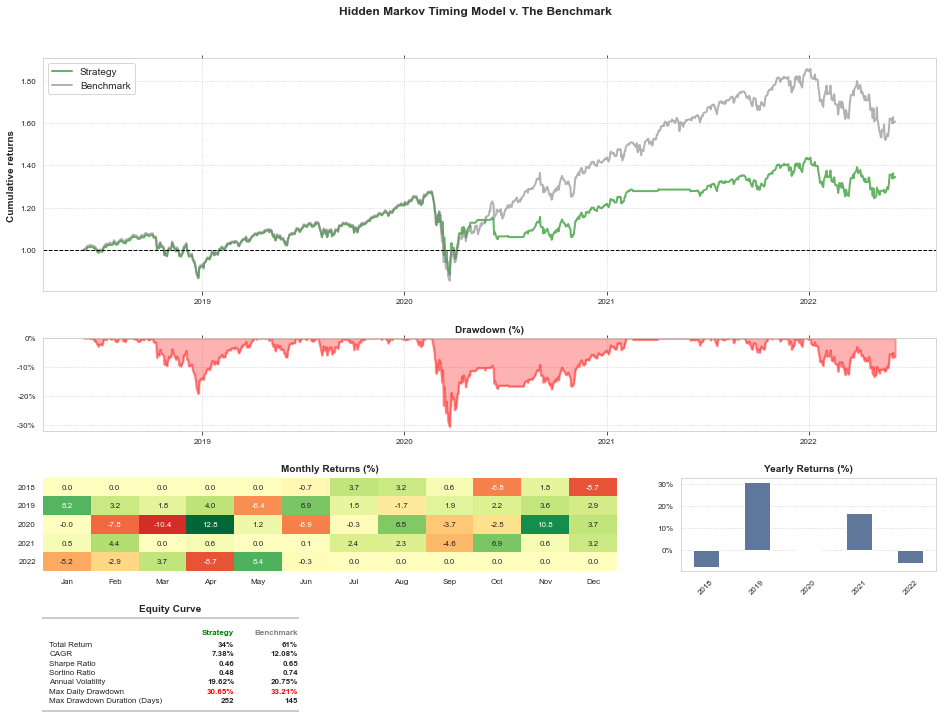

In [63]:
# Construct a benchmark Alpha Model that provides
# 100% static allocation to the SPY ETF, with no rebalance
benchmark_alpha_model = FixedSignalsAlphaModel({'EQ:SPY': 1.0})
benchmark_backtest = BacktestTradingSession(
    start_dt,
    end_dt,
    strategy_universe,
    benchmark_alpha_model,
    rebalance='buy_and_hold',
    long_only=True,
    cash_buffer_percentage=0.02,
    data_handler=data_handler
)
benchmark_backtest.run()

#tearsheet end results
tearsheet = TearsheetStatistics(
    strategy_equity=strategy_backtest.get_equity_curve(),
    benchmark_equity=benchmark_backtest.get_equity_curve(),
    title='Hidden Markov Timing Model v. The Benchmark'
)
tearsheet.plot_results()